In [1]:
# Data preprocessing libraries
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

import os
import sqlite3
import math
from collections import Counter
from pathlib import Path
from tqdm import tqdm

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# Model
from scipy.stats import skew
import yellowbrick
import sklearn
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Config
mpl.rcParams['font.family'] = 'monospace' 
sns.set_theme(style="white", palette=None)
plotly.offline.init_notebook_mode() 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# EDA

In [2]:
# Reading csv files and drop the first column
df_train = pd.read_csv("fraudTrain.csv")
df_train.drop(df_train.columns[0], axis=1, inplace=True)

df_test = pd.read_csv("fraudTest.csv")
df_test.drop(df_test.columns[0], axis=1, inplace=True)

# First view 10 rows
df_train.head(10)

trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   
5   2019-01-01 00:04:08  4767265376804500    fraud_Stroman, Hudson and Erdman   
6   2019-01-01 00:04:42    30074693890476               fraud_Rowe-Vandervort   
7   2019-01-01 00:05:08  6011360759745864                fraud_Corwin-Collins   
8   2019-01-01 00:05:18  4922710831011201                    fraud_Herzog Ltd   
9   2019-01-01 00:06:01  2720830304681674   fraud_Schoen, Kuphal and Nitzsche   

        category     amt      first      last gender  \
0       misc_net    4.97   Jennifer     Banks      F   
1    grocery_pos  107.23  Stephanie      Gill      F   
2  entertainment  220.11     Edward   Sanchez      M   
3  gas_transport   45.00     Jeremy     White      M   
4       misc_pos   41.96      Tyler    Garcia      M   
5  gas_transport   94.63   Jennifer    Conner      F   
6    grocery_net   44.54     Kelsey  Richards      F   
7  gas_transport   71.65     Steven  Williams      M   
8       misc_pos    4.27    Heather     Chase      F   
9    grocery_pos  198.39    Melissa   Aguilar      F   

                           street            city  ...      lat      long  \
0                  561 Perry Cove  Moravian Falls  ...  36.0788  -81.1781   
1    43039 Riley Greens Suite 393          Orient  ...  48.8878 -118.2105   
2        594 White Dale Suite 530      Malad City  ...  42.1808 -112.2620   
3     9443 Cynthia Court Apt. 038         Boulder  ...  46.2306 -112.1138   
4                408 Bradley Rest        Doe Hill  ...  38.4207  -79.4629   
5               4655 David Island          Dublin  ...  40.3750  -75.2045   
6     889 Sarah Station Suite 624         Holcomb  ...  37.9931 -100.9893   
7       231 Flores Pass Suite 720        Edinburg  ...  38.8432  -78.6003   
8     6888 Hicks Stream Suite 954           Manor  ...  40.3359  -79.6607   
9  21326 Taylor Squares Suite 708     Clarksville  ...  36.5220  -87.3490   

   city_pop                                job         dob  \
0      3495          Psychologist, counselling  1988-03-09   
1       149  Special educational needs teacher  1978-06-21   
2      4154        Nature conservation officer  1962-01-19   
3      1939                    Patent attorney  1967-01-12   
4        99     Dance movement psychotherapist  1986-03-28   
5      2158                  Transport planner  1961-06-19   
6      2691                    Arboriculturist  1993-08-16   
7      6018               Designer, multimedia  1947-08-21   
8      1472          Public affairs consultant  1941-03-07   
9    151785                        Pathologist  1974-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   
5  189a841a0a8ba03058526bcfe566aab5  1325376248  40.653382  -76.152667   
6  83ec1cc84142af6e2acf10c44949e720  1325376282  37.162705 -100.153370   
7  6d294ed2cc447d2c71c7171a3d54967c  1325376308  38.948089  -78.540296   
8  fc28024ce480f8ef21a32d64c93a29f5  1325376318  40.351813  -79.958146   
9  3b9014ea8fb80bd65de0b1463b00b00e  1325376361  37.179198  -87.485381   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         0  
7         0  
8         0  
9      

### Data preprocessing

In [3]:
df_train.describe().T

count          mean           std           min           25%  \
cc_num      1296675.0  4.171920e+17  1.308806e+18  6.041621e+10  1.800429e+14   
amt         1296675.0  7.035104e+01  1.603160e+02  1.000000e+00  9.650000e+00   
zip         1296675.0  4.880067e+04  2.689322e+04  1.257000e+03  2.623700e+04   
lat         1296675.0  3.853762e+01  5.075808e+00  2.002710e+01  3.462050e+01   
long        1296675.0 -9.022634e+01  1.375908e+01 -1.656723e+02 -9.679800e+01   
city_pop    1296675.0  8.882444e+04  3.019564e+05  2.300000e+01  7.430000e+02   
unix_time   1296675.0  1.349244e+09  1.284128e+07  1.325376e+09  1.338751e+09   
merch_lat   1296675.0  3.853734e+01  5.109788e+00  1.902779e+01  3.473357e+01   
merch_long  1296675.0 -9.022646e+01  1.377109e+01 -1.666712e+02 -9.689728e+01   
is_fraud    1296675.0  5.788652e-03  7.586269e-02  0.000000e+00  0.000000e+00   

                     50%           75%           max  
cc_num      3.521417e+15  4.642255e+15  4.992346e+18  
amt         4.752000e+01  8.314000e+01  2.894890e+04  
zip         4.817400e+04  7.204200e+04  9.978300e+04  
lat         3.935430e+01  4.194040e+01  6.669330e+01  
long       -8.747690e+01 -8.015800e+01 -6.795030e+01  
city_pop    2.456000e+03  2.032800e+04  2.906700e+06  
unix_time   1.349250e+09  1.359385e+09  1.371817e+09  
merch_lat   3.936568e+01  4.195716e+01  6.751027e+01  
merch_long -8.743839e+01 -8.023680e+01 -6.695090e+01  
is_fraud    0.000000e+00  0.000000e+00  1.000000e+00

In [4]:
df_train.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

As we can see, there is no missing values!

In [5]:
df_train["amt"].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

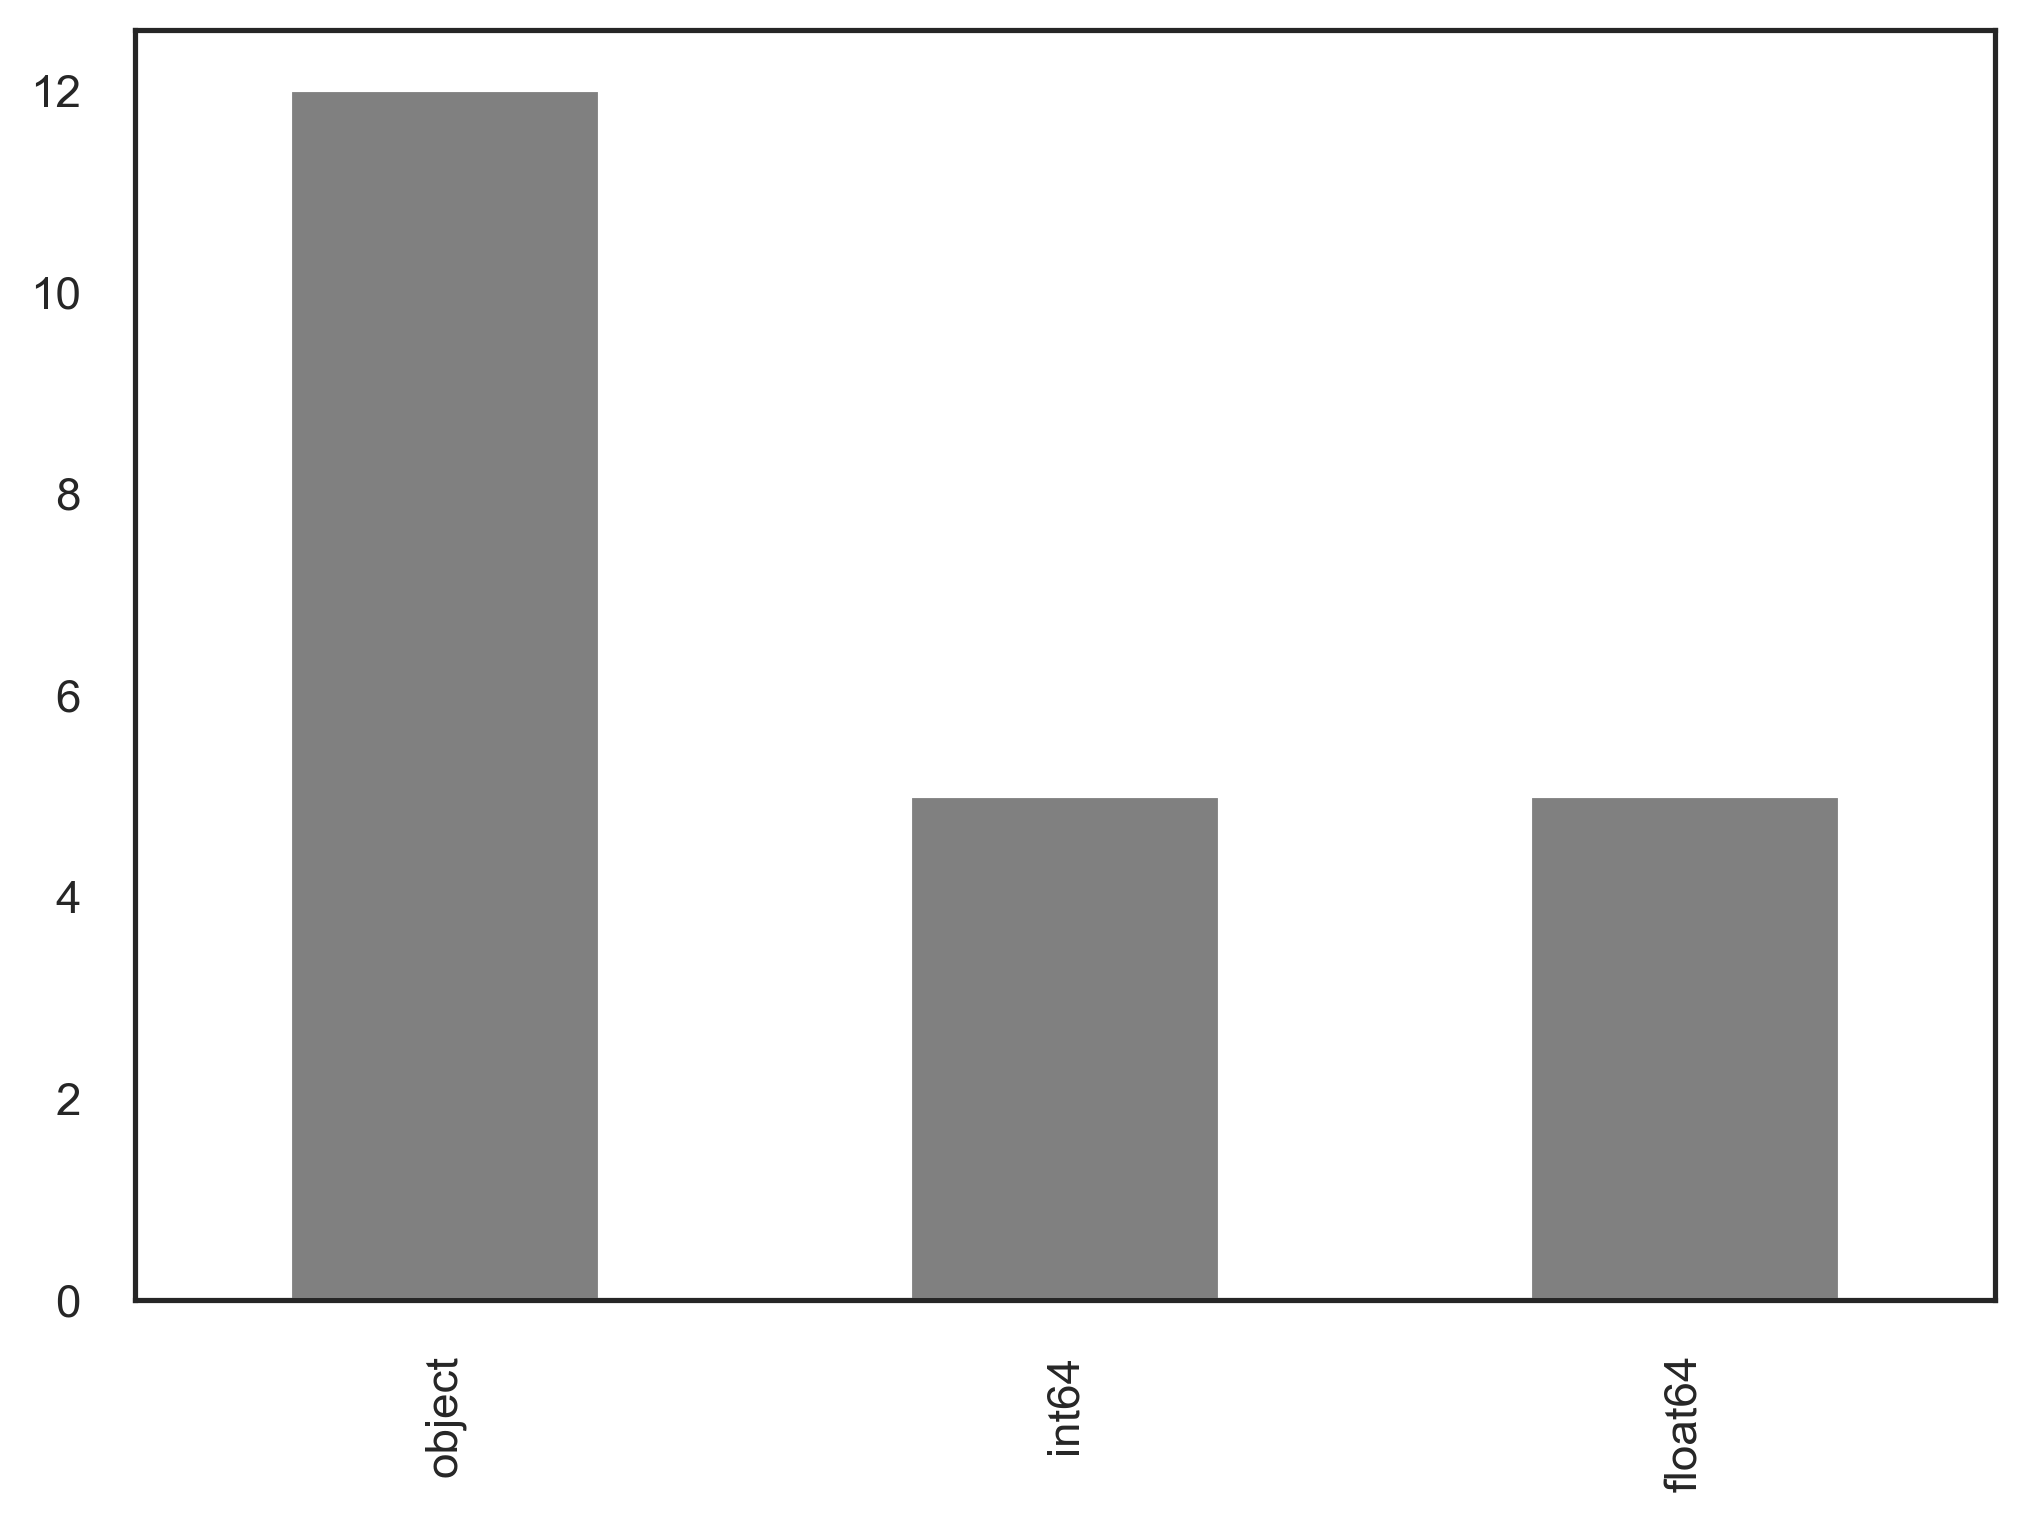

In [6]:
df_train.dtypes.value_counts().plot(kind='bar', color="grey");

 There are a lot of categorical features! So we are probably going to consider categorical encoding.

# Univariate analysis

Lets check the target imbalance!

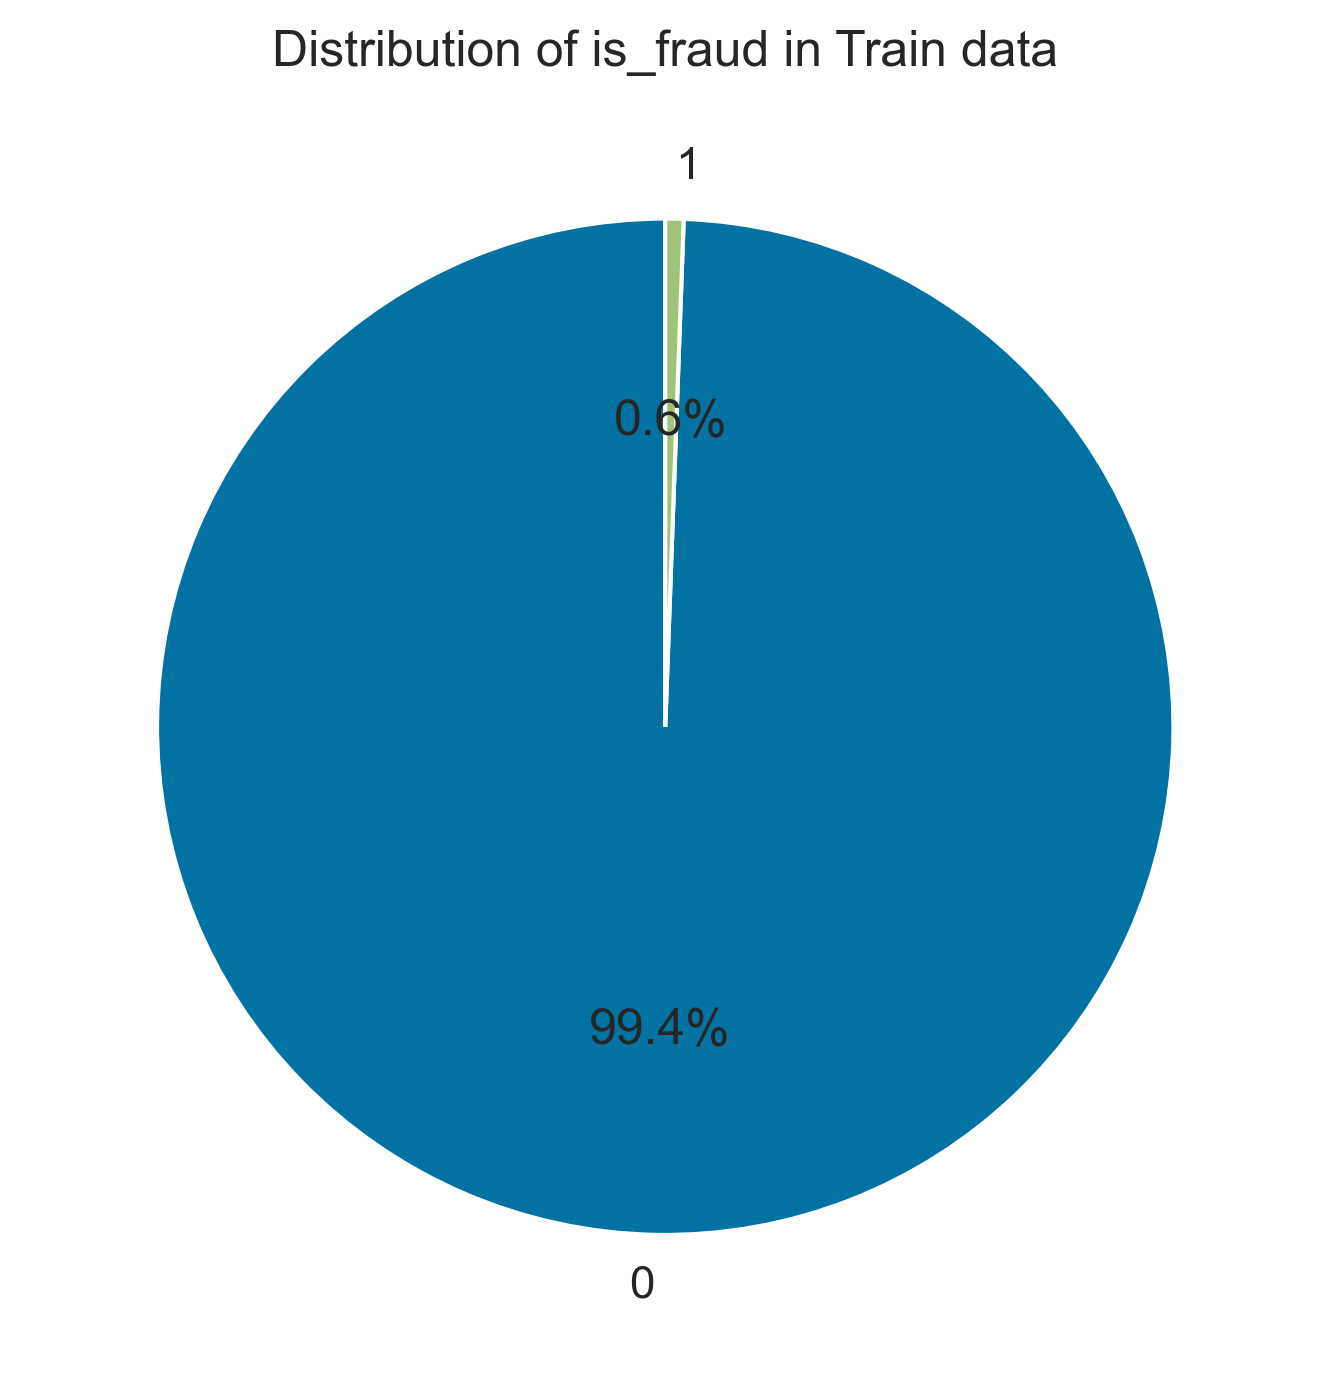

0    1289169
1       7506
Name: is_fraud, dtype: int64


In [7]:
value_counts = df_train['is_fraud'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of is_fraud in Train data')
plt.show()
print(value_counts)

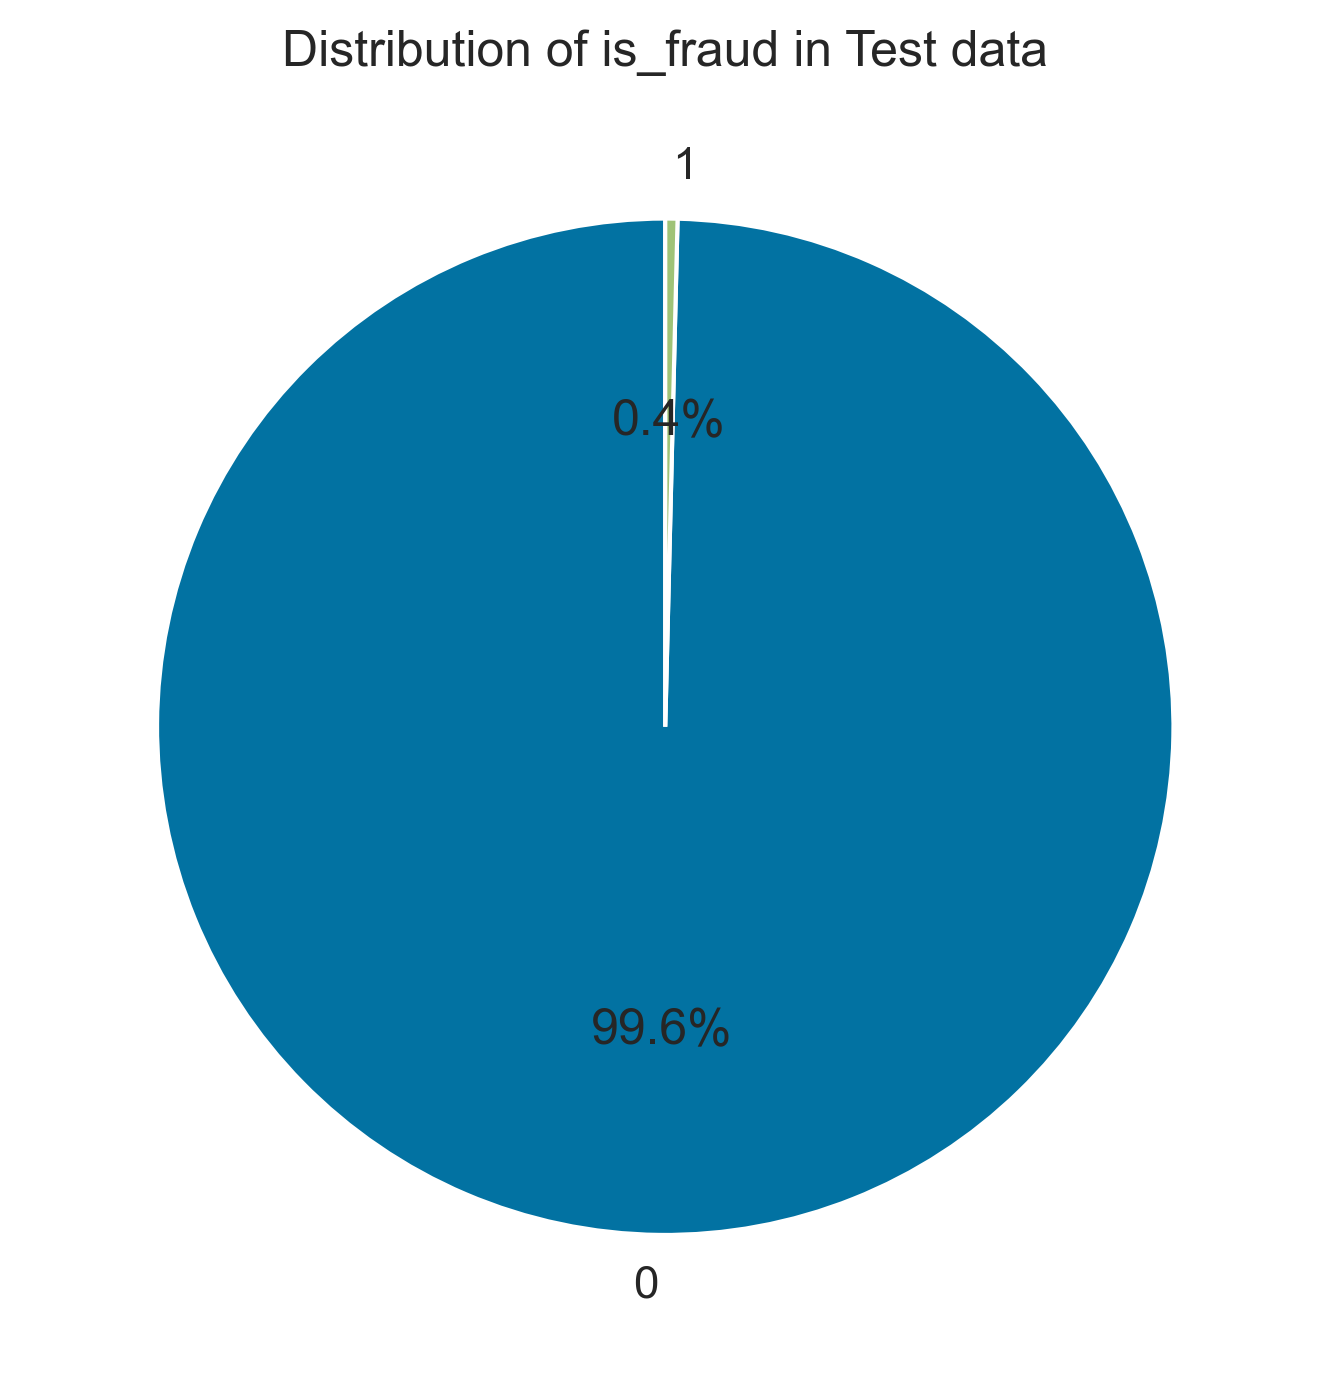

0    553574
1      2145
Name: is_fraud, dtype: int64


In [8]:
value_counts = df_test['is_fraud'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of is_fraud in Test data')
plt.show()
print(value_counts)

We have a severe imbalance dataset. Because of this, Oversampling/Undersampling will be considered in the model.

Comment: Both train and test dataset are similarly imbalanced. As such, cross-validation techniques for partitioning purposes are not required.

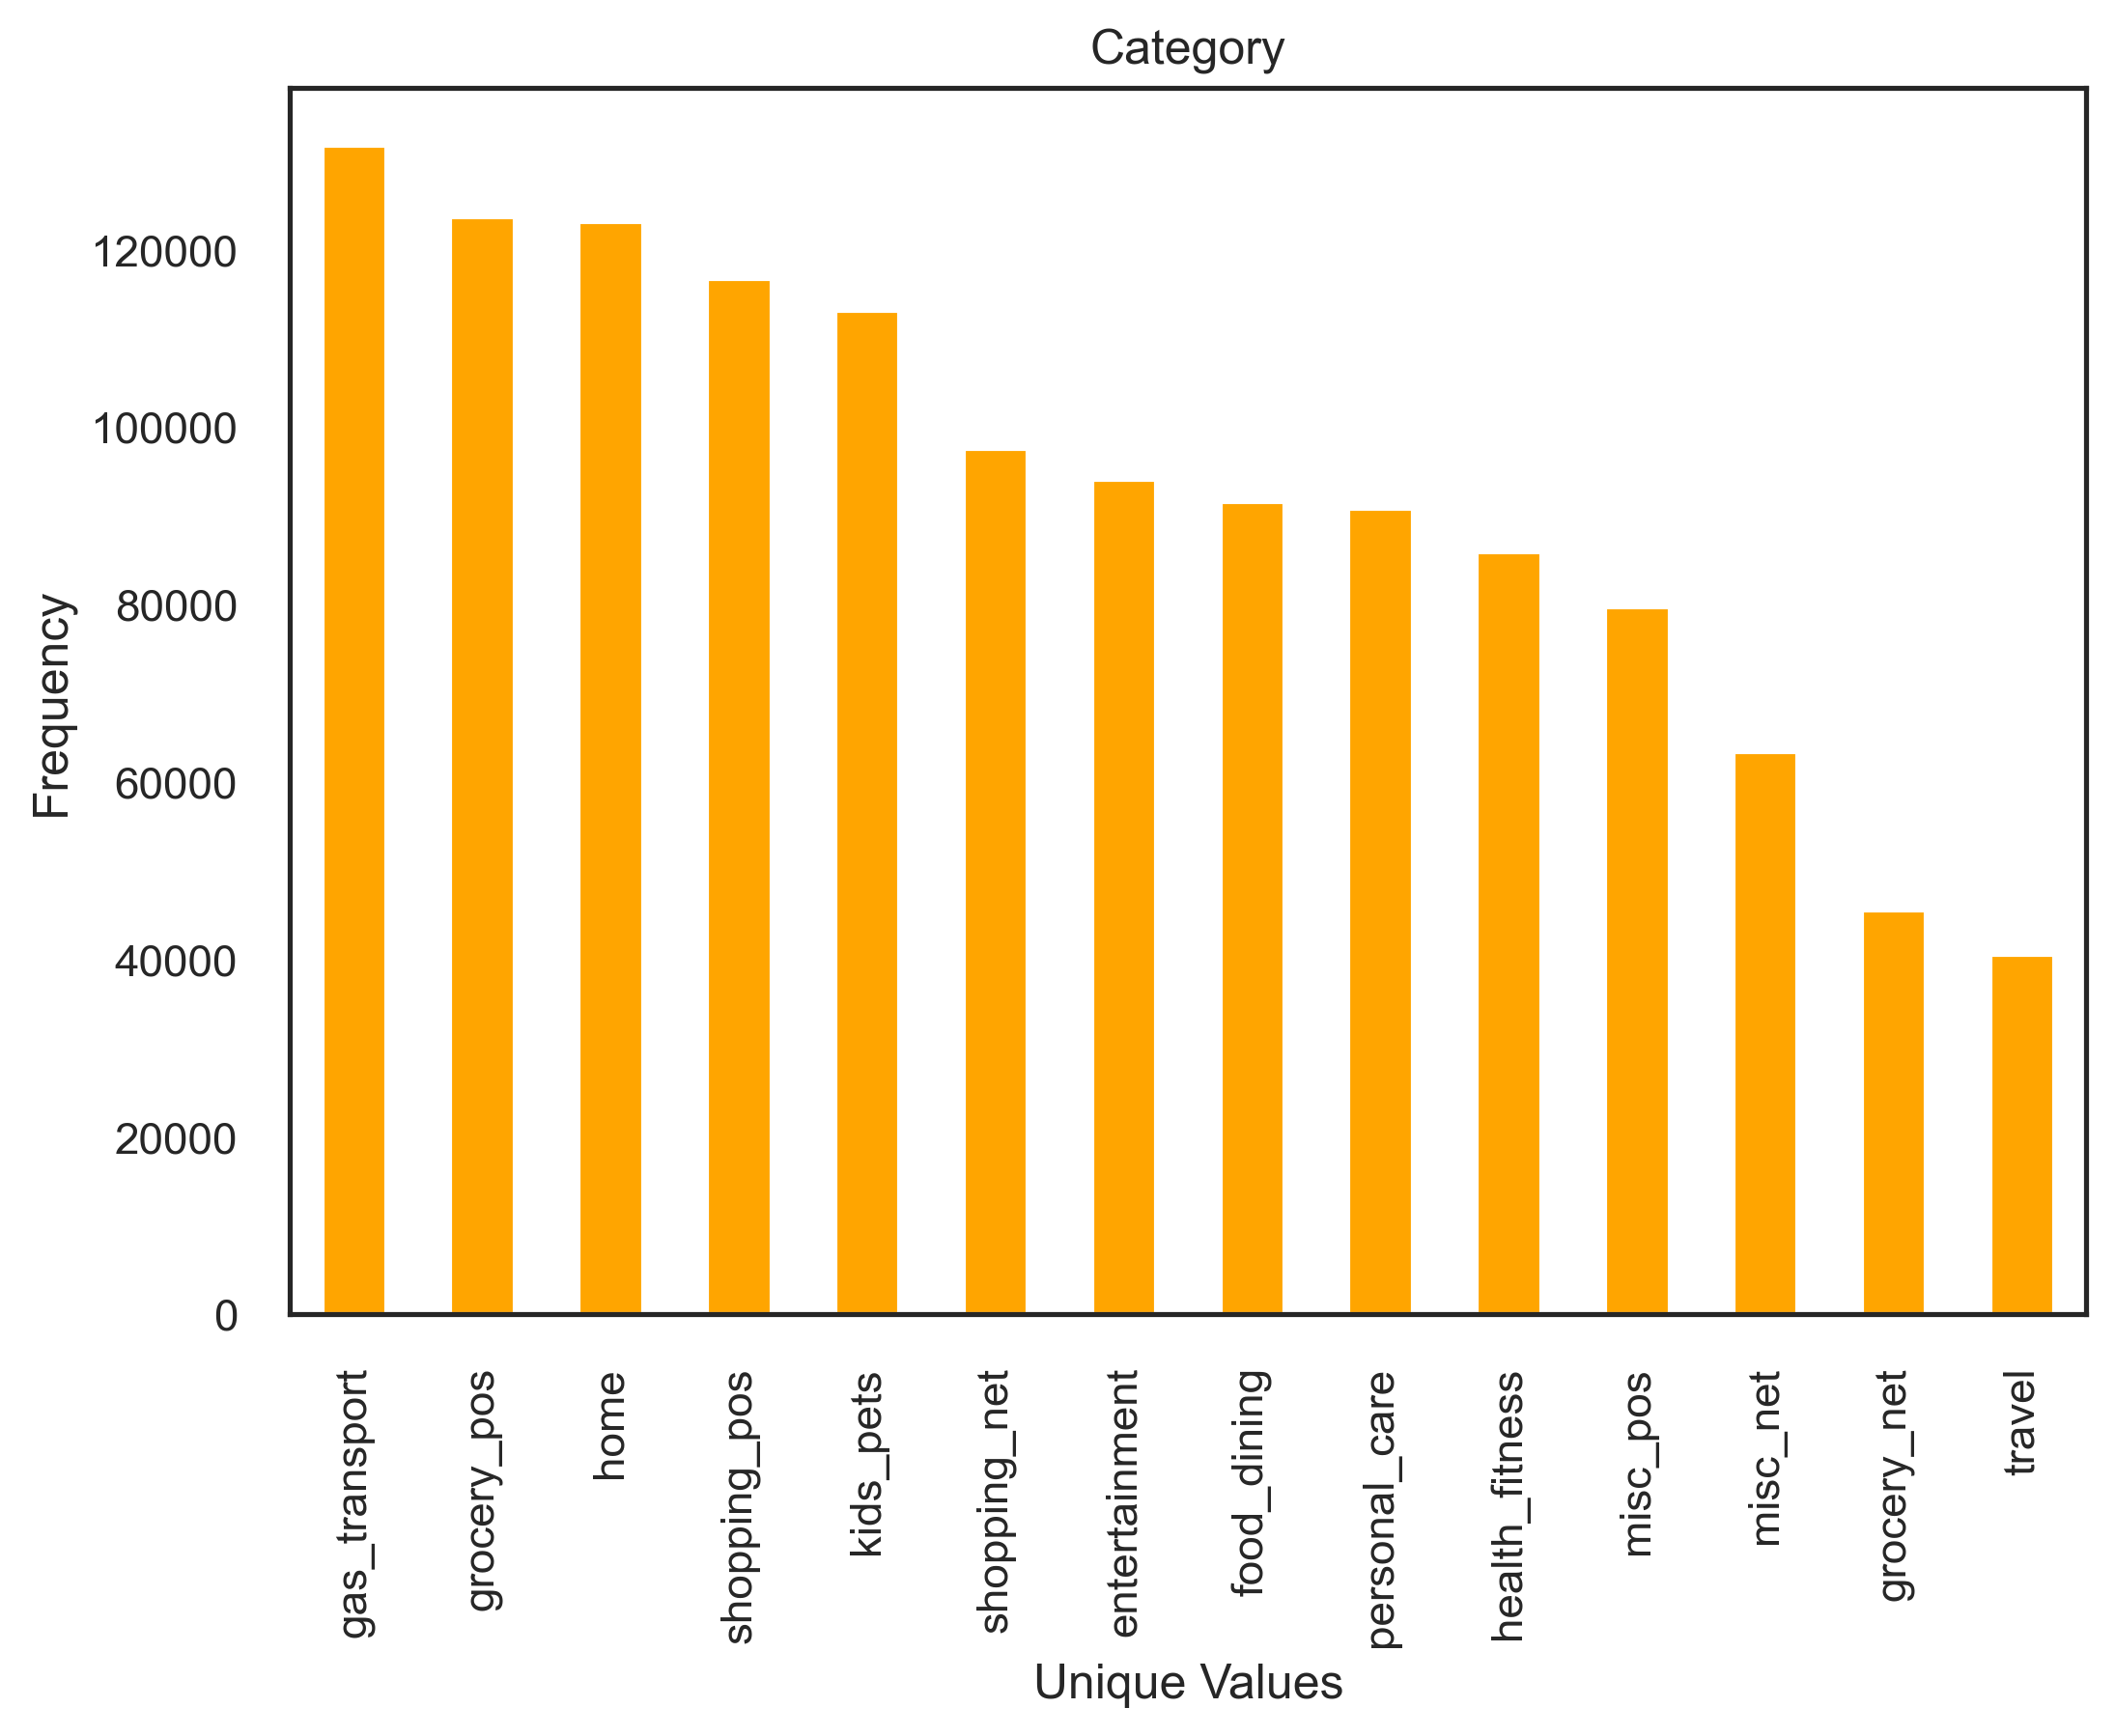

In [9]:
value_counts = df_train['category'].value_counts()
value_counts.plot(kind='bar', color='orange')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Category')
plt.show()

Let's check the distribution of the amount ("amt") feature.

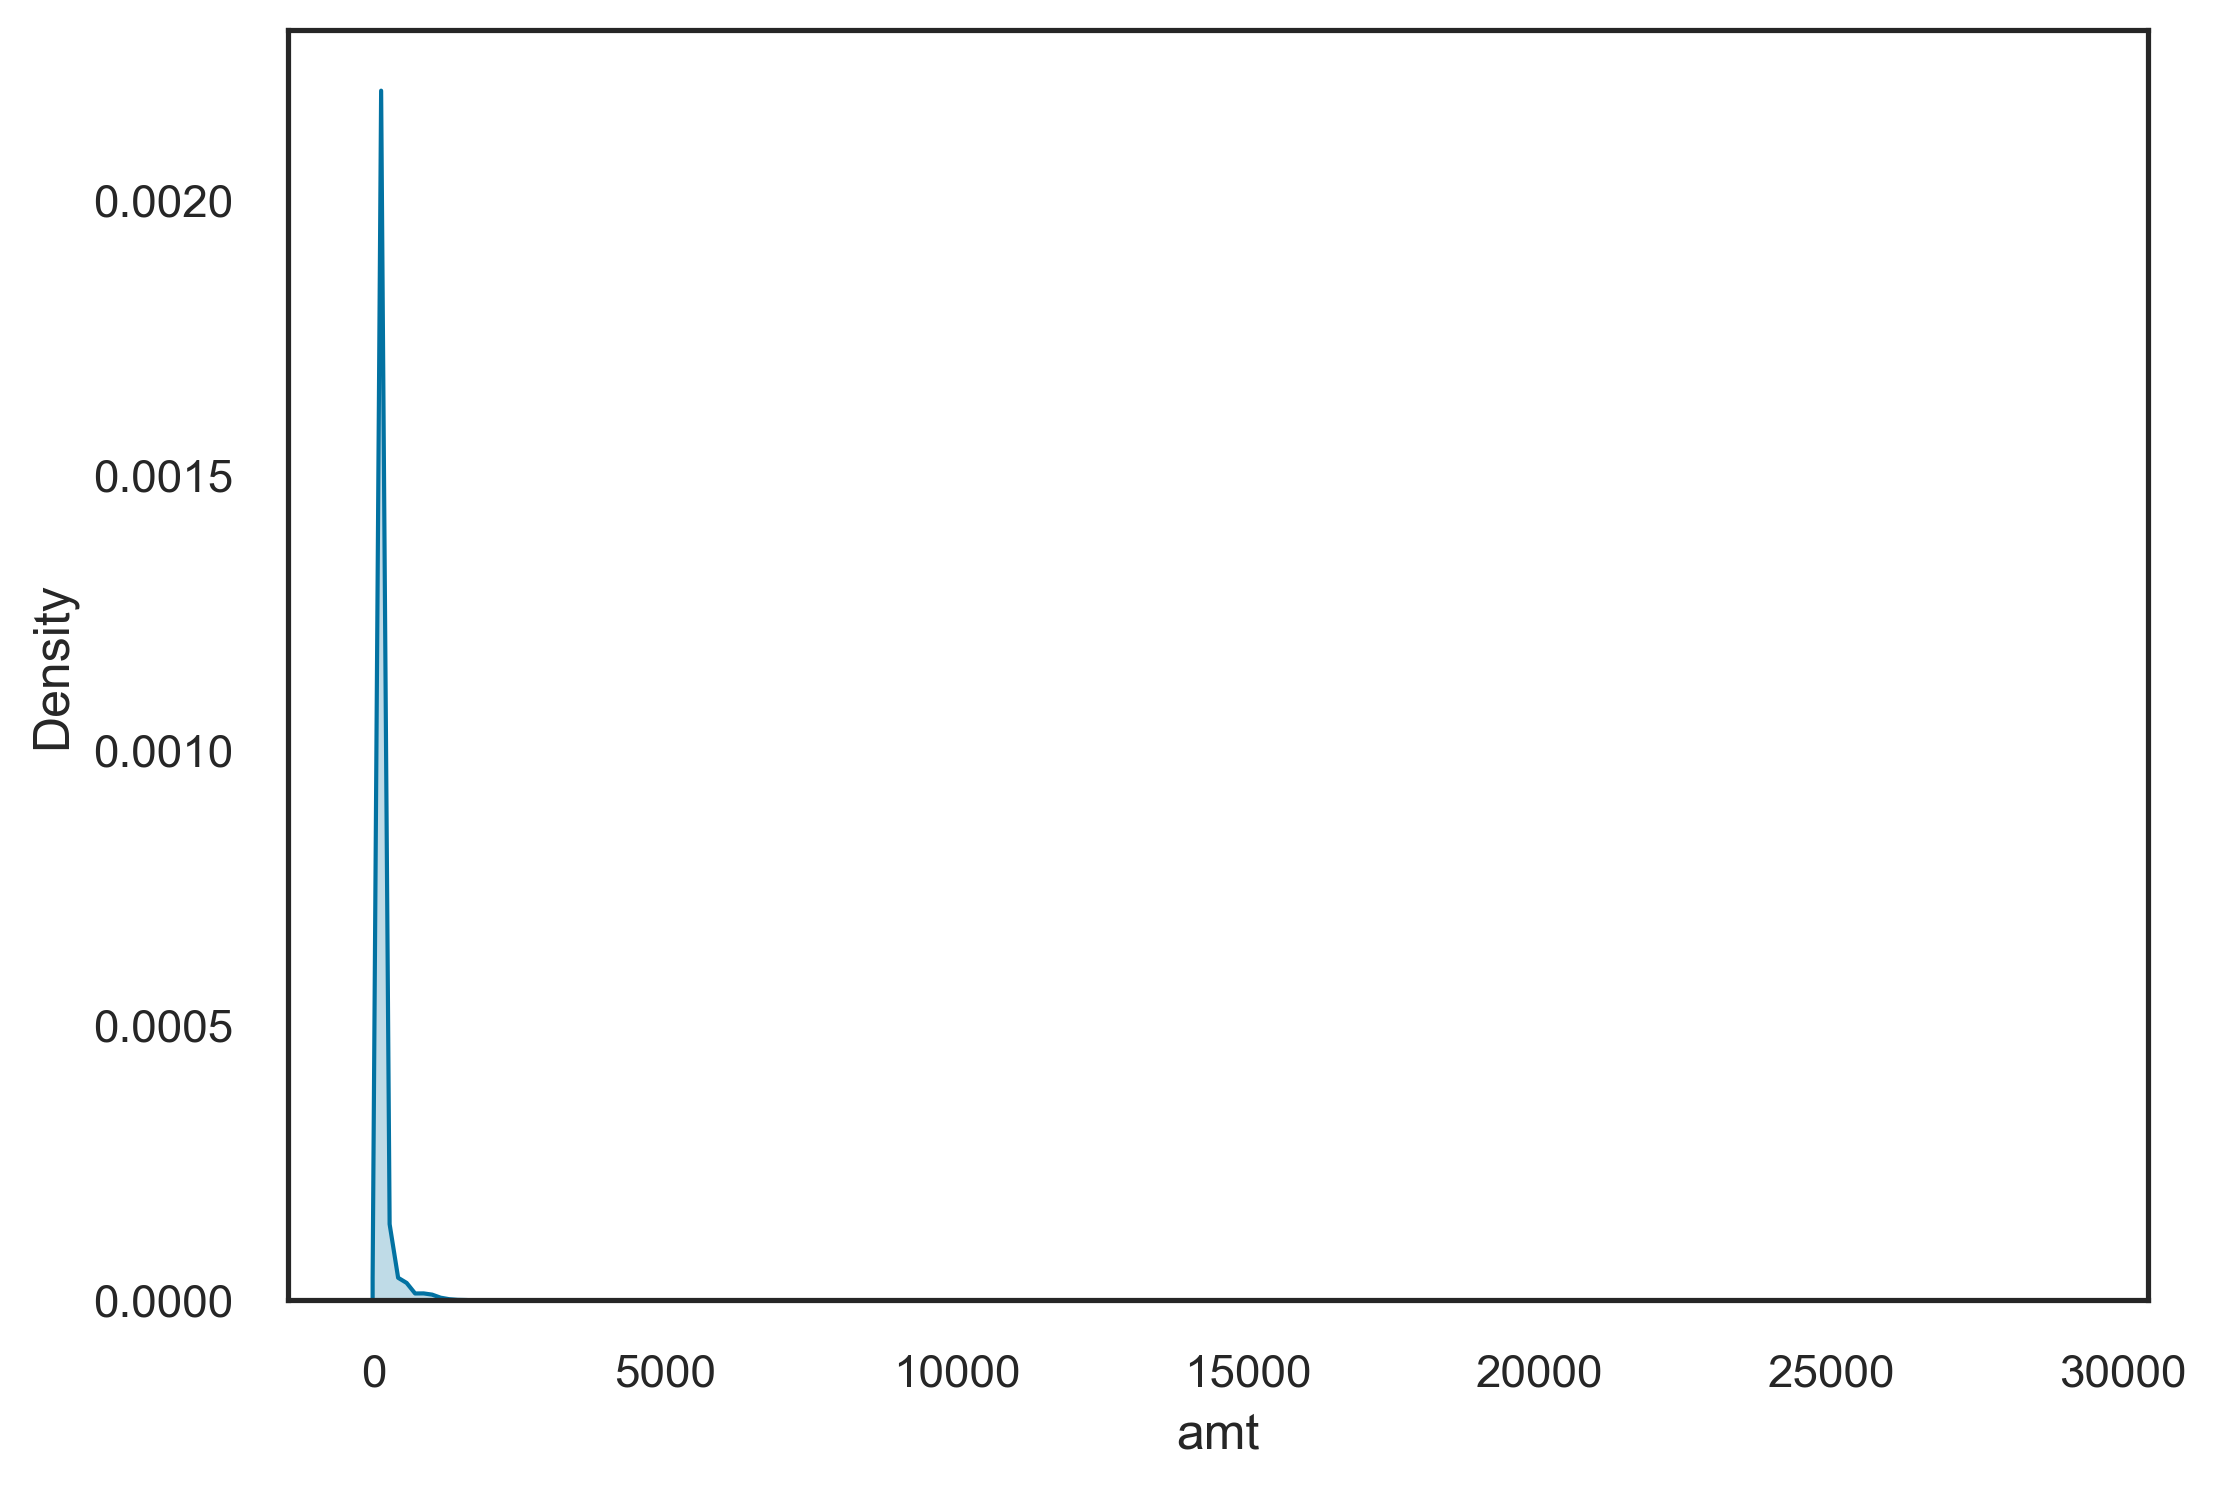

In [10]:
sns.kdeplot(df_train["amt"], fill=True);

Higher values of amount is distorting the graph. So we fix it plotting only 0-99% of amount.

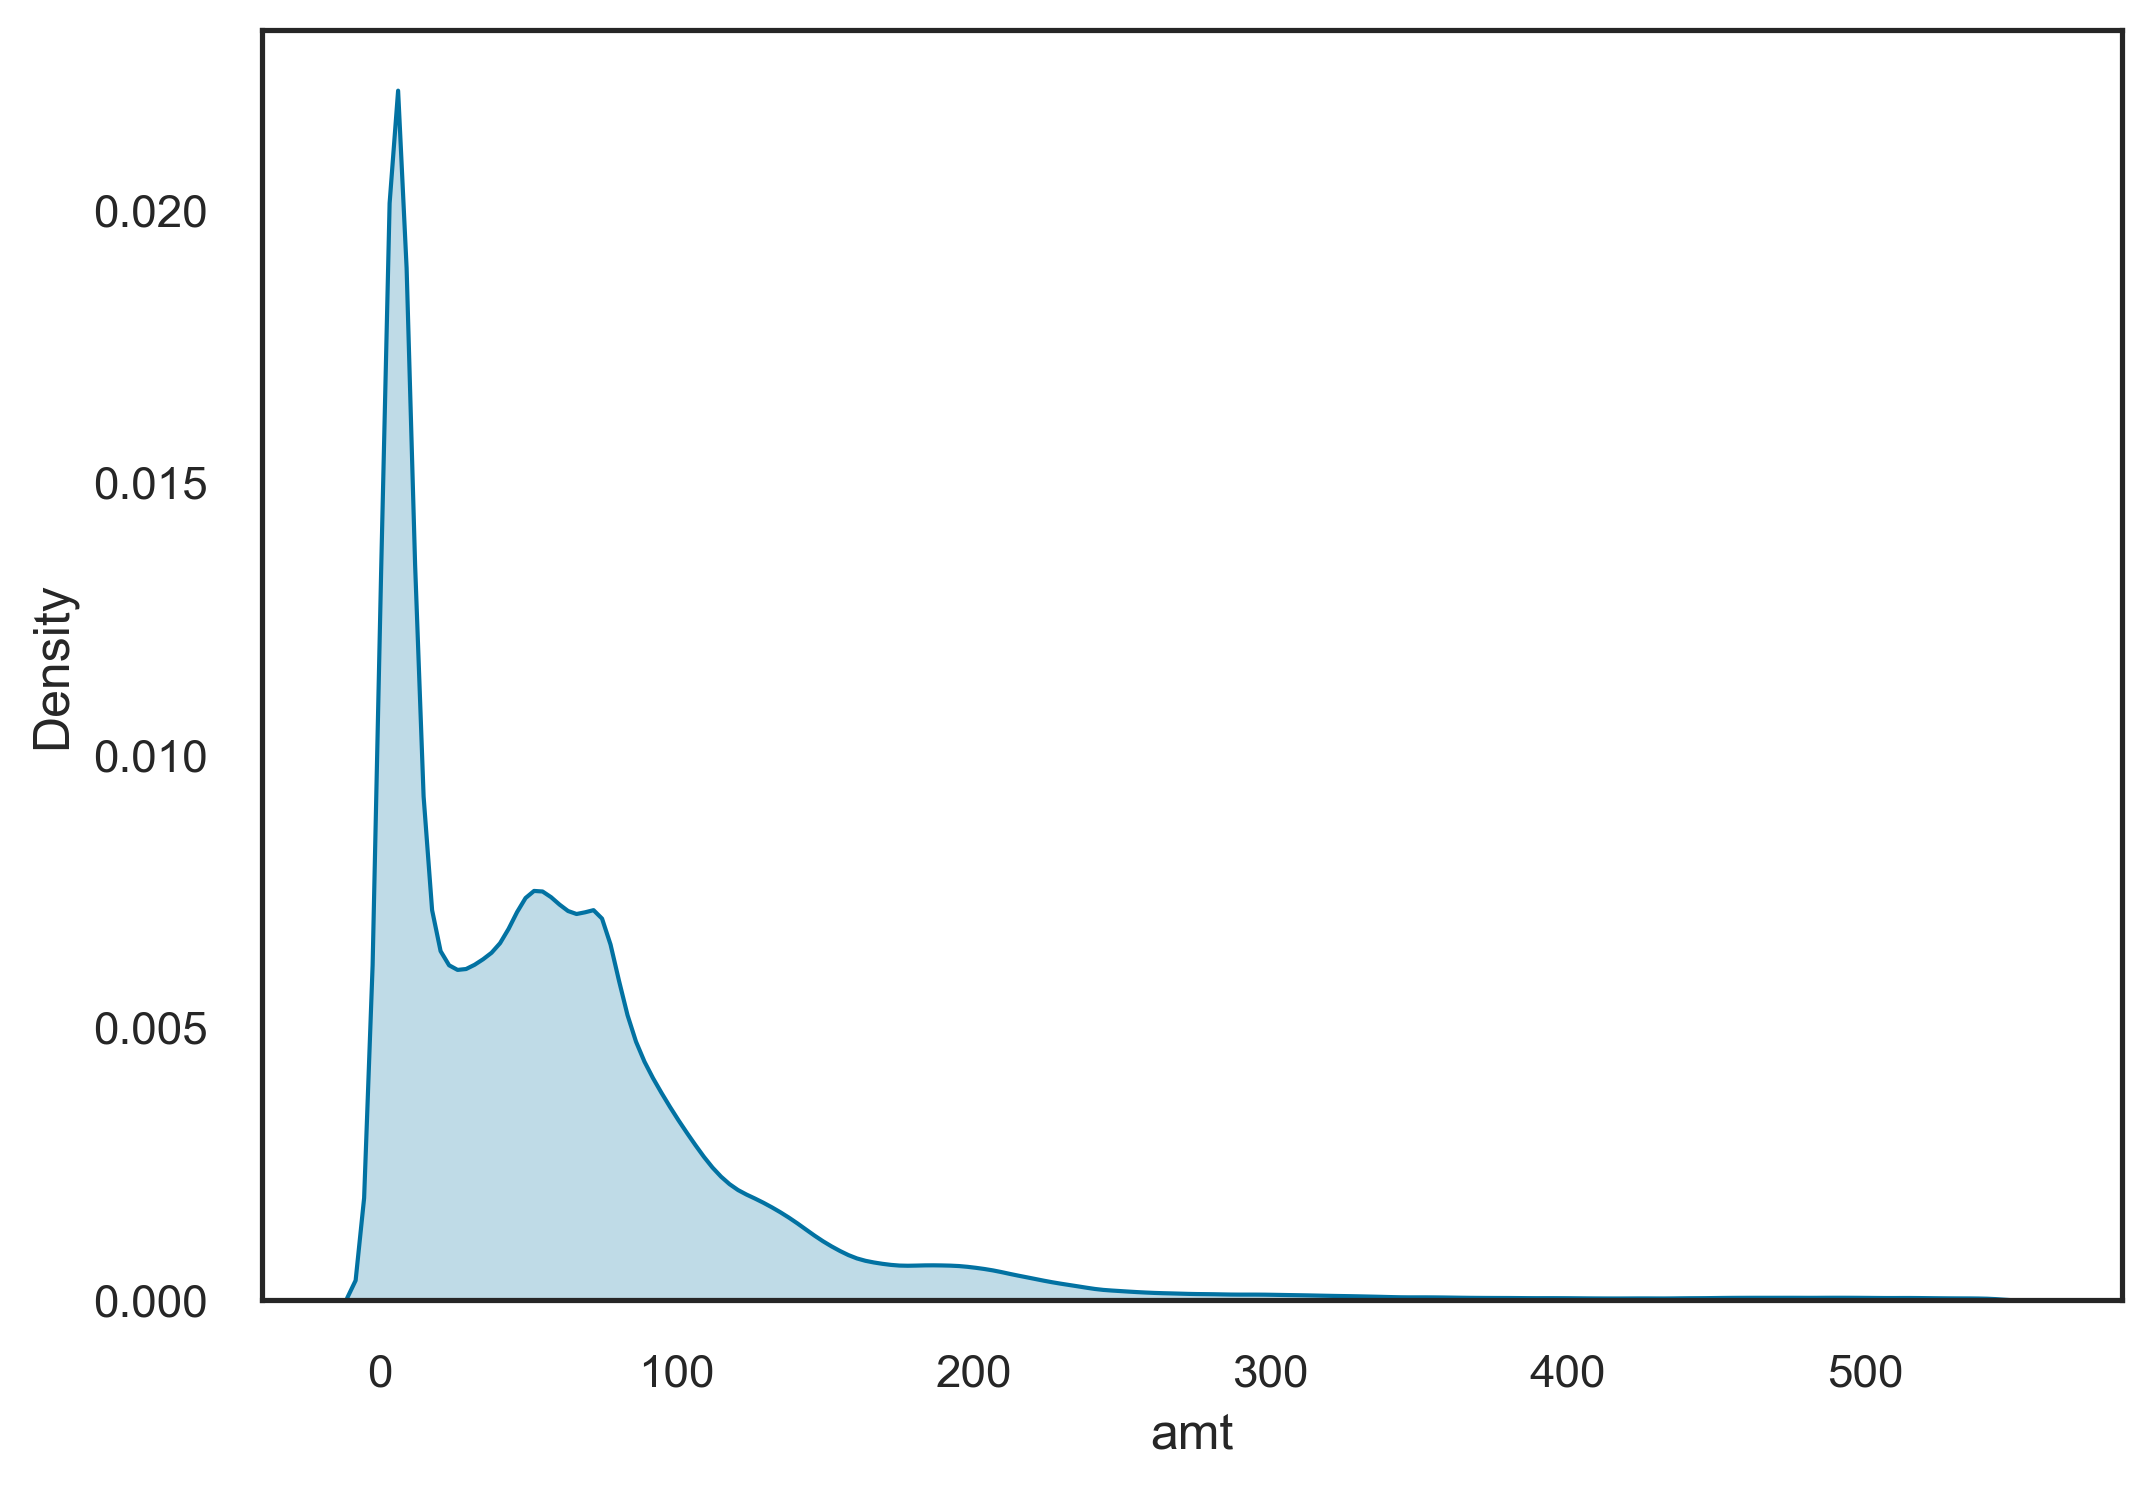

In [11]:
p99 = df_train["amt"].quantile(0.99)
sns.kdeplot(x="amt", data=df_train[df_train["amt"] <= p99], fill=True);

Lets se if there is any noticeable pattern between the target (is_fraud) and amount.

## Multivariate analysis

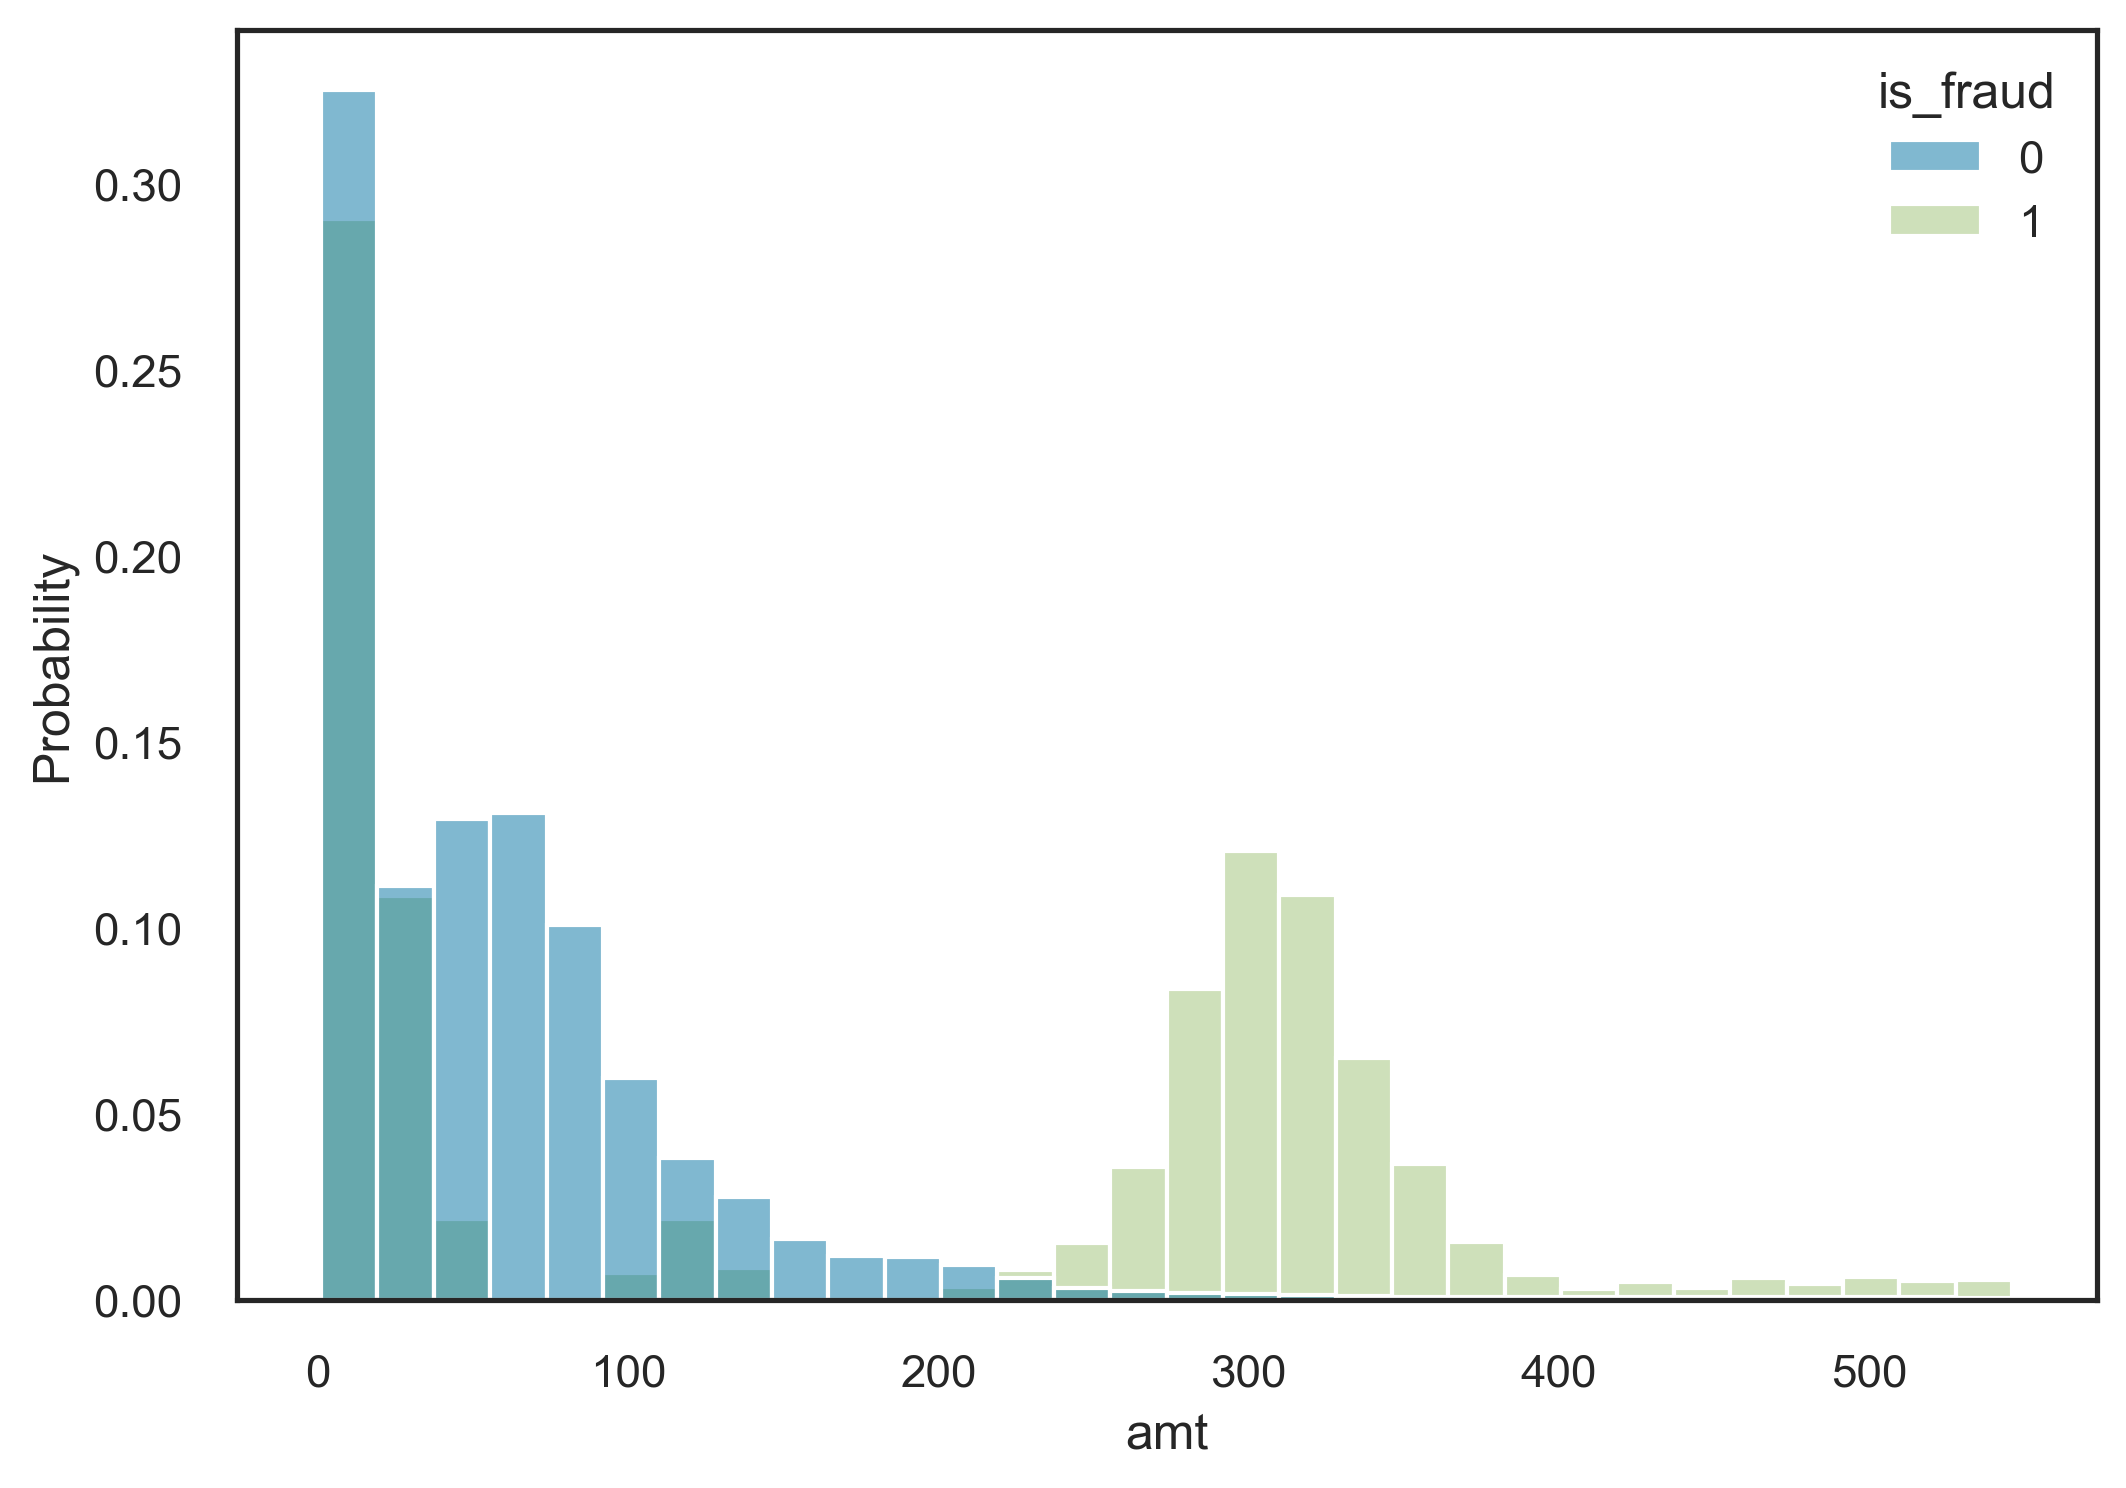

In [12]:
p99 = df_train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="probability", data=df_train[df_train["amt"] <= p99],
             common_norm=False);

Notice that the probability distribution behaves differently for each value of "is_fraud".

We can expand this analysis to each transaction category

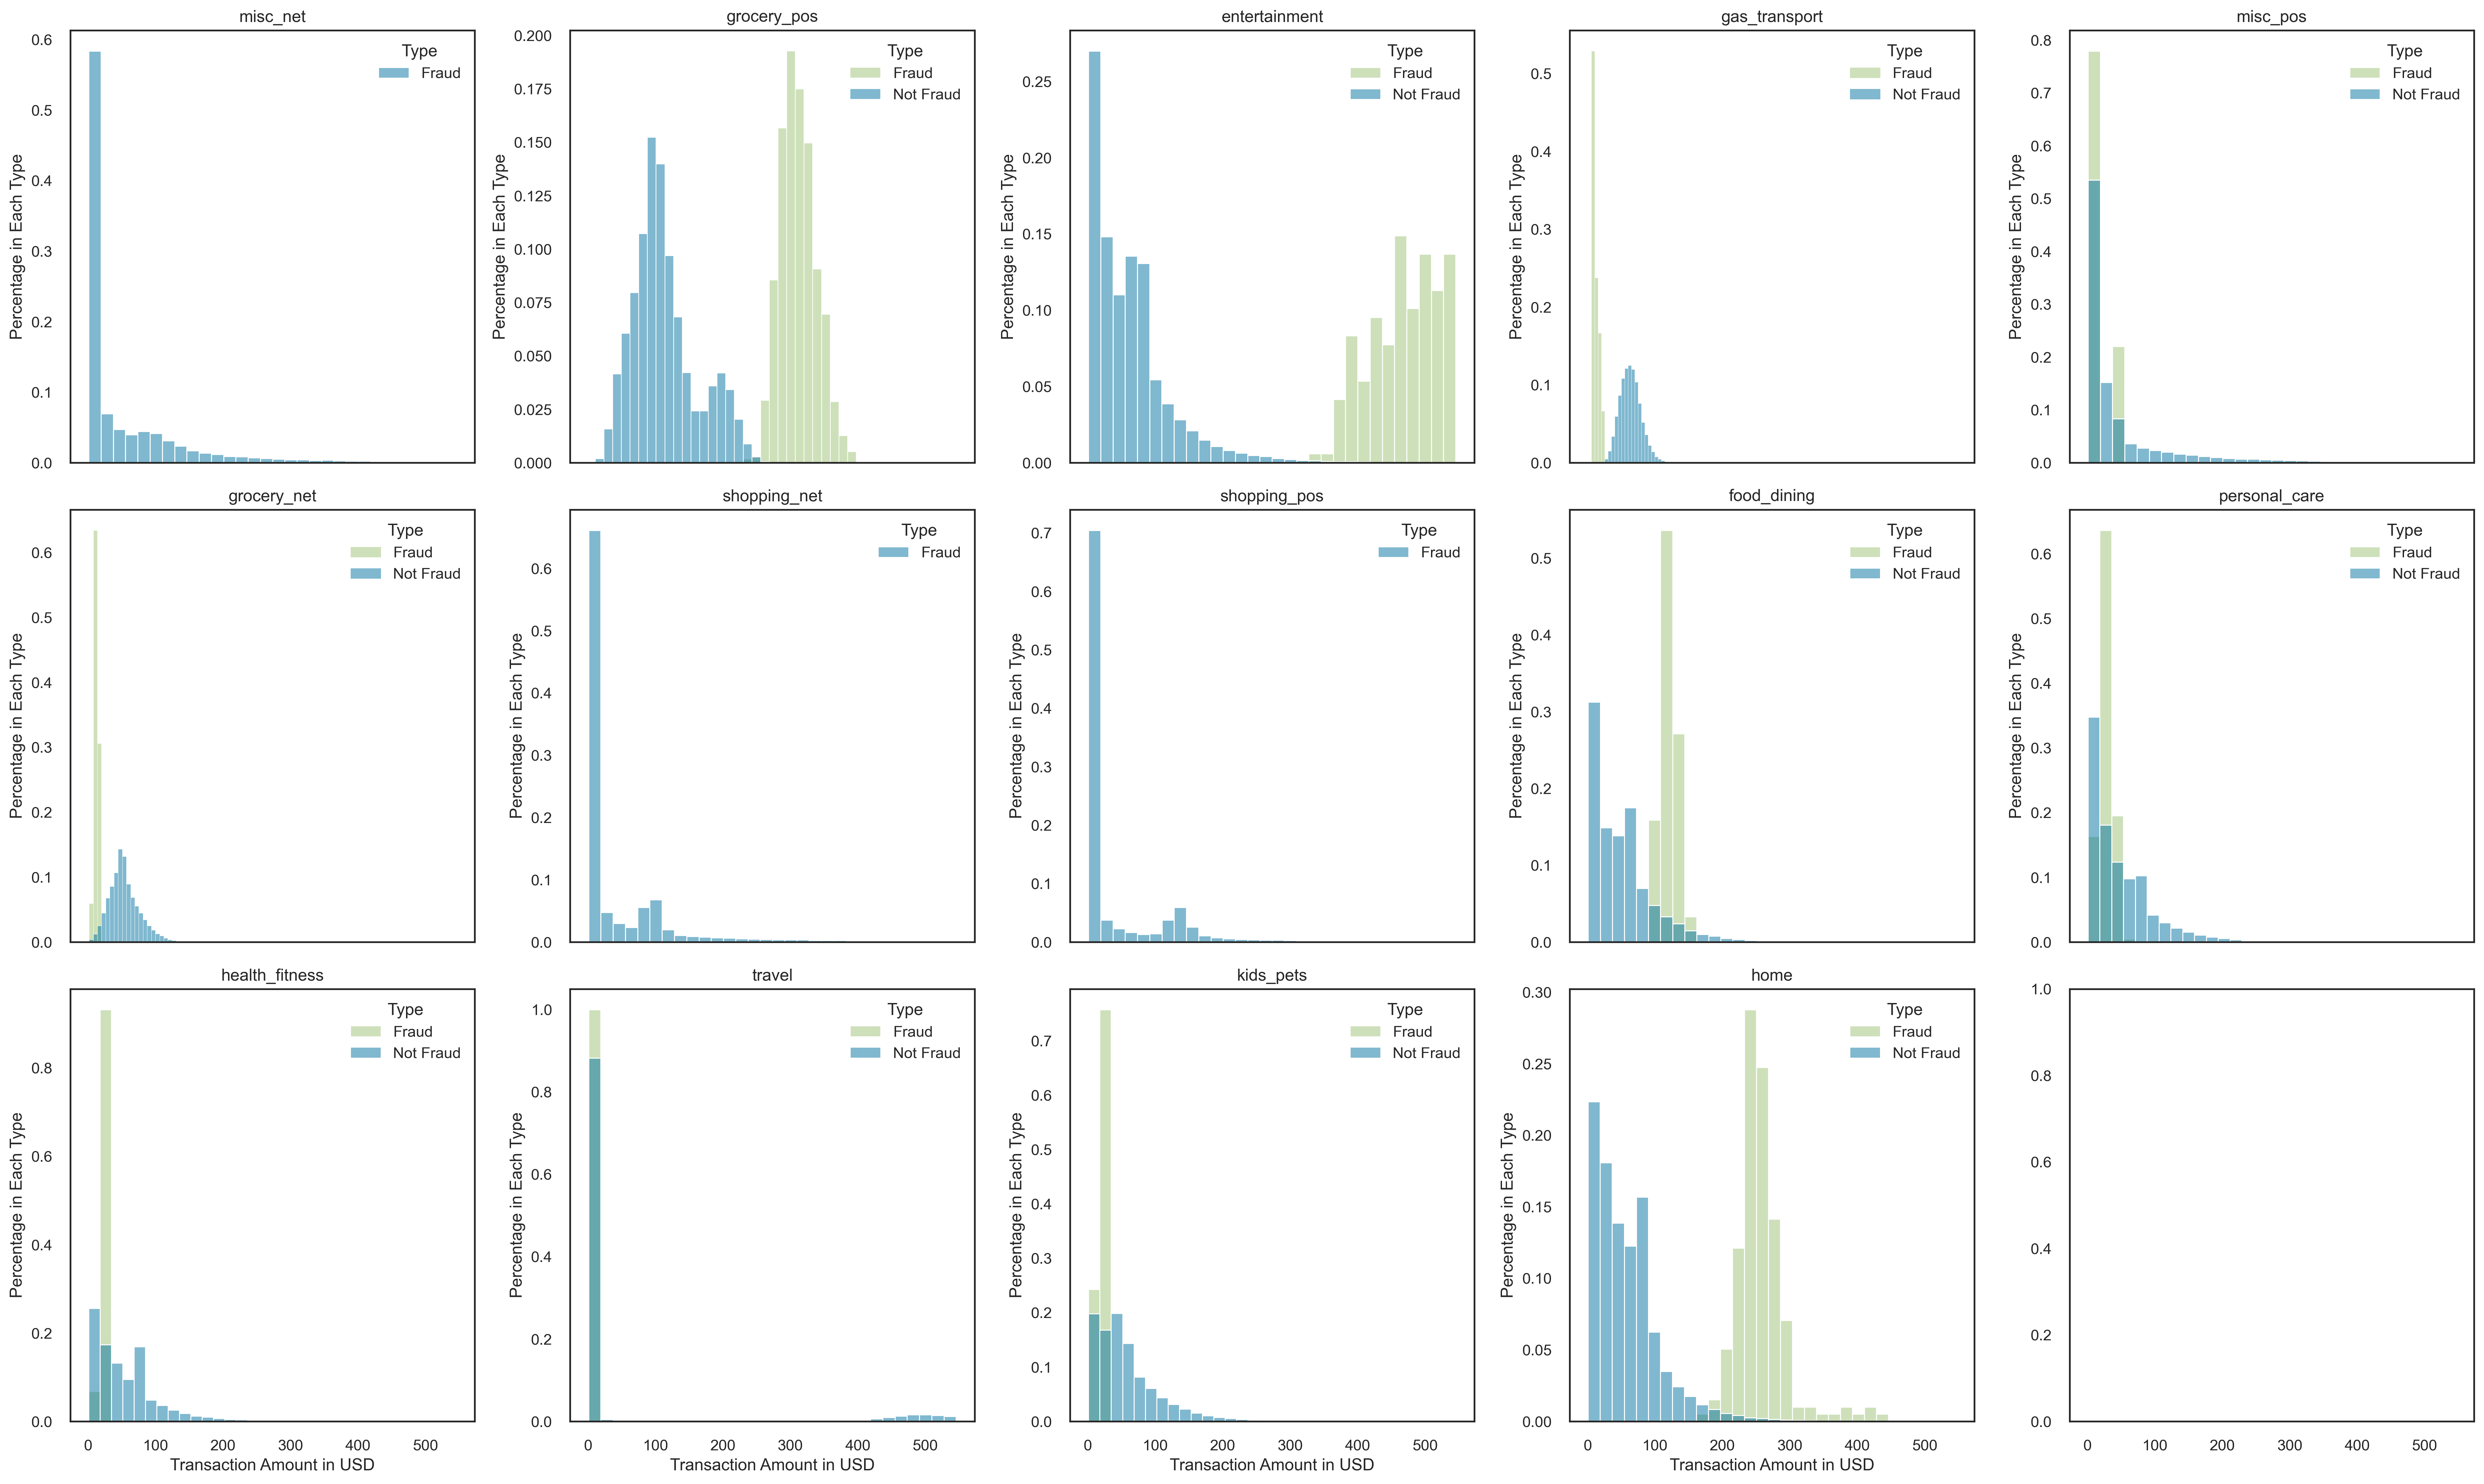

In [13]:
categories = df_train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = df_train[df_train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

Lets dive into categories. We'll analyze which categories the frauds are more frequently. For this, we'll calculate the distribution for each category for normal transactions and then the distribution for fraudulents transactions. Then, we take the difference between the two distributions. This difference shows us the categories that are most predominants to have frauds.

In [14]:
# non_fraud
non_fraud = df_train[df_train['is_fraud'] == 0]['category'].value_counts(
    normalize=True).to_frame().reset_index()
non_fraud.columns = ['category', 'not_fraud_percentual_vs_total']

# fraud
fraud = df_train[df_train['is_fraud'] == 1]['category'].value_counts(
    normalize=True).to_frame().reset_index()
fraud.columns = ['category', 'fraud_percentage_vs_total']

# merging two dataframes and calculating "fraud level"
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_level'] = non_fraud_vs_fraud['fraud_percentage_vs_total'] - \
    non_fraud_vs_fraud['not_fraud_percentual_vs_total']

non_fraud_vs_fraud

category  not_fraud_percentual_vs_total  fraud_percentage_vs_total  \
0    gas_transport                       0.101648                   0.082334   
1             home                       0.095346                   0.026379   
2      grocery_pos                       0.094553                   0.232214   
3     shopping_pos                       0.089848                   0.112310   
4        kids_pets                       0.087495                   0.031841   
5     shopping_net                       0.074335                   0.228217   
6    entertainment                       0.072745                   0.031042   
7      food_dining                       0.070829                   0.020117   
8    personal_care                       0.070230                   0.029310   
9   health_fitness                       0.066513                   0.017719   
10        misc_pos                       0.061594                   0.033307   
11        misc_net                       0.048382                   0.121902   
12     grocery_net                       0.035153                   0.017852   
13          travel                       0.031331                   0.015454   

    fraud_level  
0     -0.019314  
1     -0.068967  
2      0.137661  
3      0.022462  
4     -0.055654  
5      0.153883  
6     -0.041703  
7     -0.050711  
8     -0.040920  
9     -0.048793  
10    -0.028287  
11     0.073521  
12    -0.017300  
13    -0.015877

Note that the columns "not_fraud_percentual_vs_total" and "fraud_percentage_vs_total" sums up to 1. That's because we are taking the percentual of each category on total, for fraud and not fraud, and calculating the "fraud_level" metric, that shows which category is more common to have frauds.

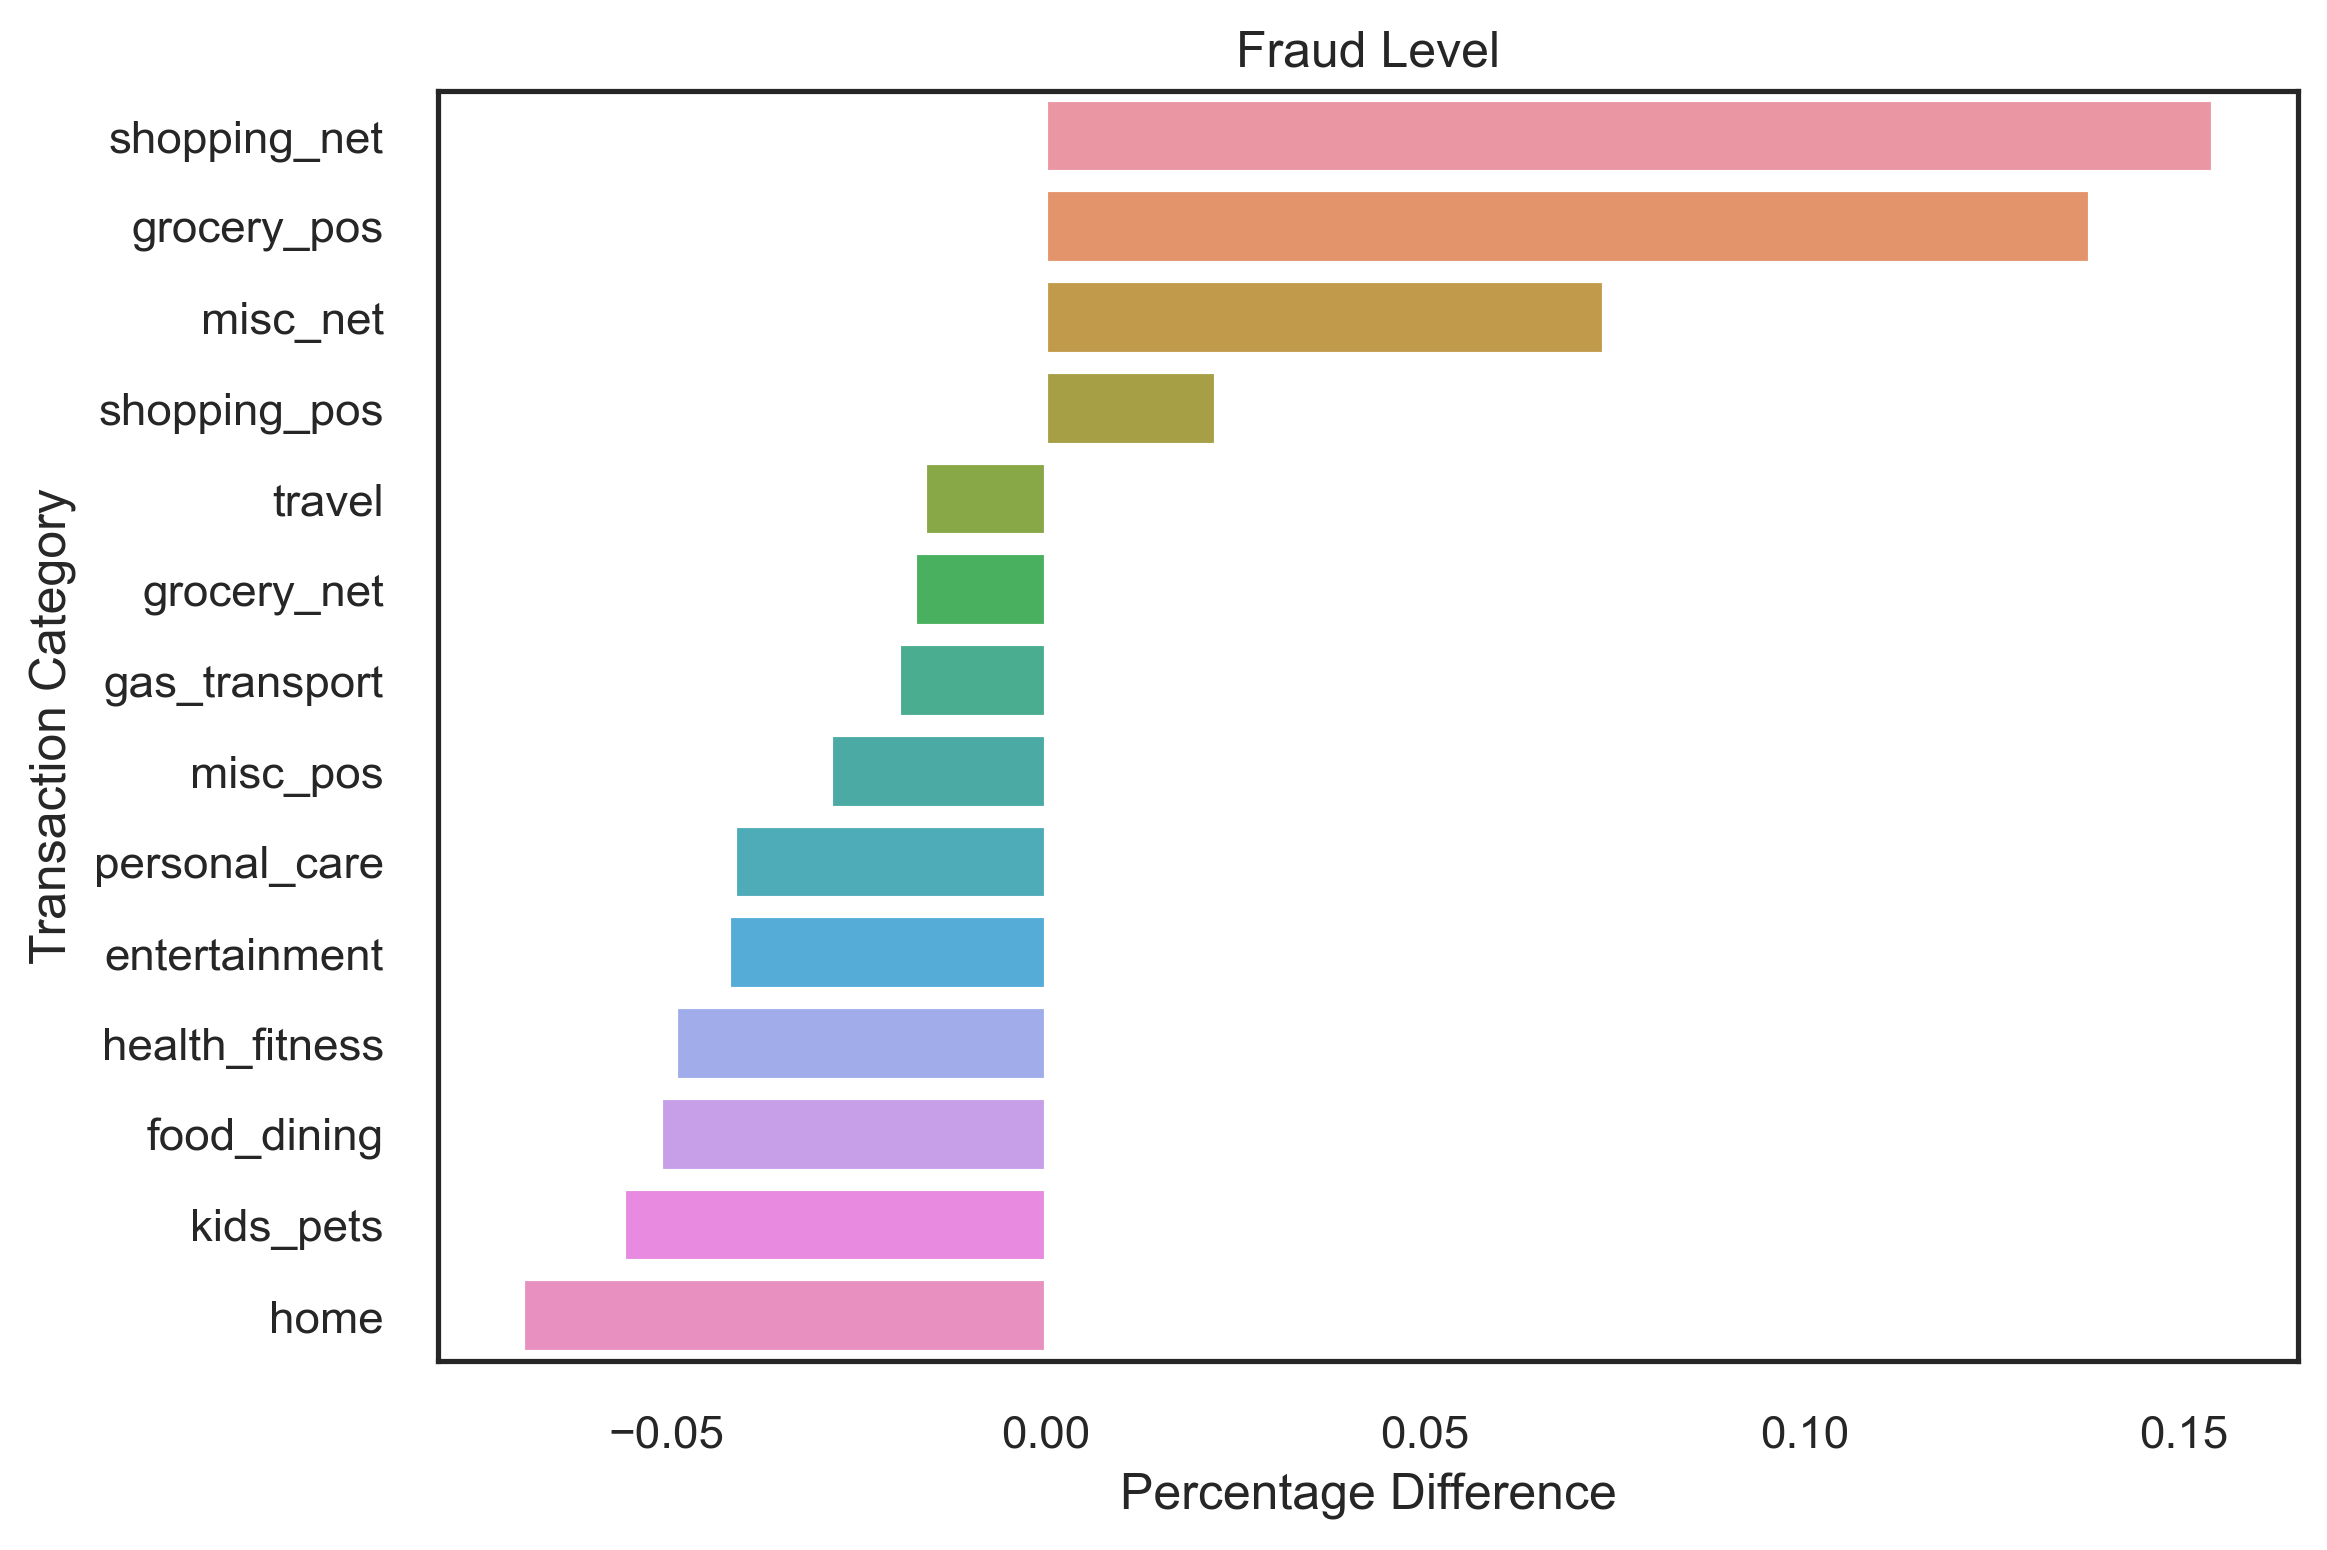

In [15]:
ax = sns.barplot(y='category', x='fraud_level',
                 data=non_fraud_vs_fraud.sort_values('fraud_level', ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Level');

As shown above, some categories are more propicious to have frauds than others.

Let's see how the Age distribution behaves for fraud and non-fraud transactions.

In [16]:
import pandas as pd
import seaborn as sns
import datetime as dt

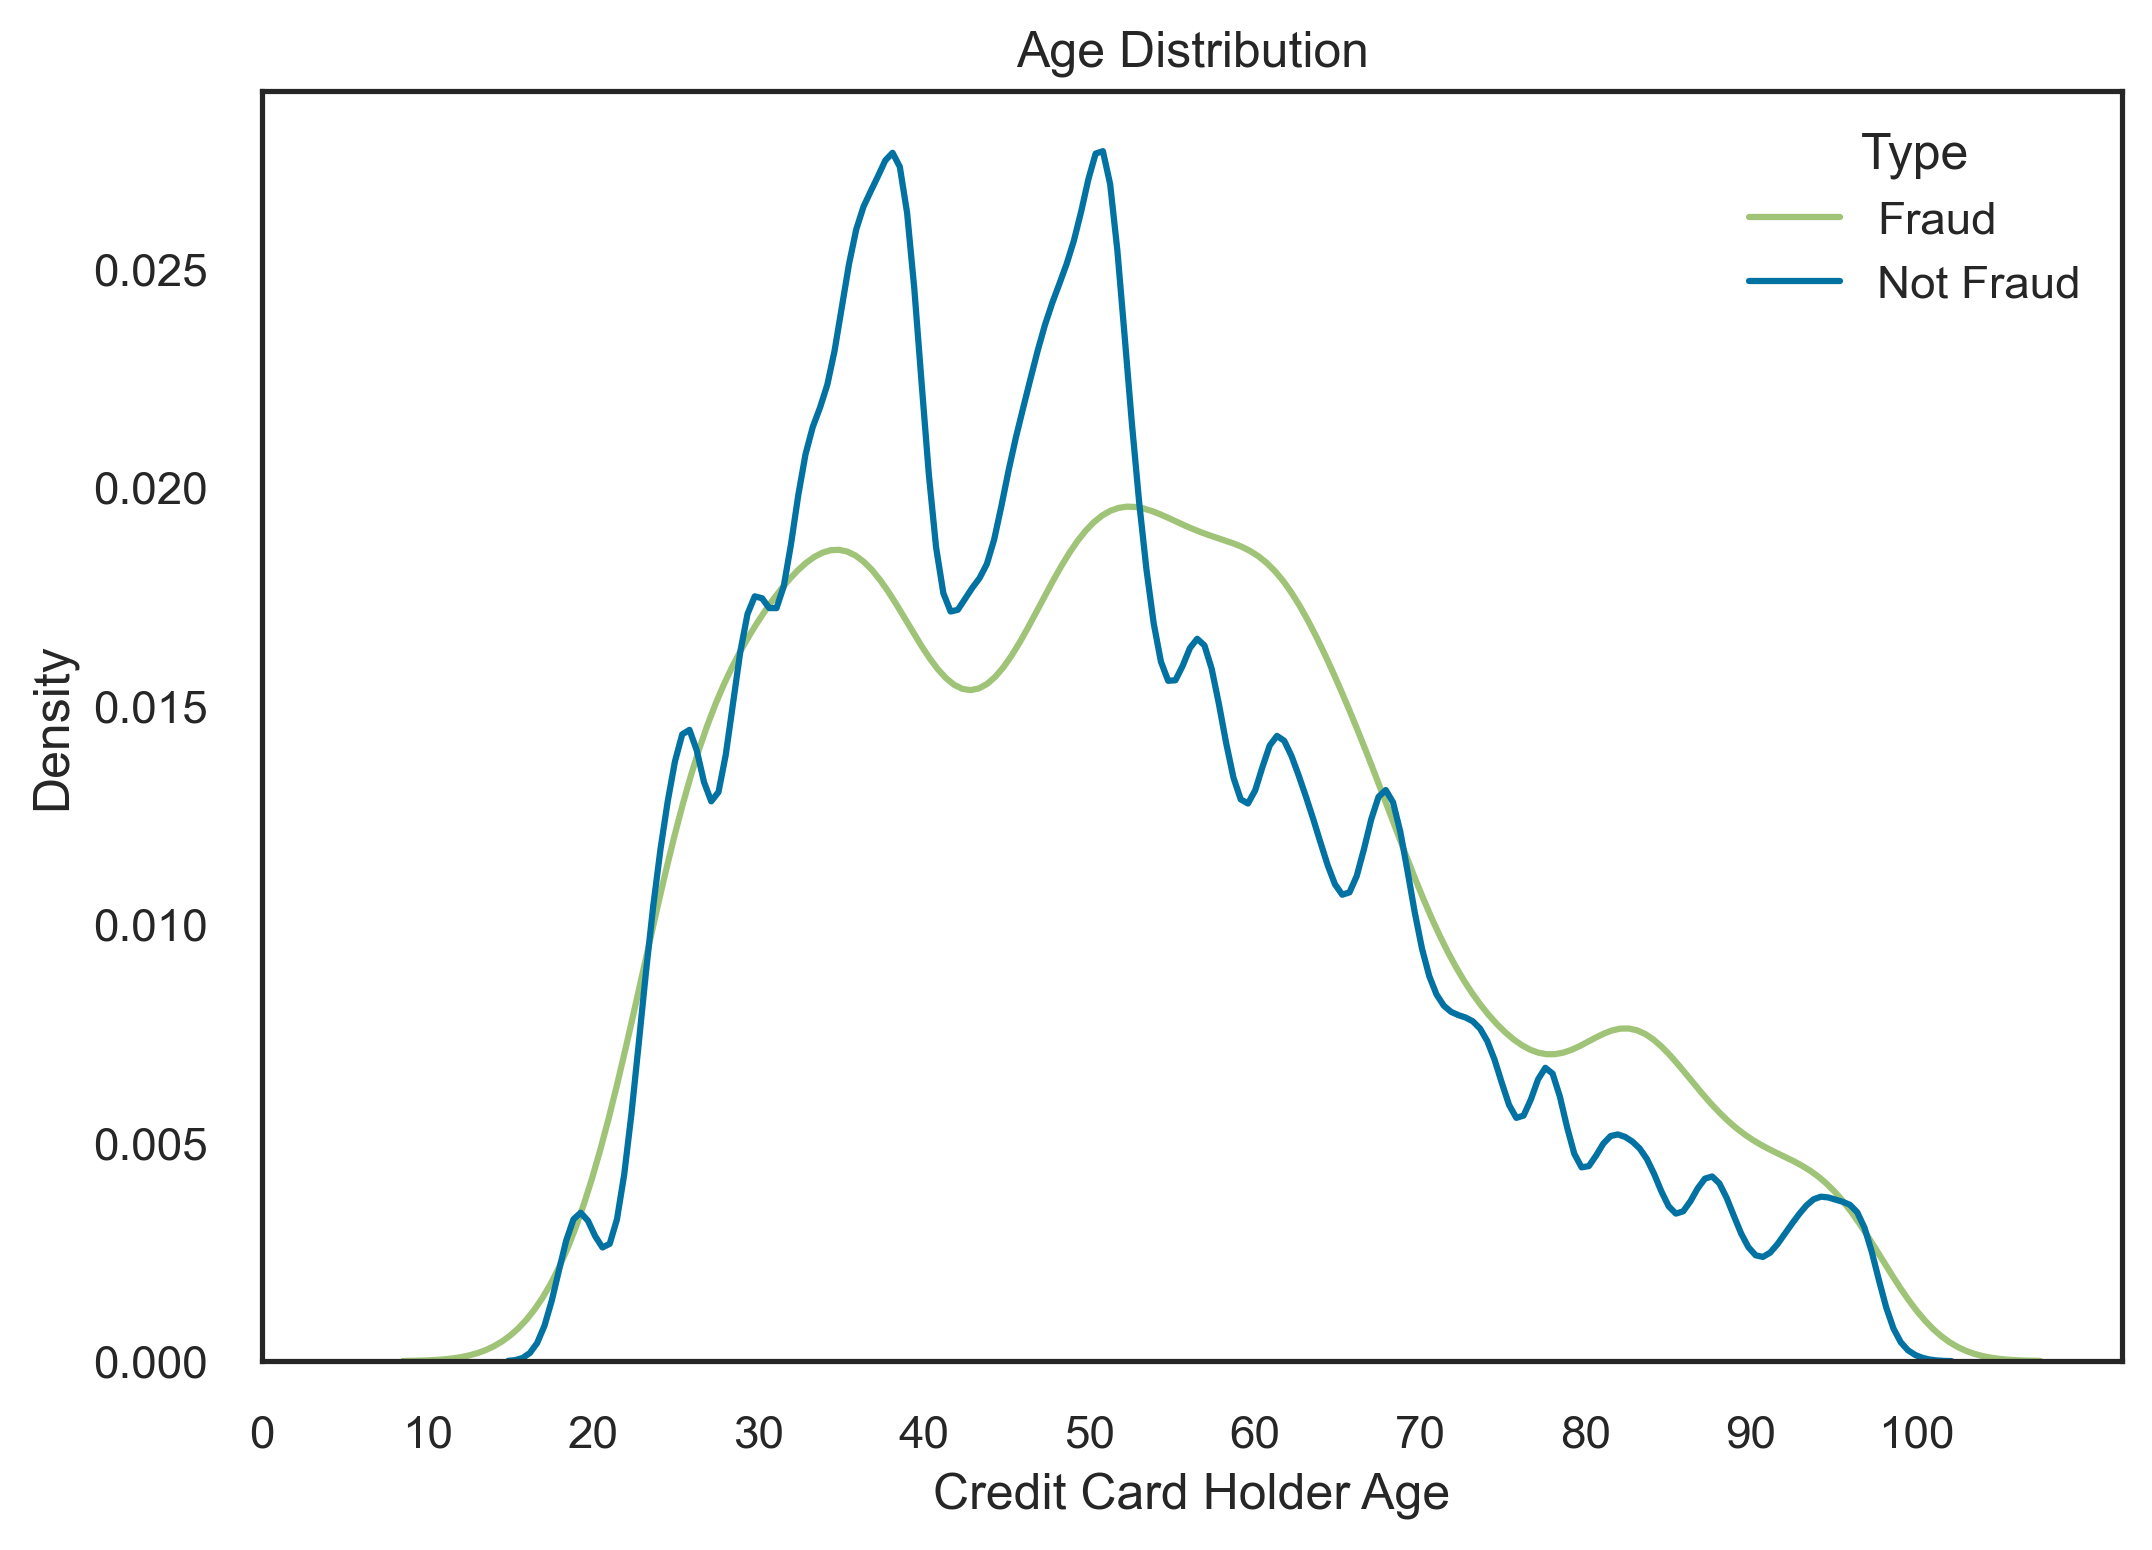

In [17]:
df_train['age'] = dt.date.today().year-pd.to_datetime(df_train['dob']).dt.year
ax = sns.kdeplot(x='age', data=df_train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

We can observe that in non-fraudulent transactions, there is a peak around 35 years and 40 years, and another one around 50 years. On the other hand, in fraudulent operations, we observe a smoother distribution, with peaks around 35 years and in the range of 50 years to 55 years.

Let's analyze if the time in a day has any impact.

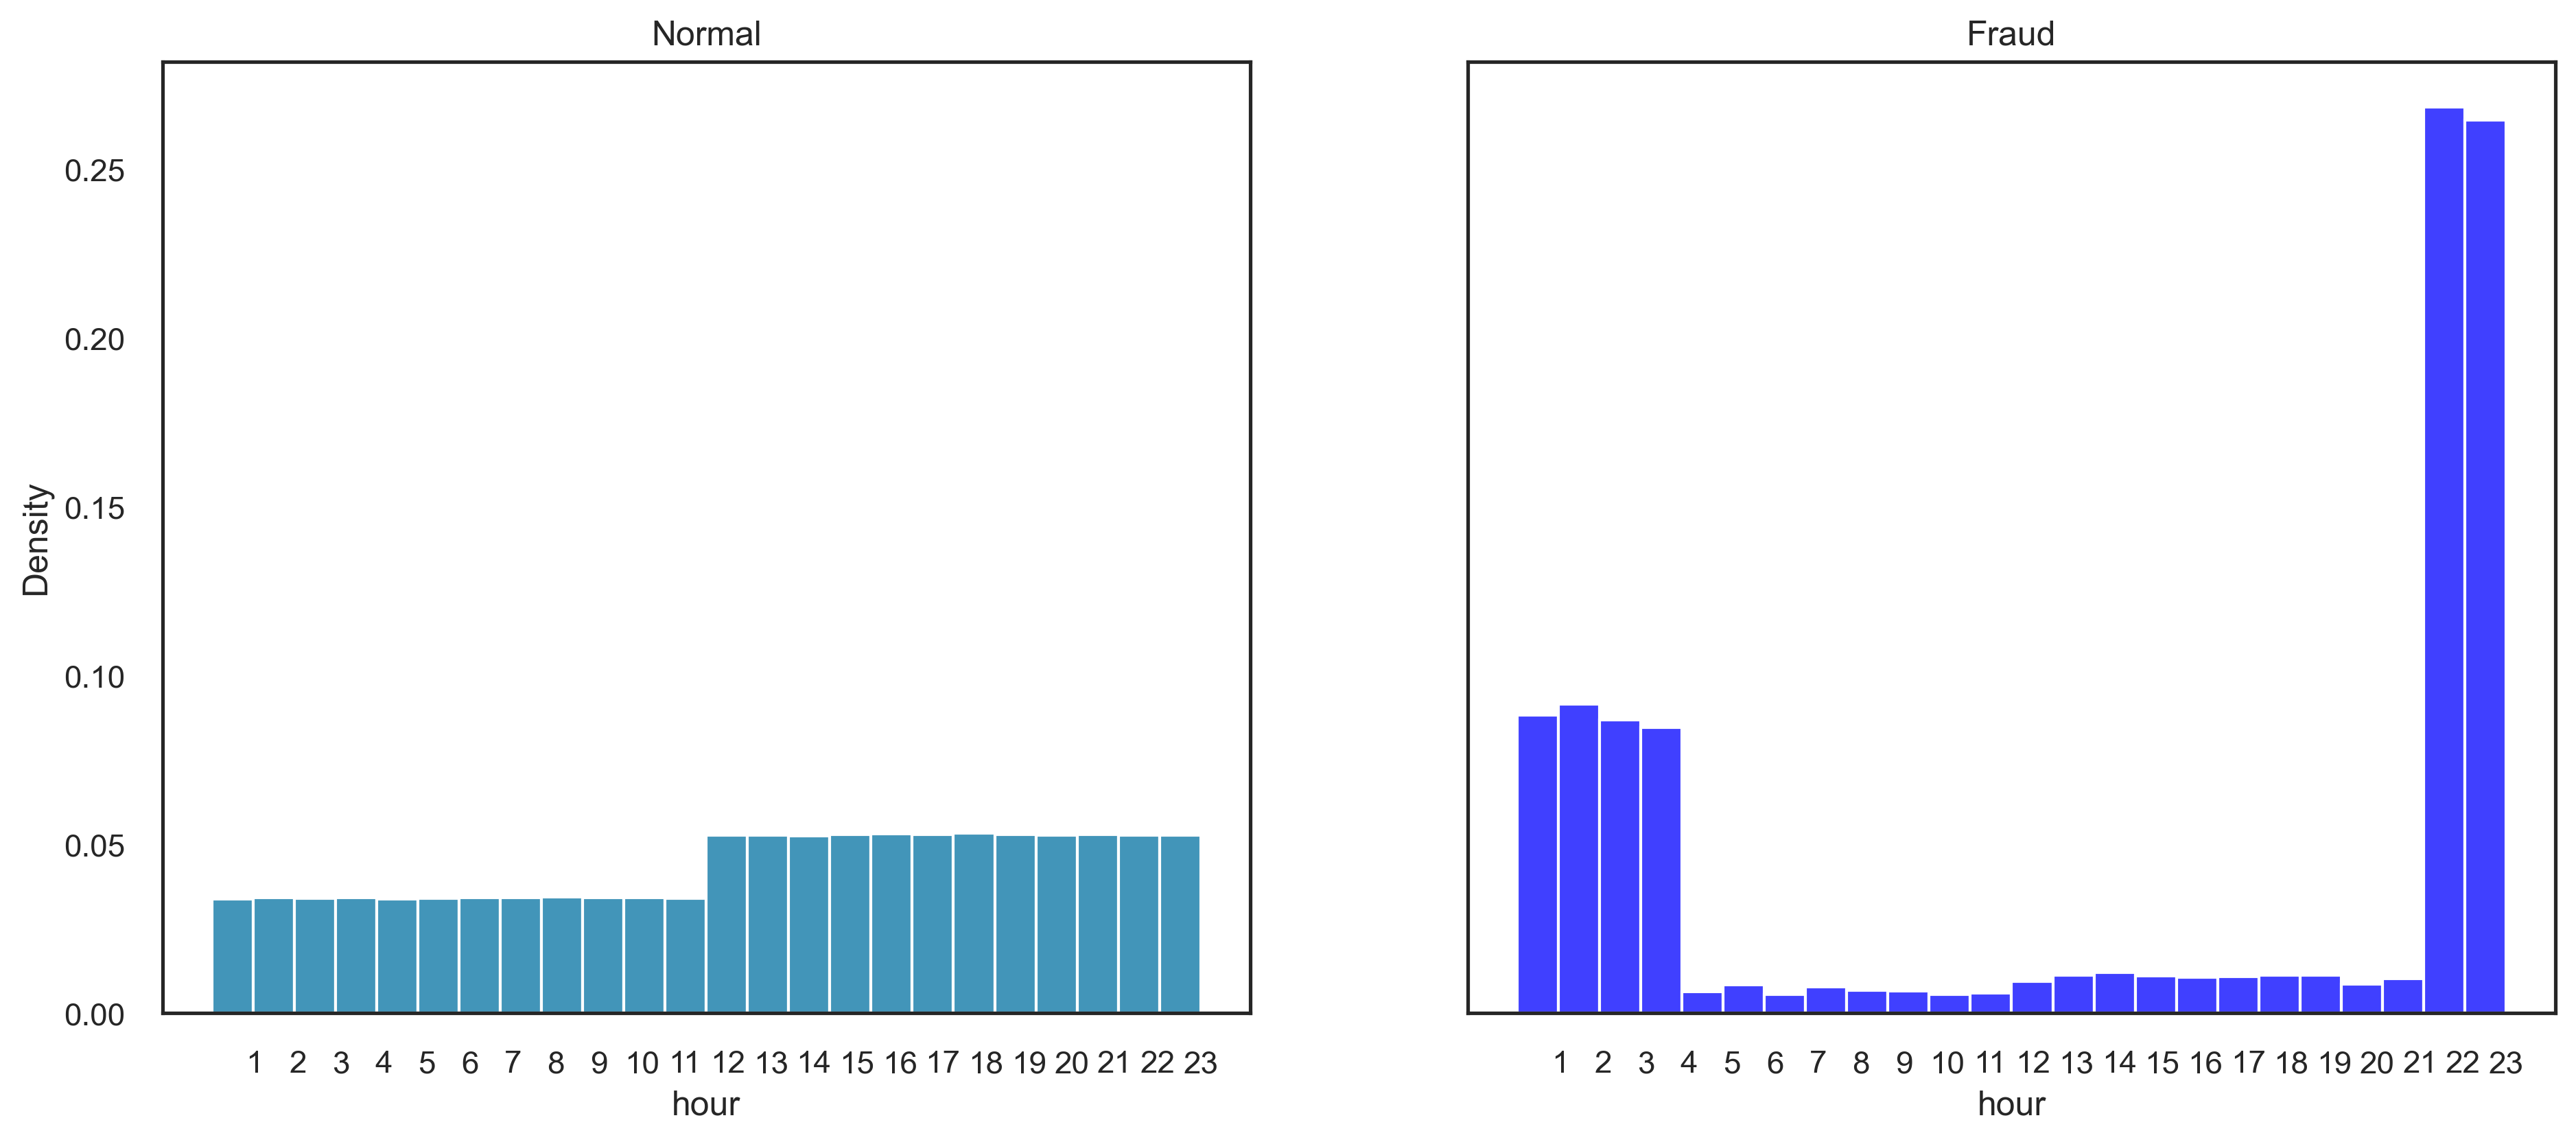

In [18]:
df_train['hour'] = pd.to_datetime(df_train['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=df_train[df_train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=df_train[df_train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

As we can see, there is a clear pattern when it comes to hour in the day. Fraudulent payments happens more frequently around midnight than in normal transactions.

Let's do the same for months!

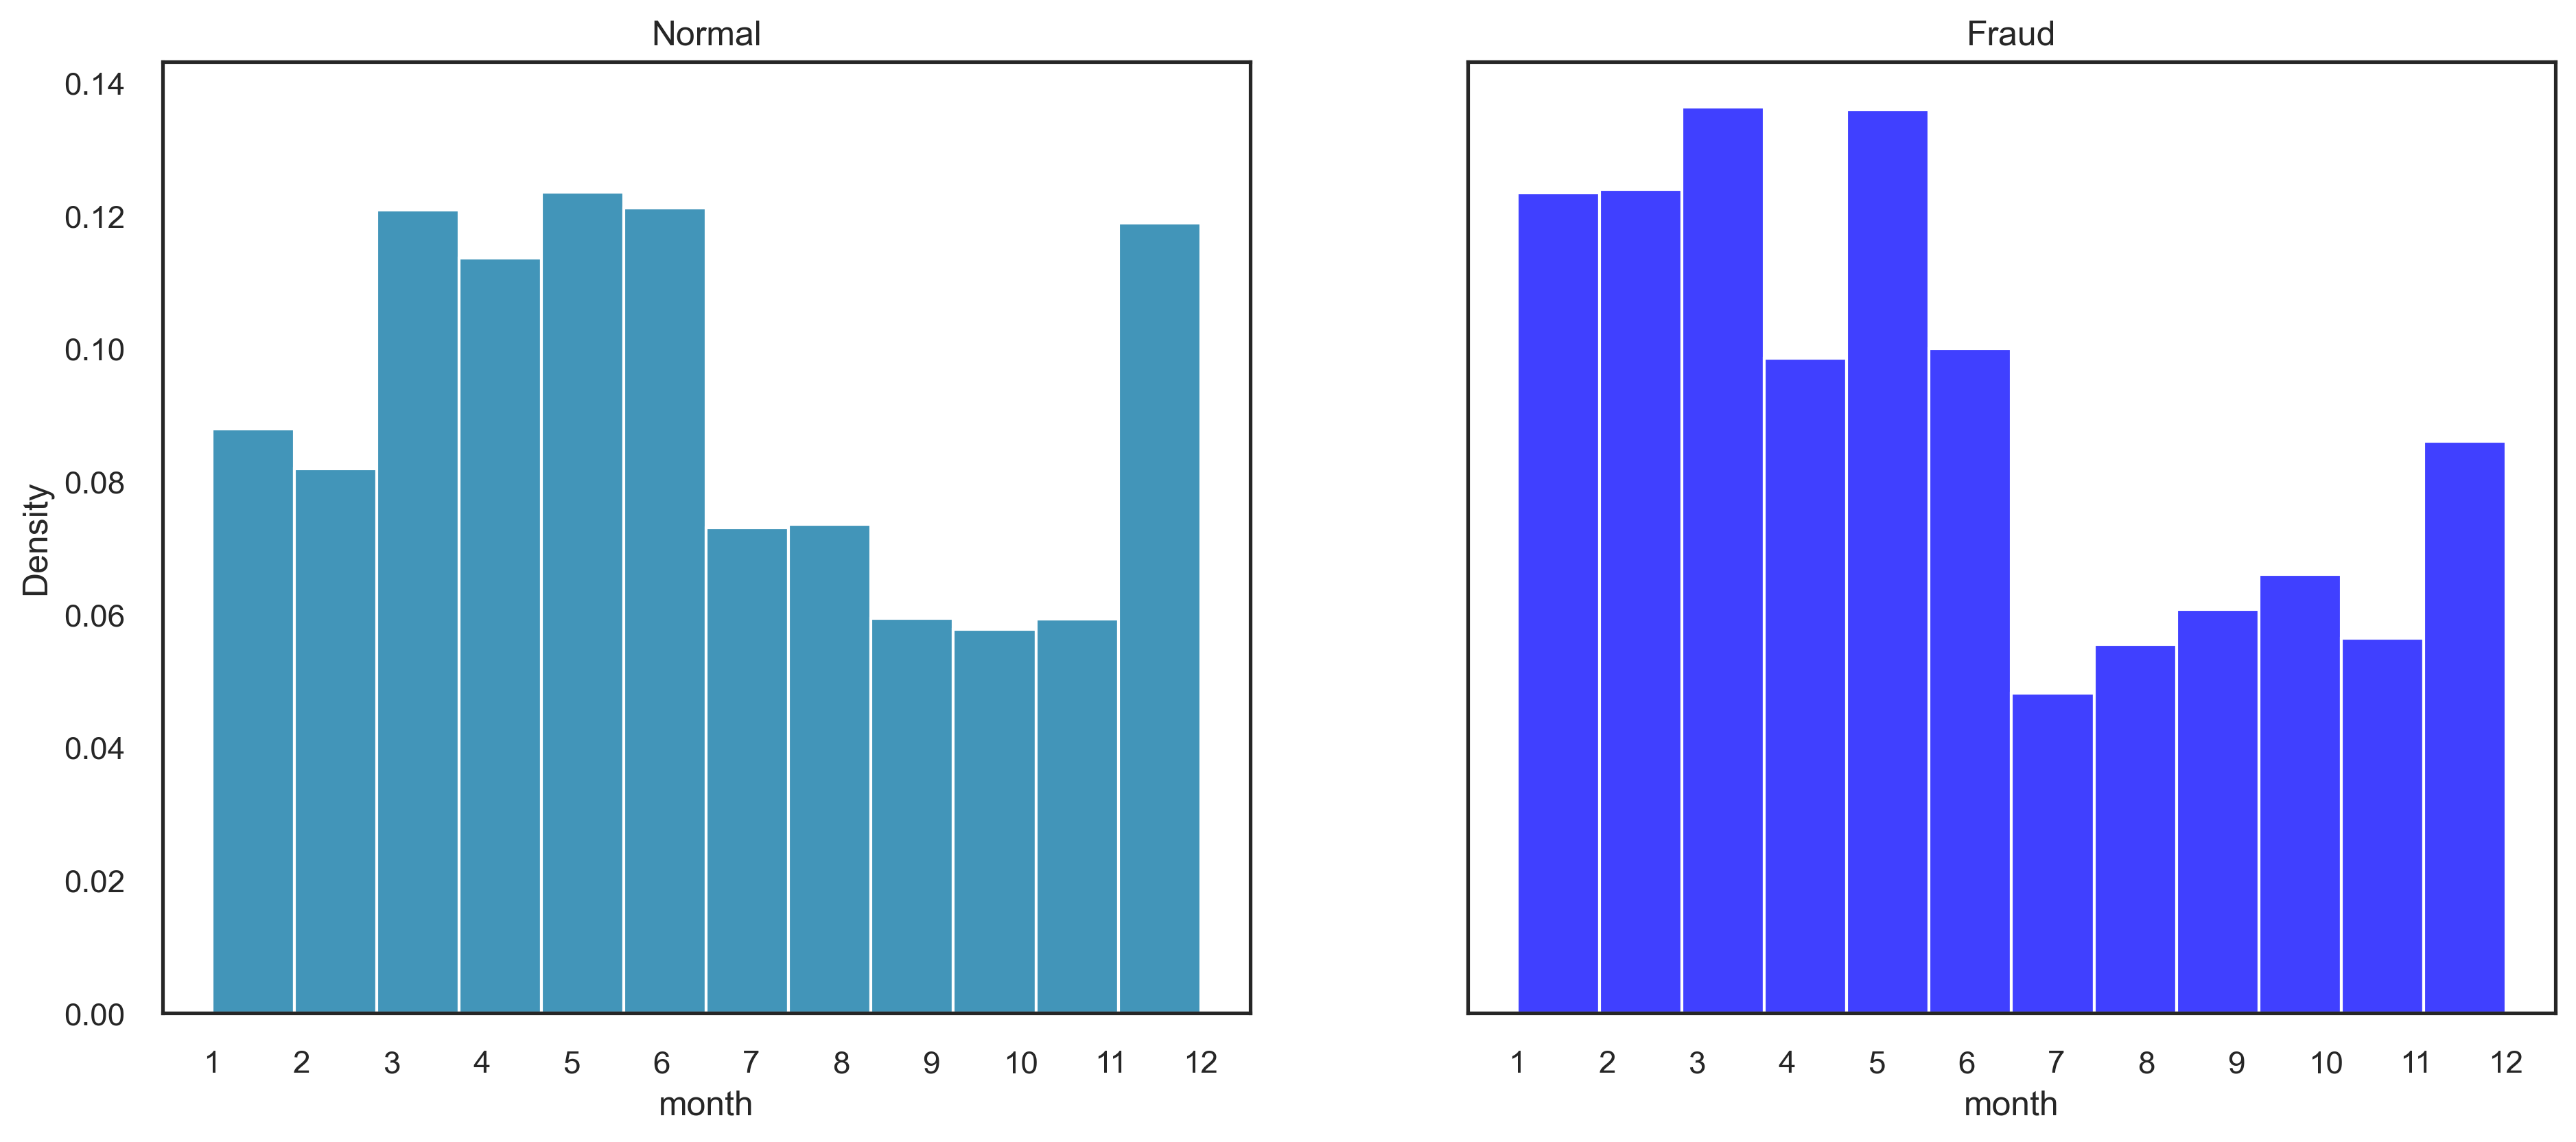

In [19]:
df_train['month'] = pd.to_datetime(df_train['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=df_train[df_train["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1)
ax2 = sns.histplot(x='month', data=df_train[df_train["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

# Why is 99% accuracy not good?

> As we saw above, this problem has a very imbalanced target class. We have only 0.6% of event occurrence. That means if we do a blind guess, by telling that every transaction is not fraud, we will still get a 99.4% accuracy!

> That happens because we will still be getting right all the transactions that are not fraud, which stands for 99.4% of the dataset.

> For that reason, it is very dangerous to look at only accuracy in a model. We have plenty of others good metrics to look at, besides accuracy.

> Some of them are: Precision, Recall, F1-score, ROC Curves and AUC!

# Feature Engineering

First, let's drop some columns that has duplicated or not useful information

In [20]:
df_train.drop(columns=["merchant", "first", "last", "street",
           "unix_time", "trans_num"], inplace=True)

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   gender                 1296675 non-null  object 
 5   city                   1296675 non-null  object 
 6   state                  1296675 non-null  object 
 7   zip                    1296675 non-null  int64  
 8   lat                    1296675 non-null  float64
 9   long                   1296675 non-null  float64
 10  city_pop               1296675 non-null  int64  
 11  job                    1296675 non-null  object 
 12  dob                    1296675 non-null  object 
 13  merch_lat              1296675 non-null  float64
 14  merch_long        

We saw that the "amt" category has very little spacing between small numbers and large spacing between high numbers. Because of that, we are going to use non logarithm scaling, that increases the distance between small values and reduces de spacing between large ones.

### Scaling

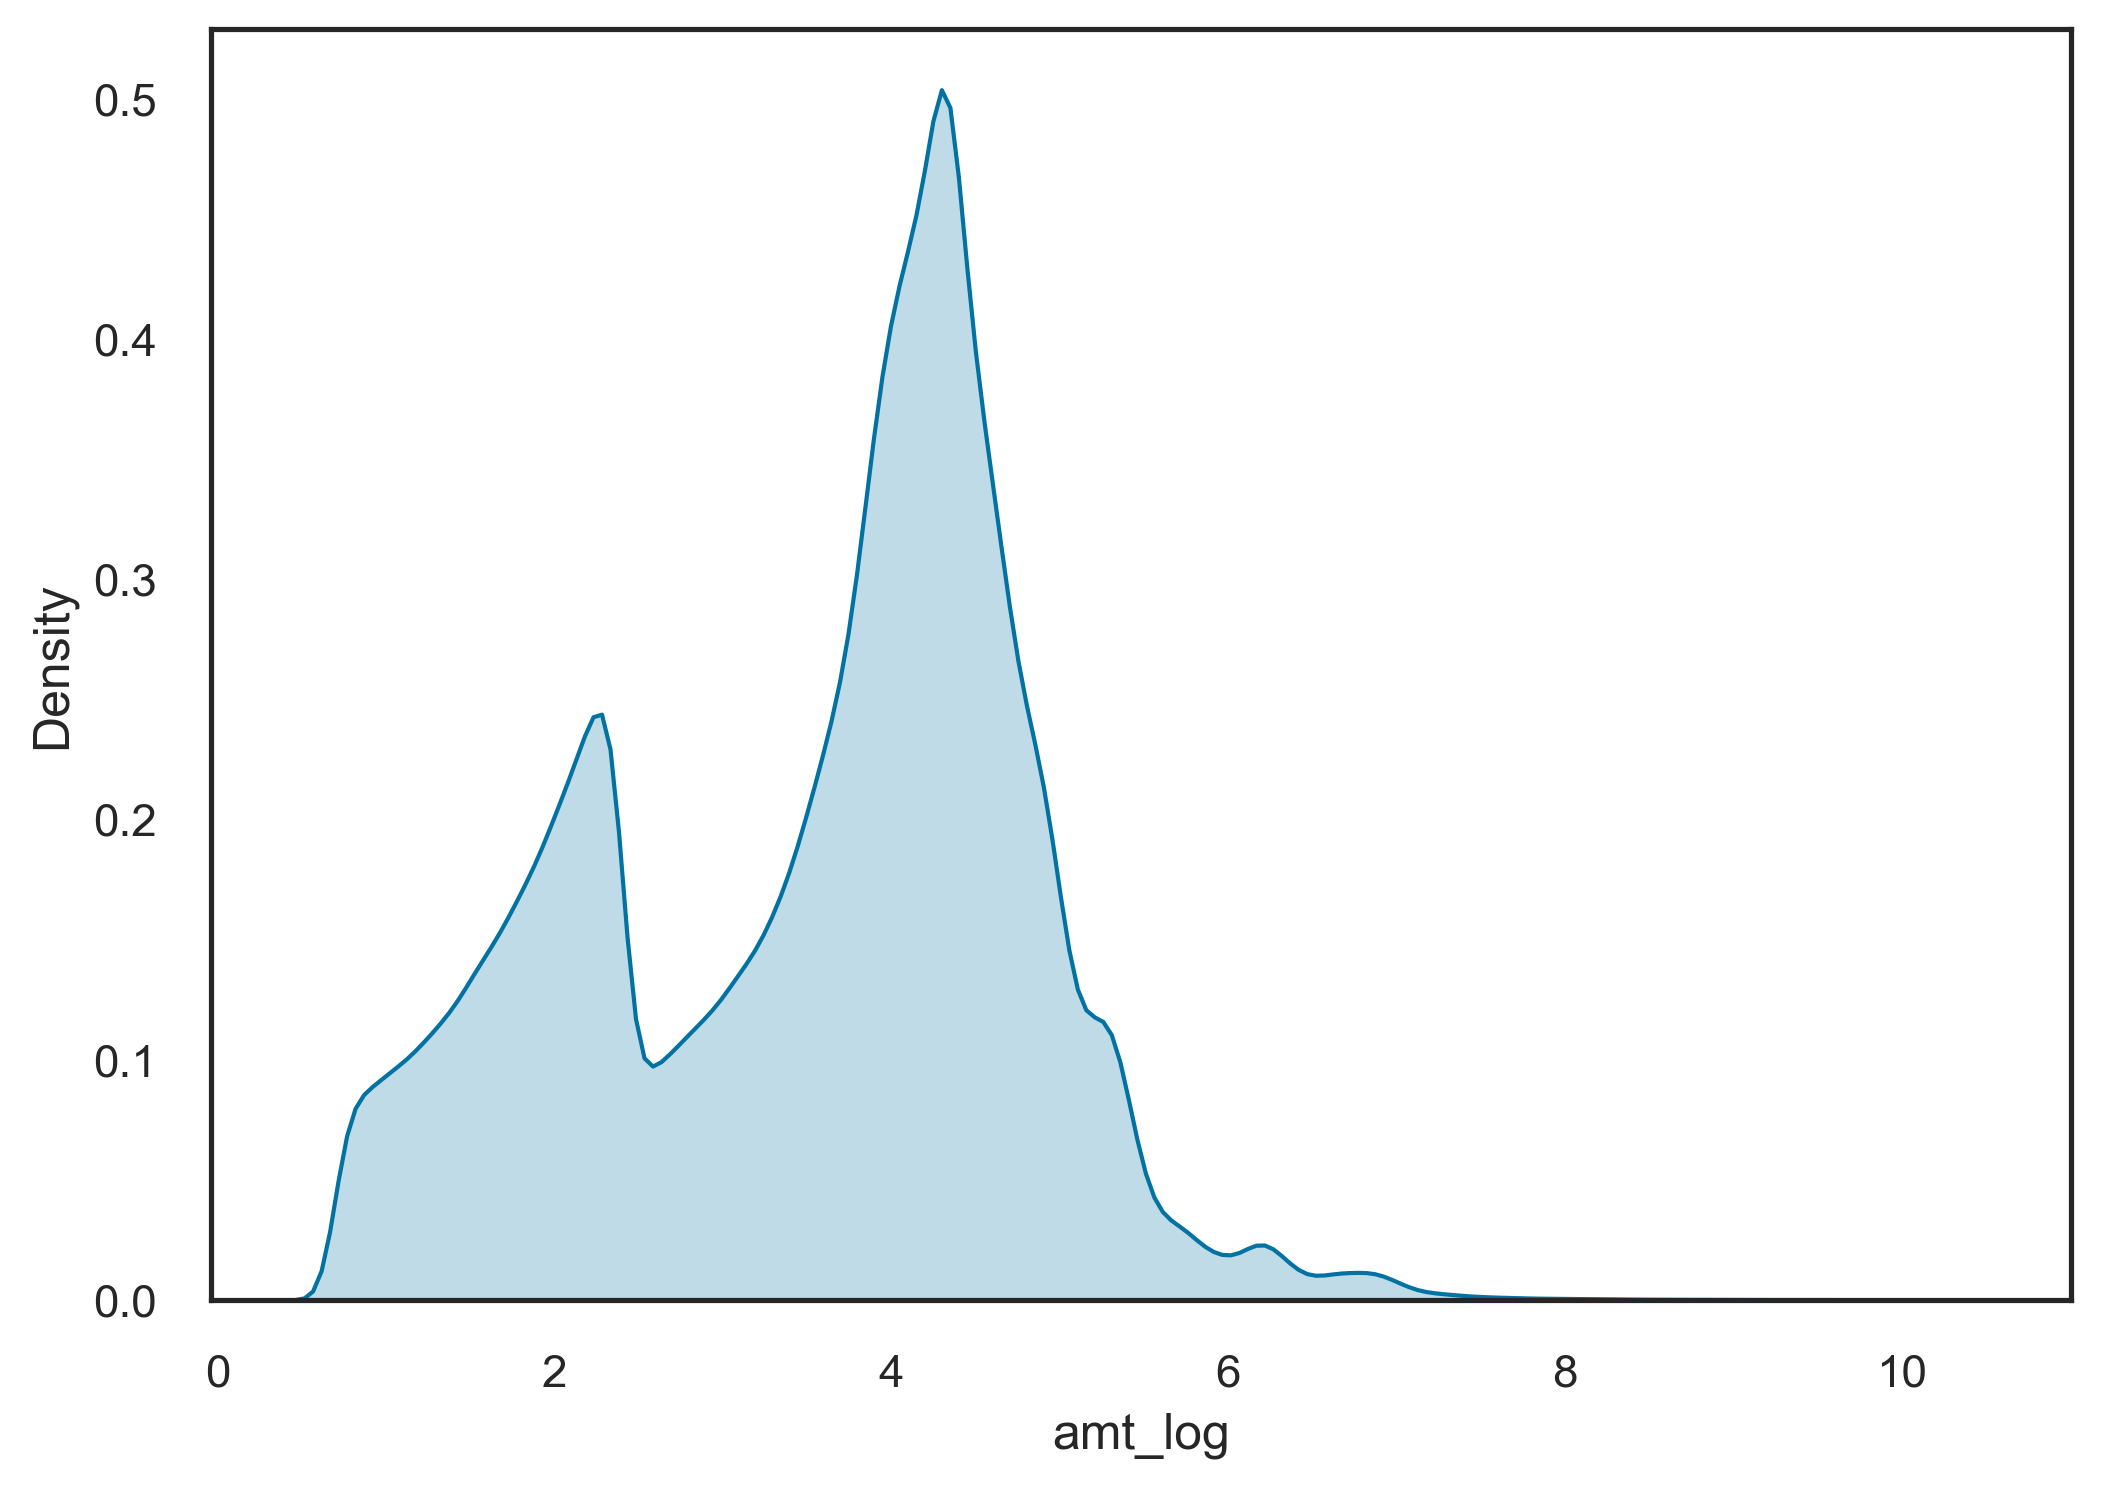

In [22]:
df_train["amt_log"] = np.log1p(df_train["amt"])
sns.kdeplot(df_train["amt_log"], fill=True);

Let's check the normality of the "amt" feature compared to its transformation "amt_log".

In [23]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [24]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(df_train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = df_train[feature].mean()
    std = df_train[feature].std()
    skew = df_train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 70.35, std: 160.32, skew: 42.28


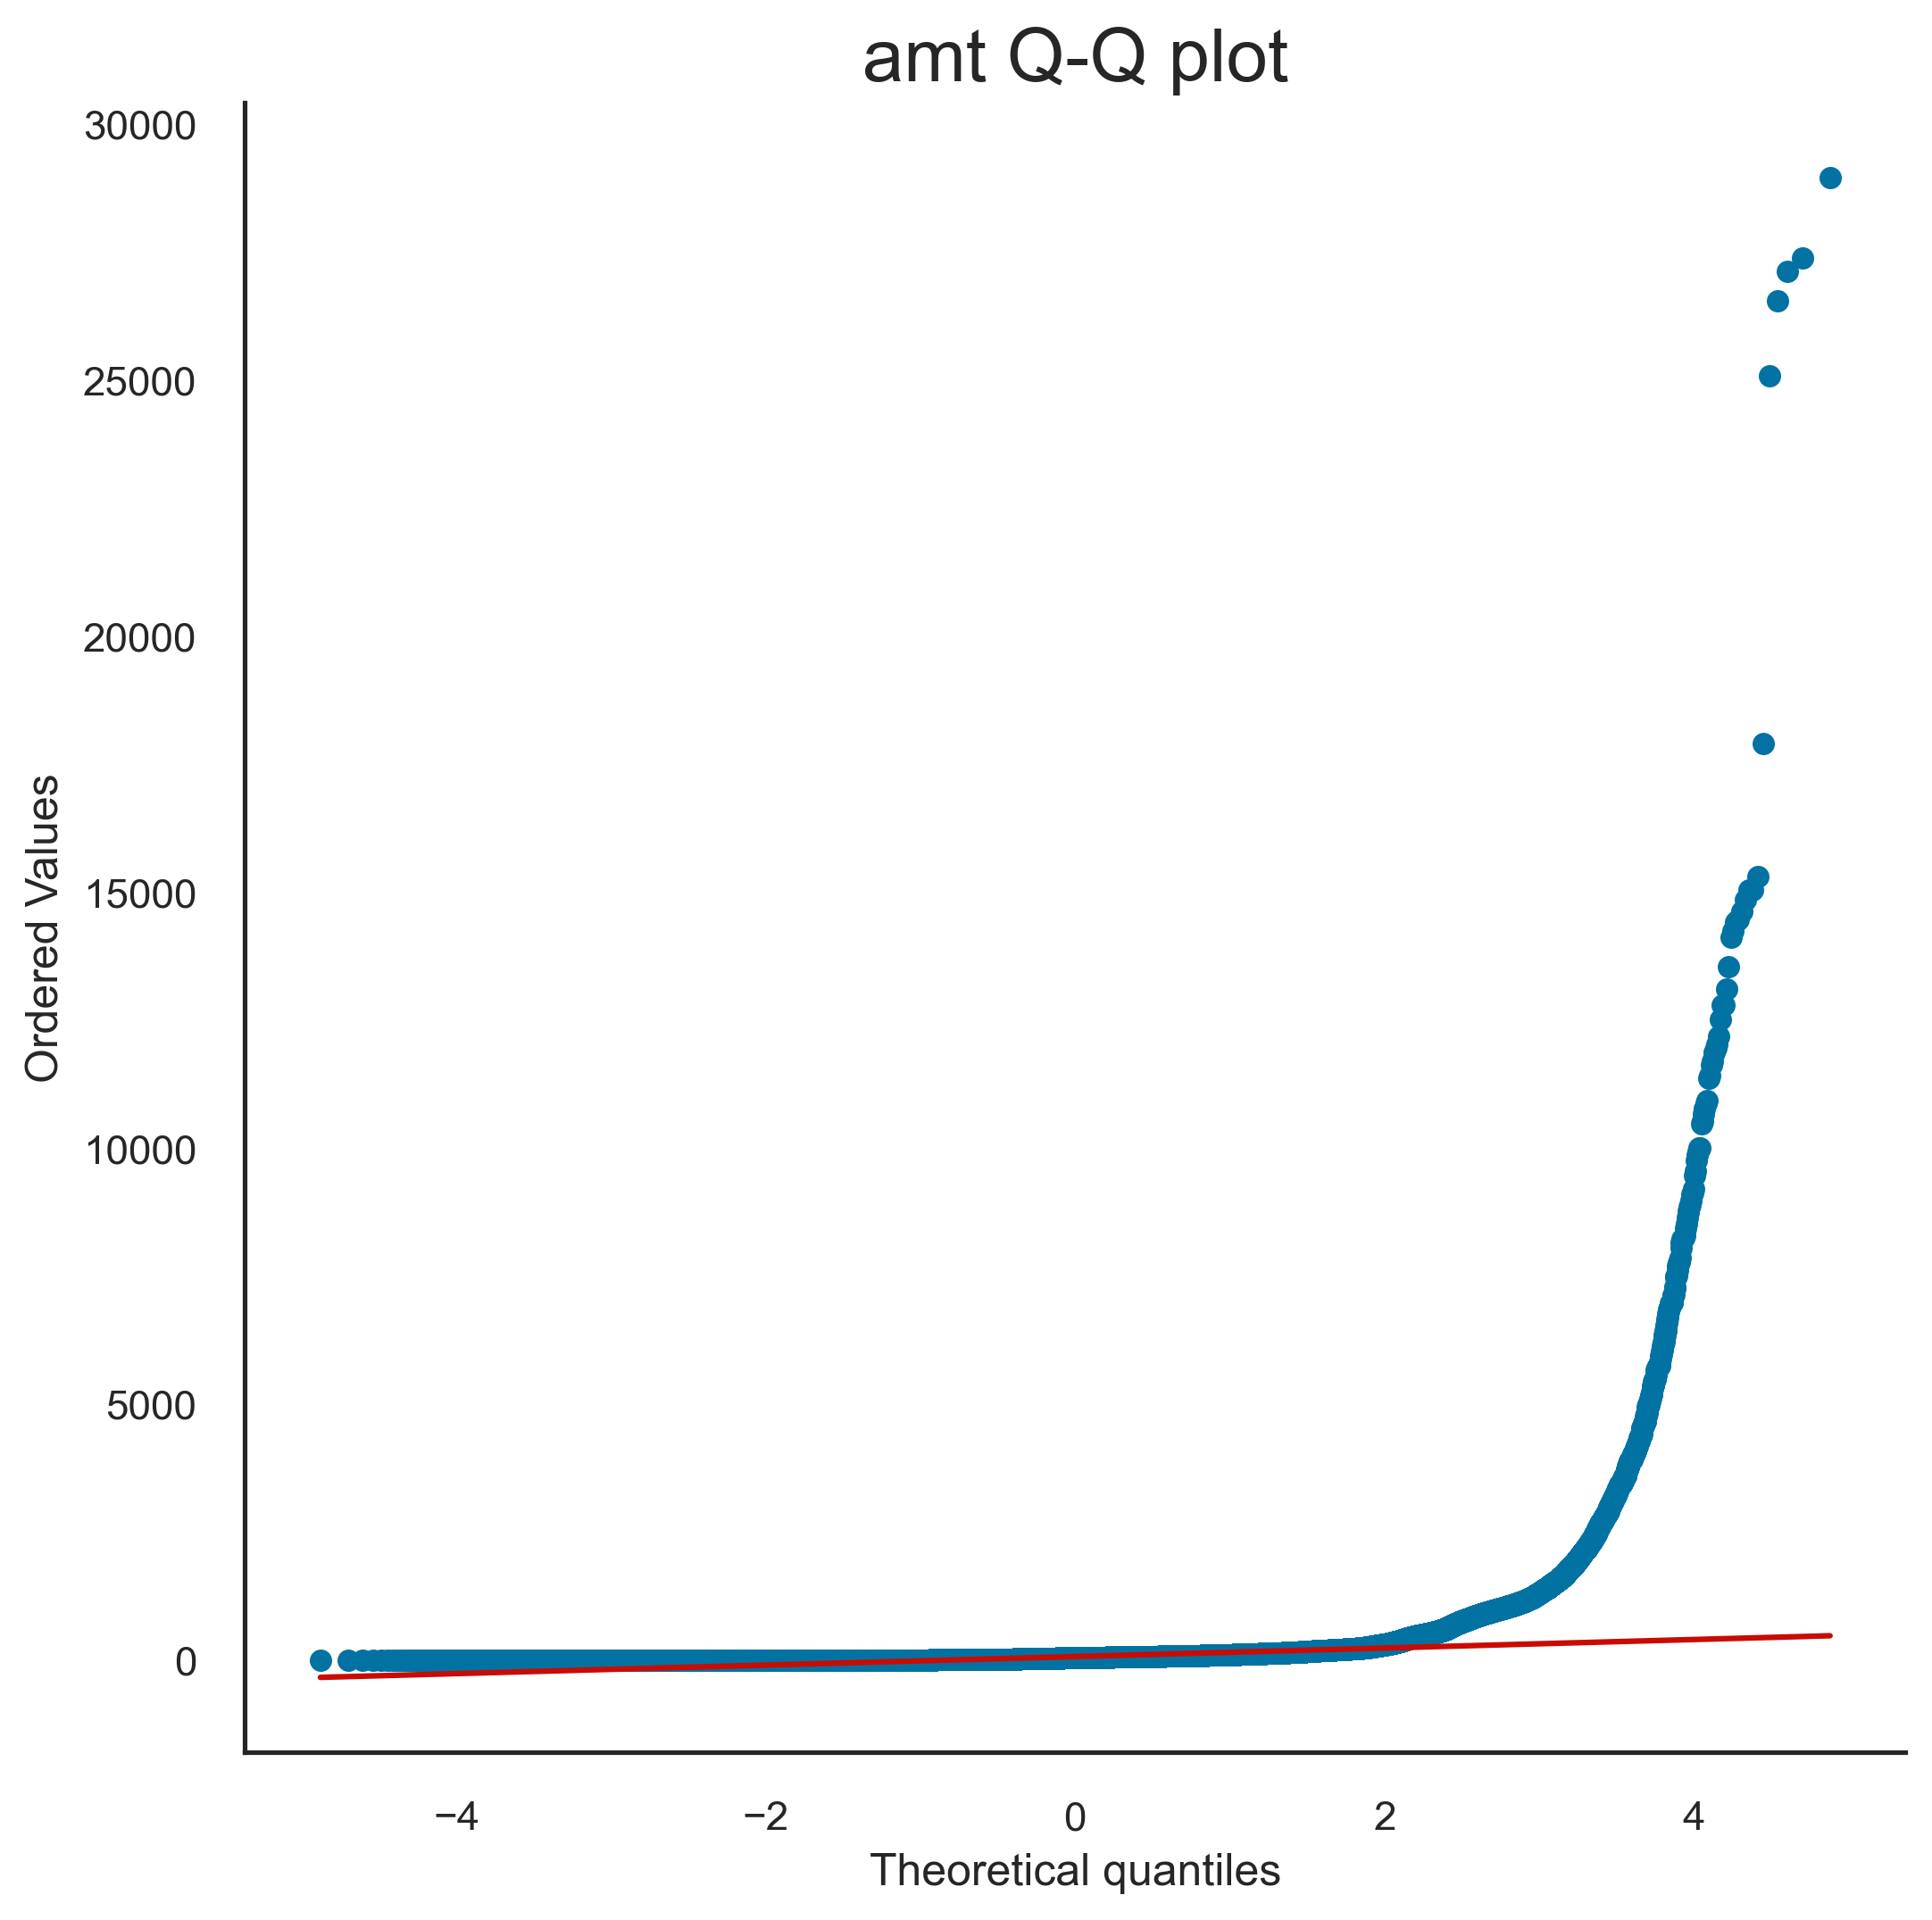

In [25]:
check_normality("amt");

amt_log : mean: 3.53, std: 1.29, skew: -0.30


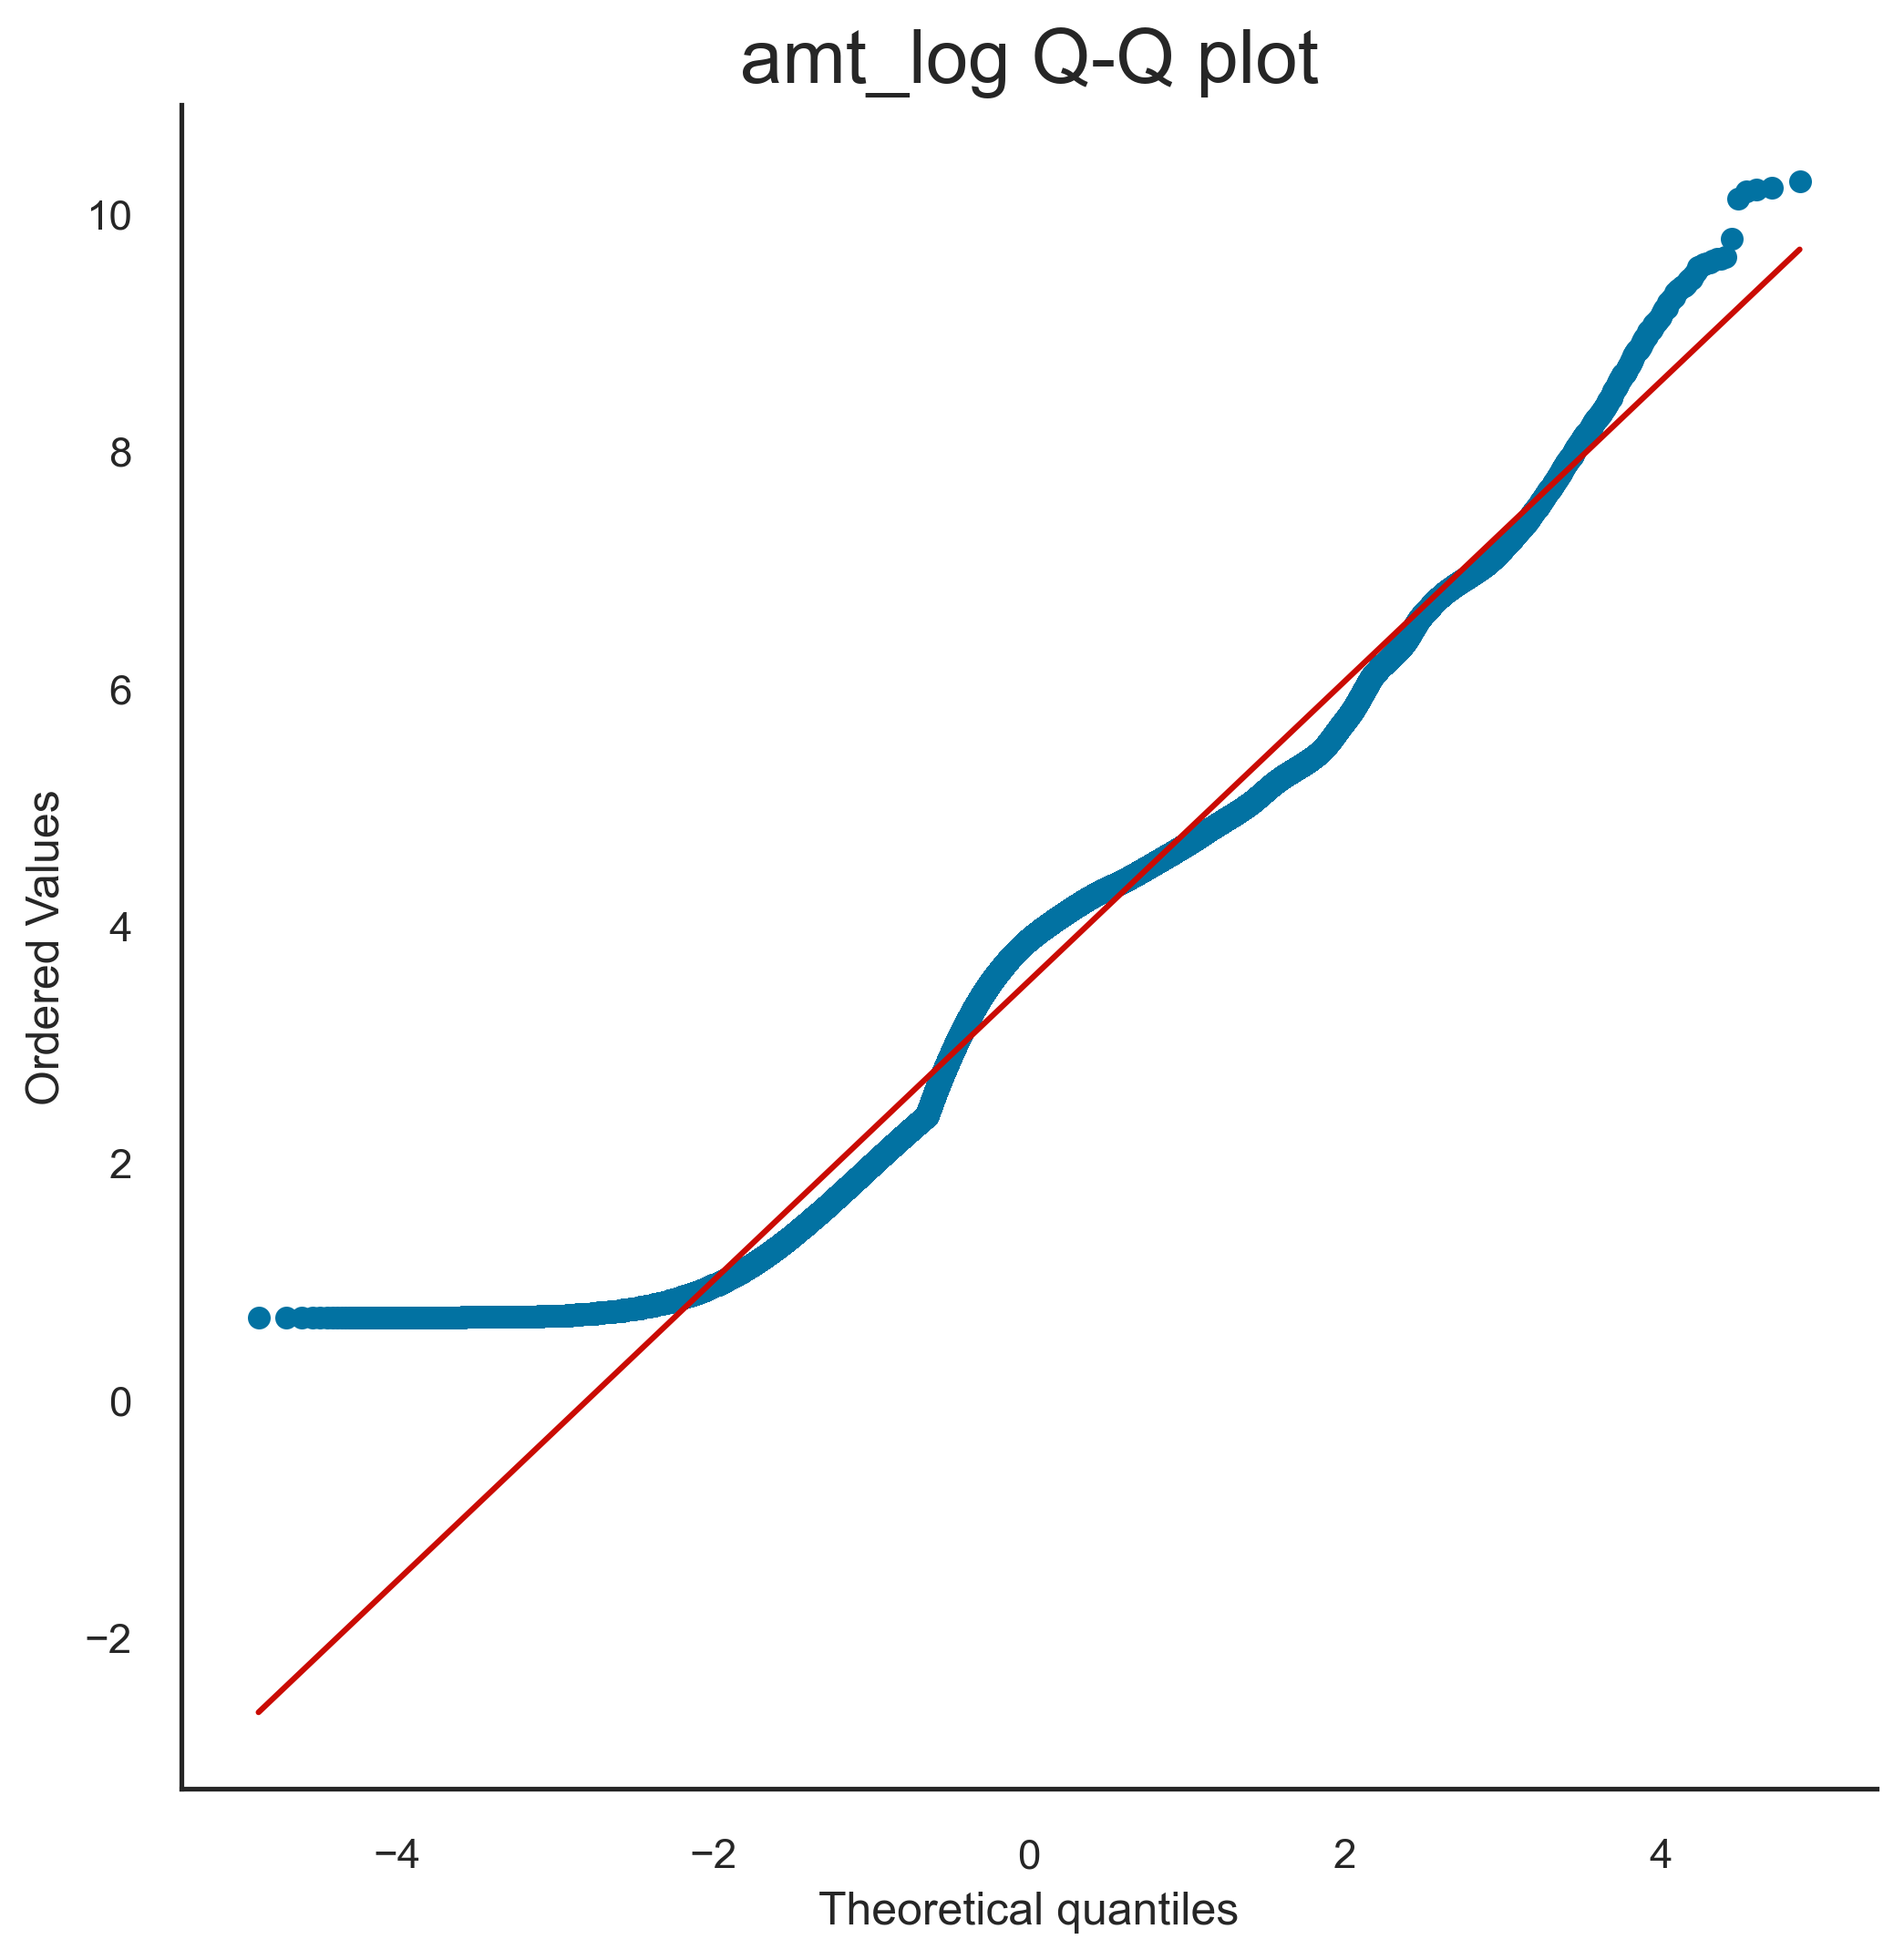

In [26]:
check_normality("amt_log");

We can see that with the logarithm scaling, the skewness has improved a lot.

### Categorical Encoding

Since we have a binary target and categorical variables with high cardinality, we are going to use the WOE (Weight of Evidence) encoder for the features: category, state, city and job.

In [27]:
import category_encoders as ce


In [28]:
def apply_woe(train, columns, target_col):
    woe = ce.WOEEncoder()

    for col in columns:
        X = df_train[col]
        y = df_train[target_col]

        new_col_name = f"{col}_WOE"
        df_train[new_col_name] = woe.fit_transform(X, y)

    return df_train


columns_to_encode = ["category", "state", "city", "job"]
target_column = "is_fraud"

df_train = apply_woe(df_train, columns_to_encode, target_column)

As for gender category, we can simply encode it by using dummies.

In [29]:
gender_mapping = {"F": 0, "M": 1}

df_train["gender_binary"] = df_train["gender"].map(gender_mapping)

We can encode the cc_num (credit card number) variable as well, by counting their frequencies in the database and them dividing them into classes, so we can classify the cards that are used a lot, and the ones that are not used often in the database.

In [30]:
freq_enc = (df_train.groupby("cc_num").size())
freq_enc.sort_values(ascending=True)
df_train["cc_num_frequency"] = df_train["cc_num"].apply(lambda x: freq_enc[x])

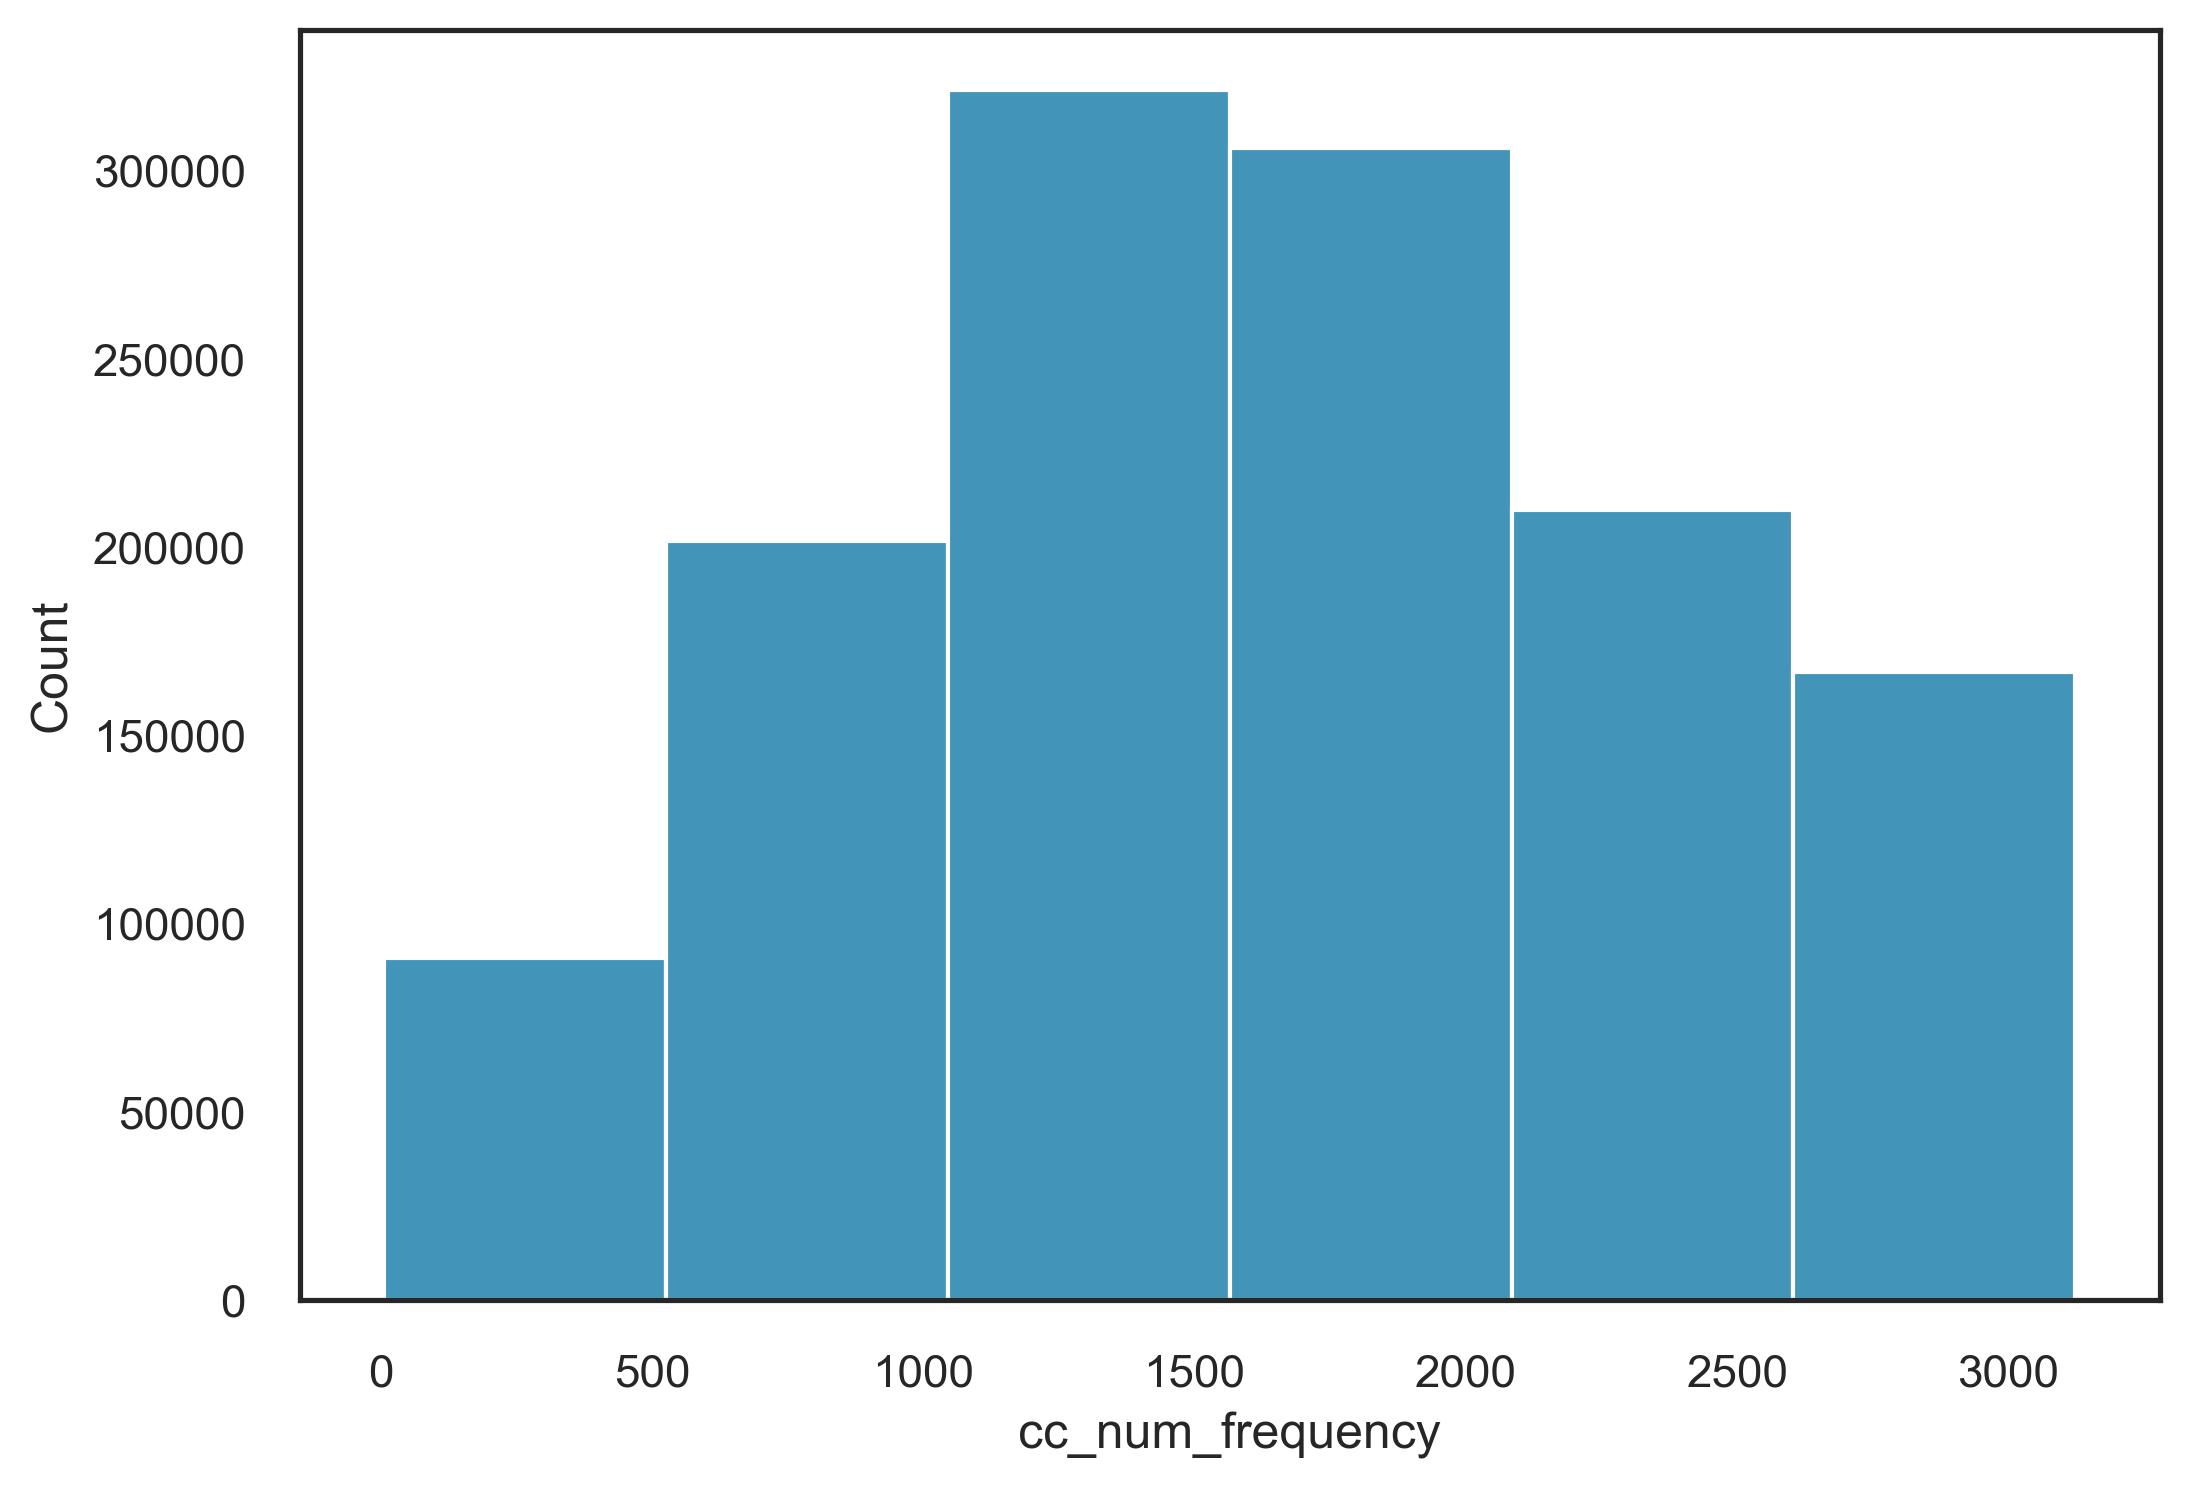

In [31]:
sns.histplot(df_train["cc_num_frequency"], bins=6);

In [32]:
intervals = [600, 1200, 1800, 2400, 3000, 3600]


def classify_frequency(freq):
    for i, c in enumerate(intervals):
        if freq <= c:
            return i


df_train["cc_num_frequency_classification"] = df_train["cc_num_frequency"].apply(
    classify_frequency)

Let's see if the distributions are different among the frequency classes for fraudulent and non-fraudulent transactions.

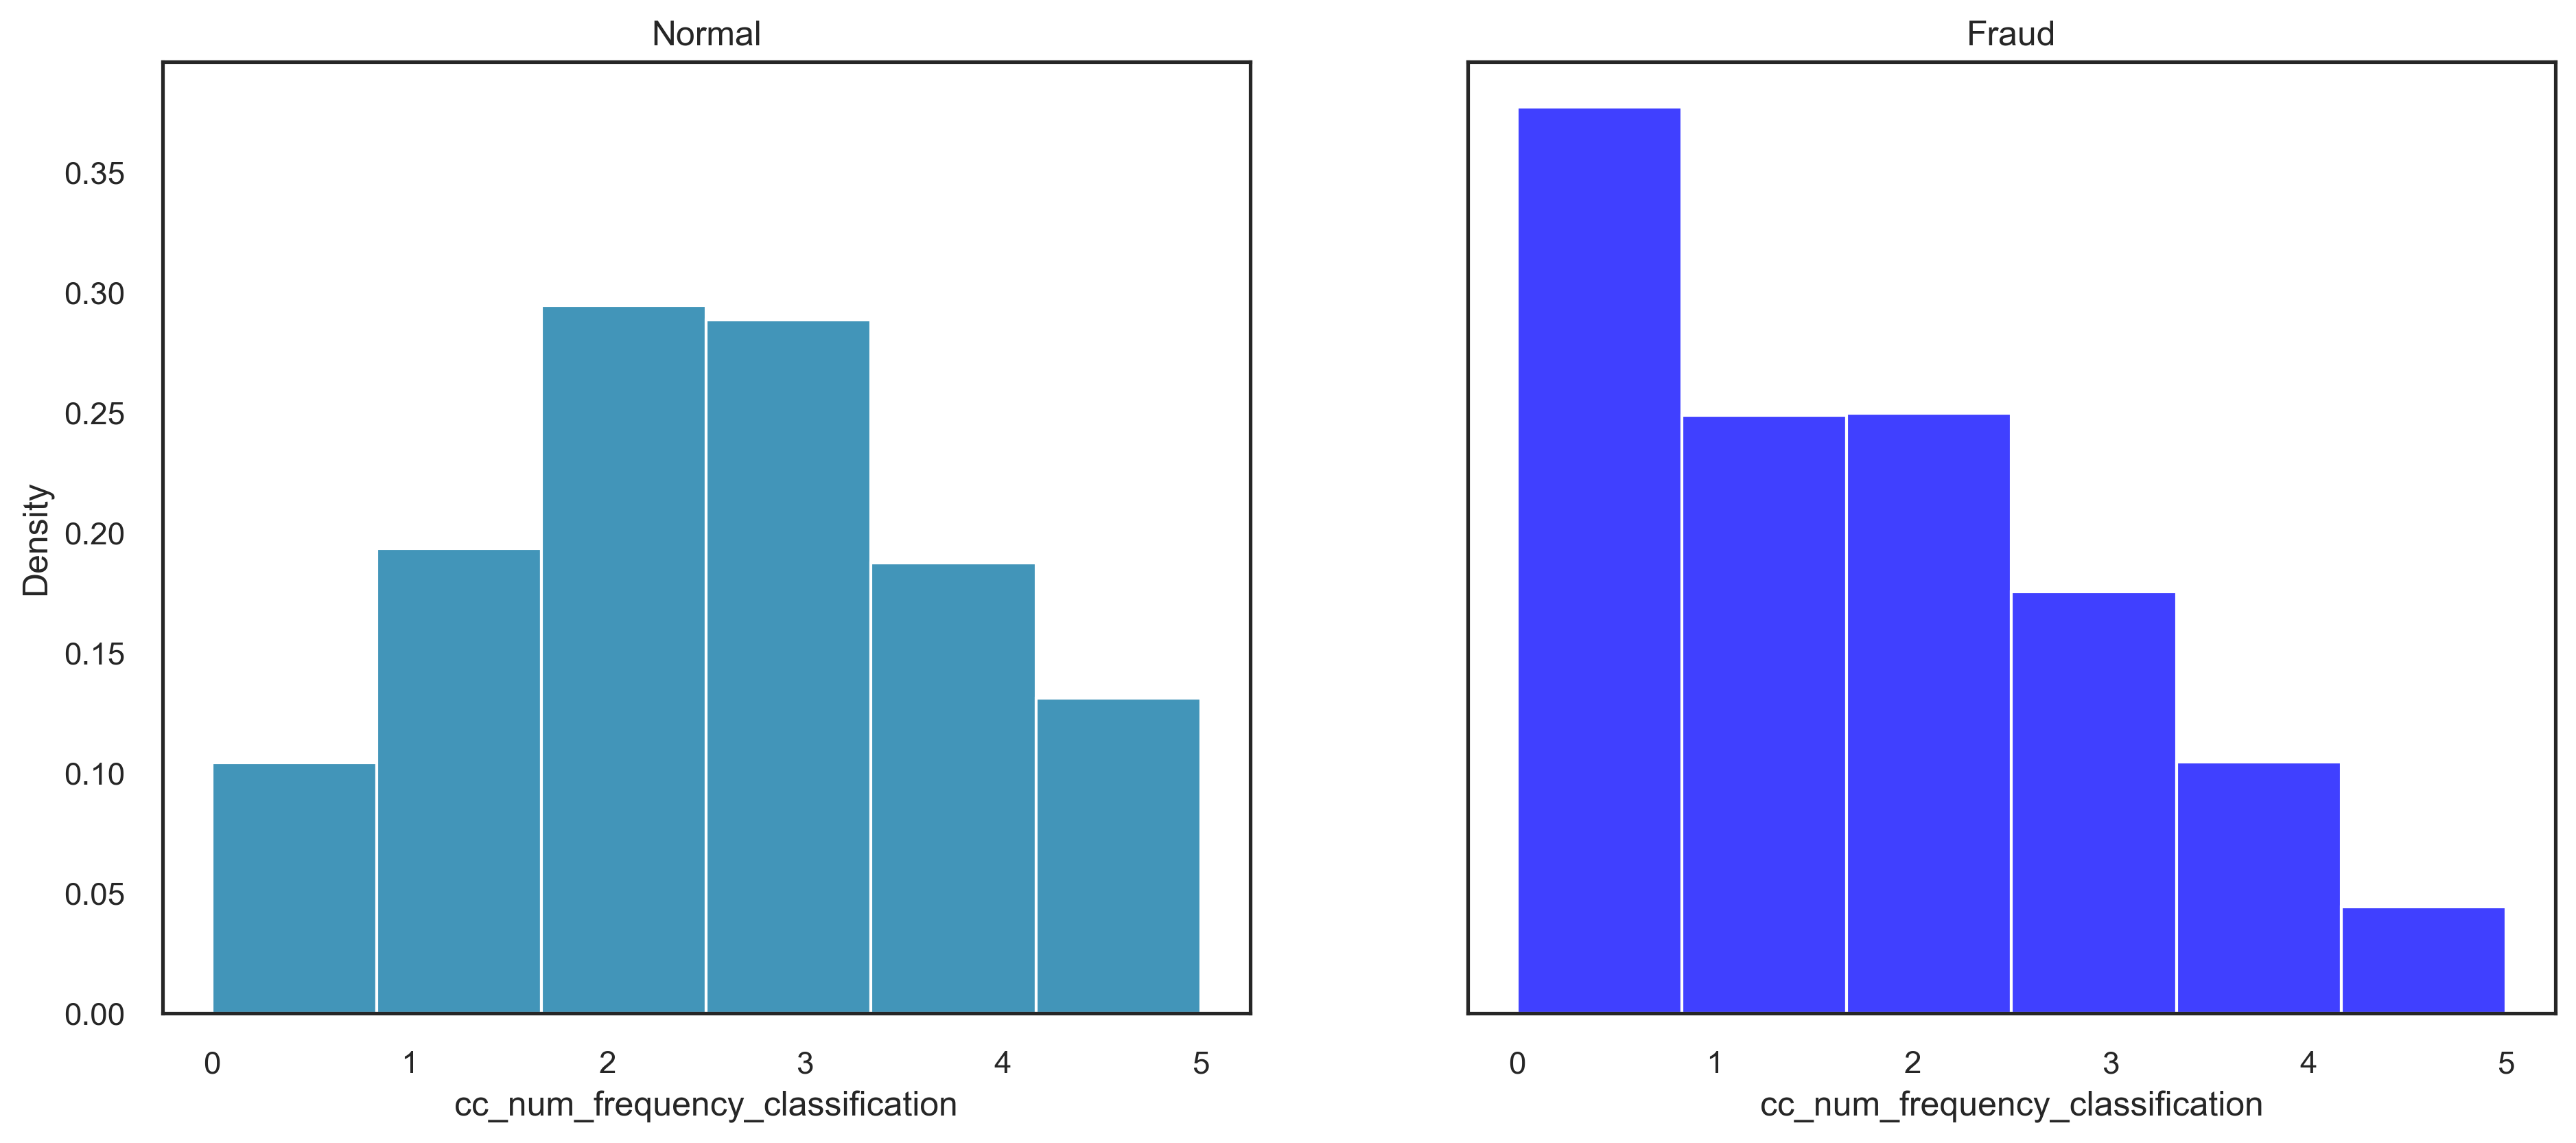

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='cc_num_frequency_classification', data=df_train[df_train["is_fraud"] == 0],
                   stat="density", bins=6, ax=ax1)
ax2 = sns.histplot(x='cc_num_frequency_classification', data=df_train[df_train["is_fraud"] == 1],
                   stat="density", bins=6, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud");

As we can see, there is a clear pattern happening. Frauds are more propitious to happen in credit cards with less use (new ones), and when it comes to normal transactions, it follows a normal distribution.

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 27 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   trans_date_trans_time            1296675 non-null  object 
 1   cc_num                           1296675 non-null  int64  
 2   category                         1296675 non-null  object 
 3   amt                              1296675 non-null  float64
 4   gender                           1296675 non-null  object 
 5   city                             1296675 non-null  object 
 6   state                            1296675 non-null  object 
 7   zip                              1296675 non-null  int64  
 8   lat                              1296675 non-null  float64
 9   long                             1296675 non-null  float64
 10  city_pop                         1296675 non-null  int64  
 11  job                              1296675 non-null 

In [232]:
from imblearn.under_sampling import RandomUnderSampler


In [233]:
X = df_train.drop(columns=["is_fraud"])
y = df_train["is_fraud"]

In [234]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)

In [235]:
X_undersampled = X
y_undersampled = y

Let's check our proportion after the Undersampling.

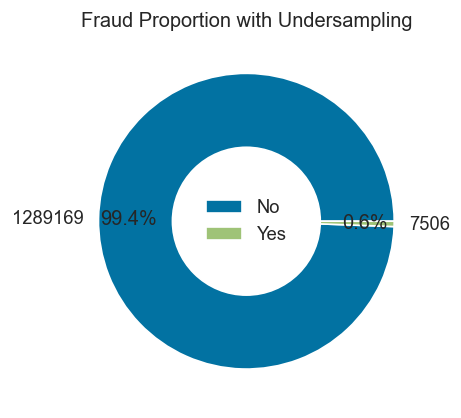

In [236]:
donut = y_undersampled.value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud Proportion with Undersampling")
plt.legend(labels, loc="center", frameon=False)
plt.show();

# Feature Importance

First, we are going to generate two random vectors to help us compare the feature importances (If a feature has less importance than a random vector, we can suspect that the feature is not good for the model).

In [237]:
df_train["random_feat_1"] = np.random.randint(
    0, 100, size=len(X_undersampled))
df_train["random_feat_2"] = np.random.randint(
    0, 500, size=len(X_undersampled))

In [238]:
X_train = X_undersampled.drop(columns=["trans_date_trans_time",
                                       "city", "state", "category", "gender", "dob", "job", "cc_num", "amt"])

y_train = y_undersampled

In [239]:
X_train.head()

zip      lat      long  city_pop  merch_lat  merch_long  age  hour  \
0  28654  36.0788  -81.1781      3495  36.011293  -82.048315   35     0   
1  99160  48.8878 -118.2105       149  49.159047 -118.186462   45     0   
2  83252  42.1808 -112.2620      4154  43.150704 -112.154481   61     0   
3  59632  46.2306 -112.1138      1939  47.034331 -112.561071   56     0   
4  24433  38.4207  -79.4629        99  38.674999  -78.632459   37     0   

   month   amt_log  category_WOE  state_WOE  city_WOE   job_WOE  \
0      1  1.786747      0.924914  -0.156457 -2.469513 -1.080186   
1      1  4.684259      0.898799  -0.122657 -3.027790 -0.904144   
2      1  5.398660     -0.847622  -0.988155 -1.076791  1.120434   
3      1  3.828641     -0.209382  -0.727015  1.746674  0.361872   
4      1  3.760269     -0.611091   0.162213 -2.464077 -2.464077   

   gender_binary  cc_num_frequency  cc_num_frequency_classification  \
0              0              2028                                3   
1              0              3030                                5   
2              1               503                                0   
3              1               493                                0   
4              1              2017                                3   

   random_feat_1  random_feat_2  
0             27            410  
1             14              0  
2             58            452  
3             13            211  
4             52             22

Let's use Boruta algorithm and random forests feature importances to identify which features we are going to use in our model.

In [240]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 19 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   zip                              1296675 non-null  int64  
 1   lat                              1296675 non-null  float64
 2   long                             1296675 non-null  float64
 3   city_pop                         1296675 non-null  int64  
 4   merch_lat                        1296675 non-null  float64
 5   merch_long                       1296675 non-null  float64
 6   age                              1296675 non-null  int64  
 7   hour                             1296675 non-null  int64  
 8   month                            1296675 non-null  int64  
 9   amt_log                          1296675 non-null  float64
 10  category_WOE                     1296675 non-null  float64
 11  state_WOE                        1296675 non-null 

In [241]:
from boruta import BorutaPy


In [ ]:
rf = RandomForestClassifier(random_state=23, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=999)
result_boruta = feat_selector.fit(X_train.values, y_train)
accept = X_train.columns[feat_selector.support_].to_list()
irresolution = X_train.columns[feat_selector.support_weak_].to_list()

print("Features selected:")
list(accept)

Now let's check feature importance with Random Forest.

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importances = rf.feature_importances_

In [ ]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout();

Now we proceed to select our features. Since "cc_num_frequency" and "cc_num_frequency_classification" is the same information, we are going to drop the less important.

In [242]:
X_train.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                      "city_pop", "month", "cc_num_frequency_classification",
                      "merch_long", "random_feat_1", "random_feat_2"], inplace=True)

In [243]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   merch_lat         1296675 non-null  float64
 1   age               1296675 non-null  int64  
 2   hour              1296675 non-null  int64  
 3   amt_log           1296675 non-null  float64
 4   category_WOE      1296675 non-null  float64
 5   city_WOE          1296675 non-null  float64
 6   job_WOE           1296675 non-null  float64
 7   cc_num_frequency  1296675 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 79.1 MB


- Finally, this is the features that are entering the model.

# Preparing test data

In [244]:
test = pd.read_csv("fraudTest.csv")
# test.drop(df_test.columns[0], axis=1, inplace=True)


In [245]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [246]:
import category_encoders as ce

def apply_woe(df_test, columns, target_col):
    woe = ce.WOEEncoder()

    for col in columns:
        X = df_test[[col]]
        y = df_test[target_col]

        new_col_name = f"{col}_WOE"
        df_test[new_col_name] = woe.fit_transform(X, y)

    return df_test

columns_to_encode = ["category", "city", "job"]
target_column = "is_fraud"

test = apply_woe(test, columns_to_encode, target_column)


In [247]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [248]:
test['age'] = dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['month'] = pd.to_datetime(test['trans_date_trans_time']).dt.month

test.drop(columns=["merchant", "first", "last", "street",
                   "unix_time", "trans_num"], inplace=True)

test["amt_log"] = np.log1p(test["amt"])

test["gender_binary"] = test["gender"].map(gender_mapping)

freq_enc_test = (test.groupby("cc_num").size())
freq_enc_test.sort_values(ascending=True)
test["cc_num_frequency"] = test["cc_num"].apply(lambda x: freq_enc_test[x])
test["cc_num_frequency_classification"] = test["cc_num_frequency"].apply(
    classify_frequency)

In [249]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       555719 non-null  int64  
 1   trans_date_trans_time            555719 non-null  object 
 2   cc_num                           555719 non-null  int64  
 3   category                         555719 non-null  object 
 4   amt                              555719 non-null  float64
 5   gender                           555719 non-null  object 
 6   city                             555719 non-null  object 
 7   state                            555719 non-null  object 
 8   zip                              555719 non-null  int64  
 9   lat                              555719 non-null  float64
 10  long                             555719 non-null  float64
 11  city_pop                         555719 non-null  int64  
 12  jo

In [250]:
missing_columns = set(X_train.columns) - set(test.columns)
print("Columns in X_train but not in test:", missing_columns)


Columns in X_train but not in test: set()


In [251]:
columns_to_drop = set(test.columns) - set(X_train.columns) - {"is_fraud"}
test_filtered = test.drop(columns=columns_to_drop, errors='ignore')


In [252]:
test.drop(columns=columns_to_drop, errors='ignore', inplace=True)


In [253]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   merch_lat         555719 non-null  float64
 1   is_fraud          555719 non-null  int64  
 2   category_WOE      555719 non-null  float64
 3   city_WOE          555719 non-null  float64
 4   job_WOE           555719 non-null  float64
 5   age               555719 non-null  int64  
 6   hour              555719 non-null  int64  
 7   amt_log           555719 non-null  float64
 8   cc_num_frequency  555719 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 38.2 MB


In [254]:
desired_order = ["merch_lat", "age", "hour", "amt_log", "category_WOE", "city_WOE", "job_WOE", "cc_num_frequency", "is_fraud"]

test = test[desired_order]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   merch_lat         555719 non-null  float64
 1   age               555719 non-null  int64  
 2   hour              555719 non-null  int64  
 3   amt_log           555719 non-null  float64
 4   category_WOE      555719 non-null  float64
 5   city_WOE          555719 non-null  float64
 6   job_WOE           555719 non-null  float64
 7   cc_num_frequency  555719 non-null  int64  
 8   is_fraud          555719 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 38.2 MB


# Sampling

As we saw, our data is very imbalanced. Because of that, we are going to use Undersampling in our favor. The method that we are going to use is the RandomUnderSampler.

In [255]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X_train, y_train, stratify=y_train, test_size=0.2)
# print('X_train shape:{}\ny_train shape:{}'.format(X_train.shape,y_train.shape))
# print('X_test shape:{}\ny_test shape:{}'.format(X_test.shape,y_test.shape))

In [256]:
# X_train.info()

In [ ]:
#Sam

In [257]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y, stratify=y, test_size=0.2, random_state=42)

# Check the shapes of the sets
print('X_train shape:{}\ny_train shape:{}'.format(X_train.shape, y_train.shape))
print('X_test shape:{}\ny_test shape:{}'.format(X_test.shape, y_test.shape))

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the shapes after resampling
print('X_train_resampled shape:{}\ny_train_resampled shape:{}'.format(X_train_resampled.shape, y_train_resampled.shape))


X_train shape:(1037340, 8)
y_train shape:(1037340,)
X_test shape:(259335, 8)
y_test shape:(259335,)
X_train_resampled shape:(2062670, 8)
y_train_resampled shape:(2062670,)


In [231]:
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
# from collections import Counter

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X_train, y, stratify=y, test_size=0.2, random_state=42)

# # Display class distribution before sampling
# print("Before Random Oversampling:", Counter(y_train))

# # Random Oversampling
# over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
# X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

# # Display class distribution after oversampling
# print("After Random Oversampling:", Counter(y_train_over))

# # Random Undersampling
# under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# # Display class distribution after undersampling
# print("After Random Undersampling:", Counter(y_train_under))


Before Random Oversampling: Counter({0: 1031335, 1: 6005})
After Random Oversampling: Counter({0: 1031335, 1: 1031335})
After Random Undersampling: Counter({0: 6005, 1: 6005})


# Data Modelling

In [258]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score



def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Plot ROC AUC curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# DecisionTree

Accuracy: 0.9970347234272273
ROC AUC: 0.9193586159844609
F1 Score: 0.7664743395080472
Confusion Matrix:
[[257304    530]
 [   239   1262]]


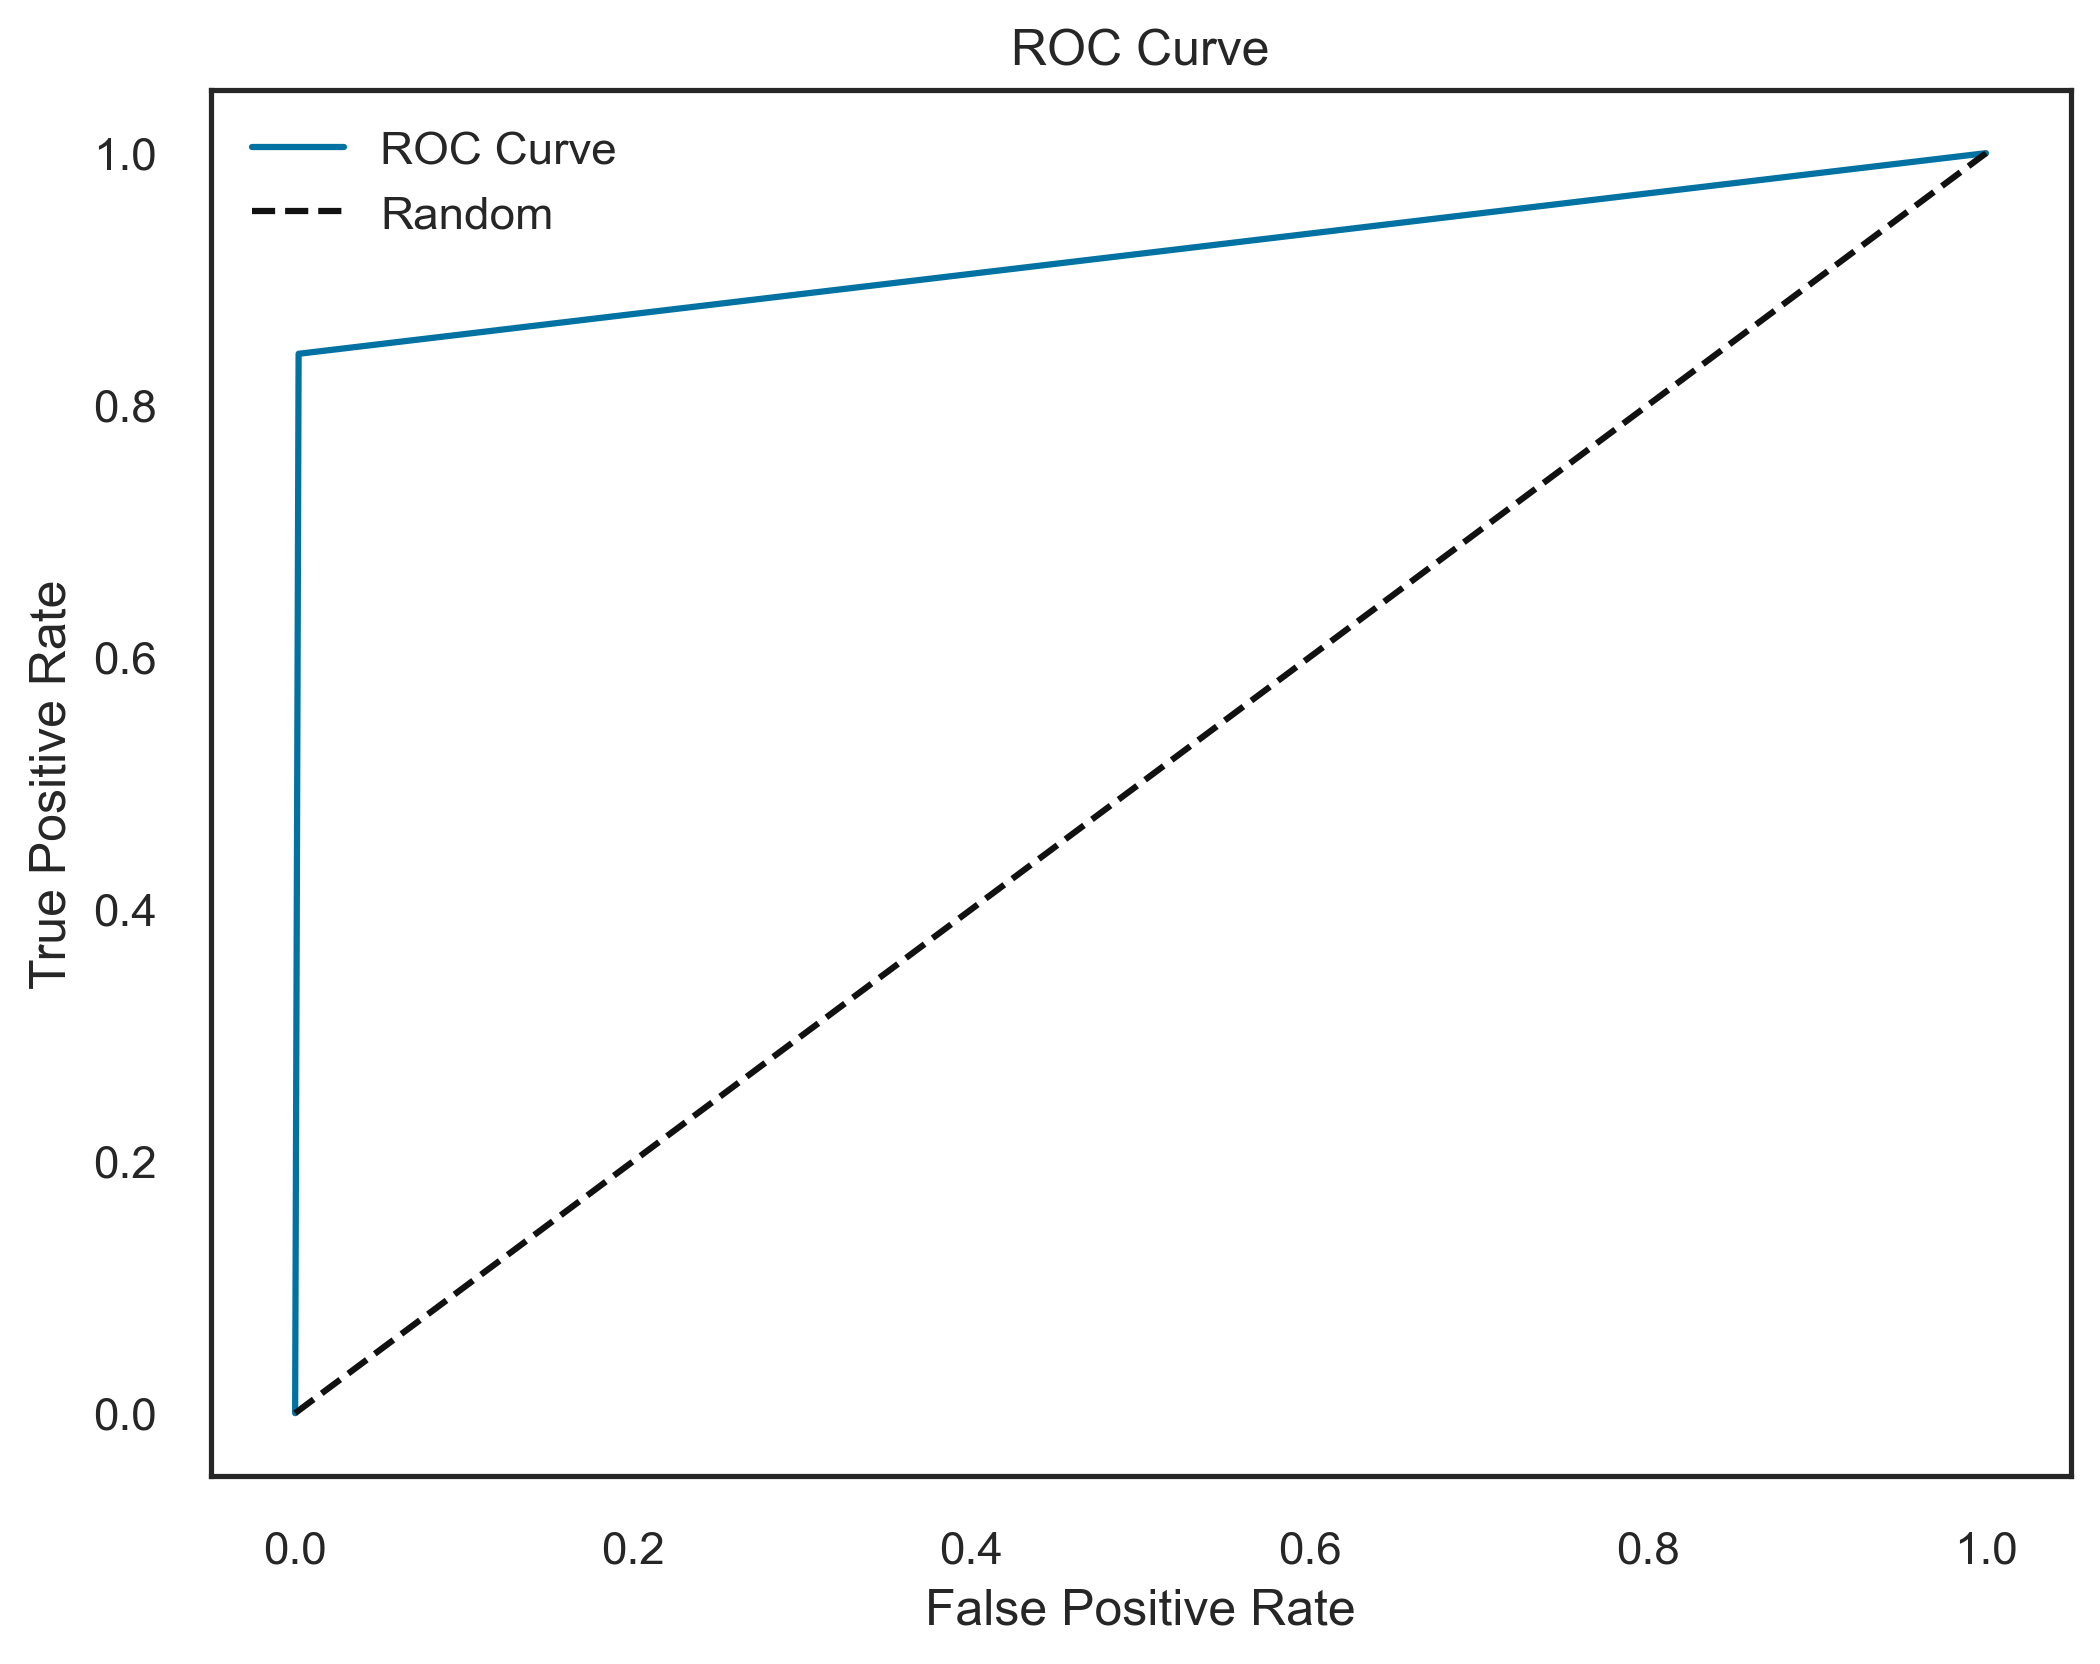

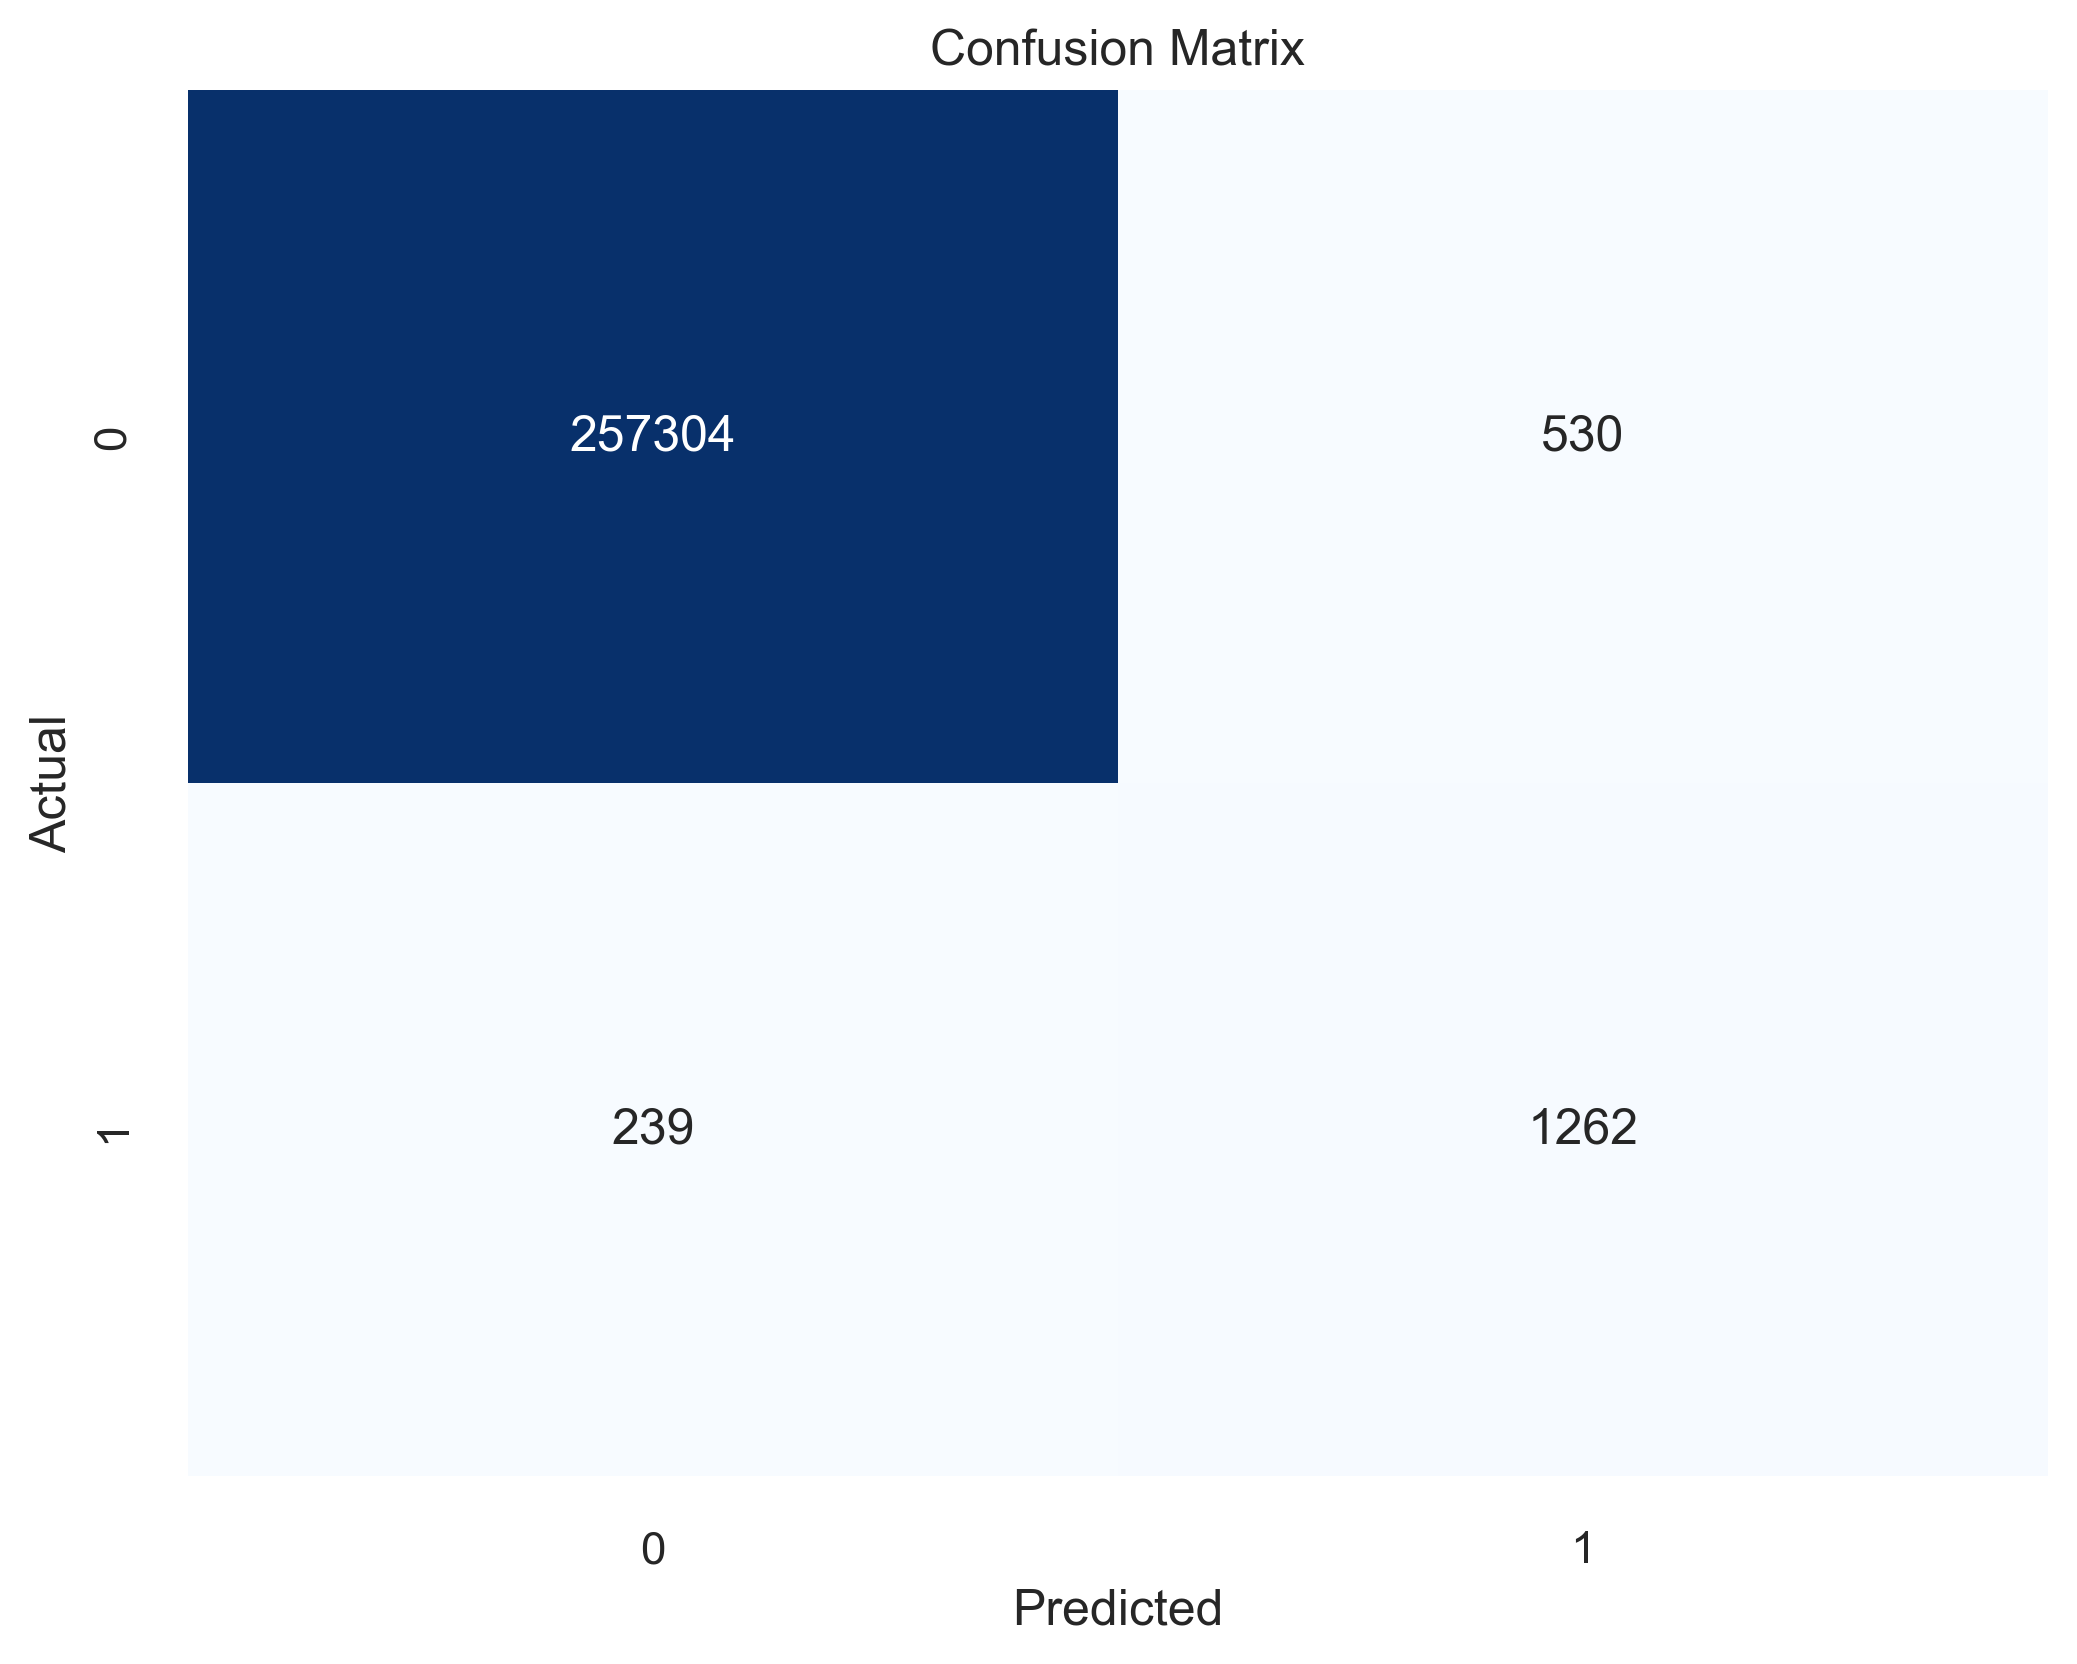

In [259]:
from sklearn.tree import DecisionTreeClassifier

dcstree = DecisionTreeClassifier(random_state=42)
dcstree.fit(X_train_resampled, y_train_resampled)

evaluate_model(dcstree, X_test, y_test)


# Logistic Regression:

C:\Users\EXO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.8291784757167371
ROC AUC: 0.8849003715506917
F1 Score: 0.050944770555722184
Confusion Matrix:
[[213846  43988]
 [   312   1189]]


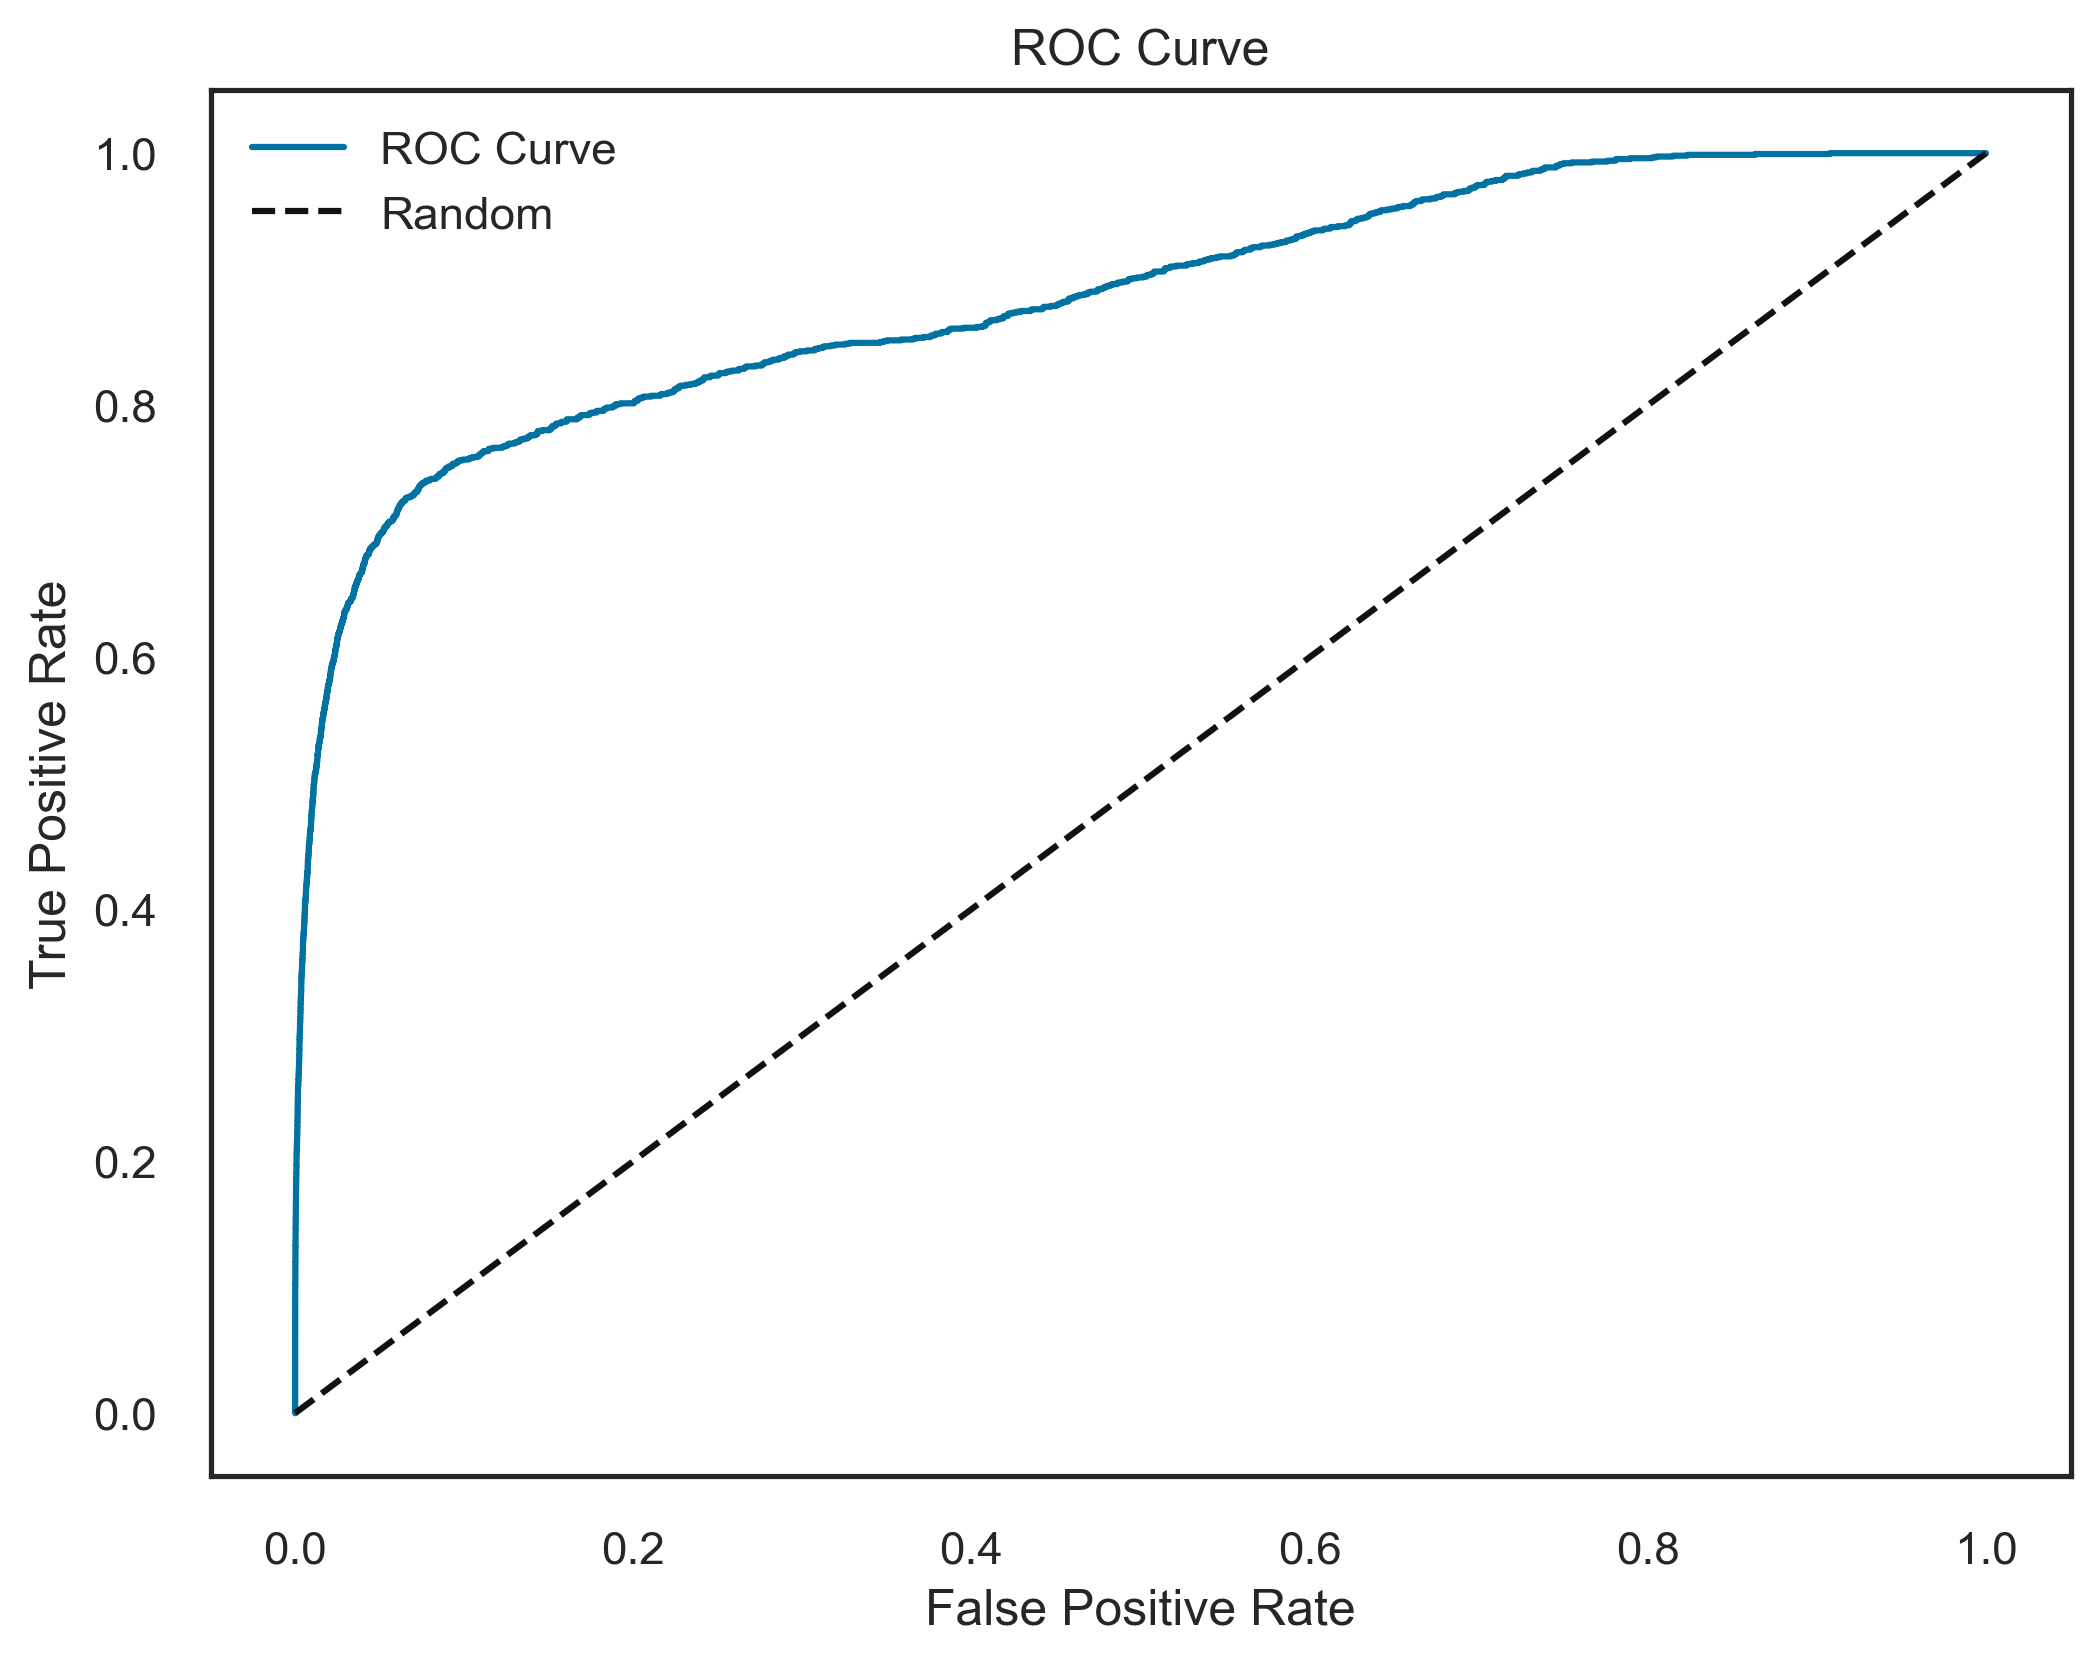

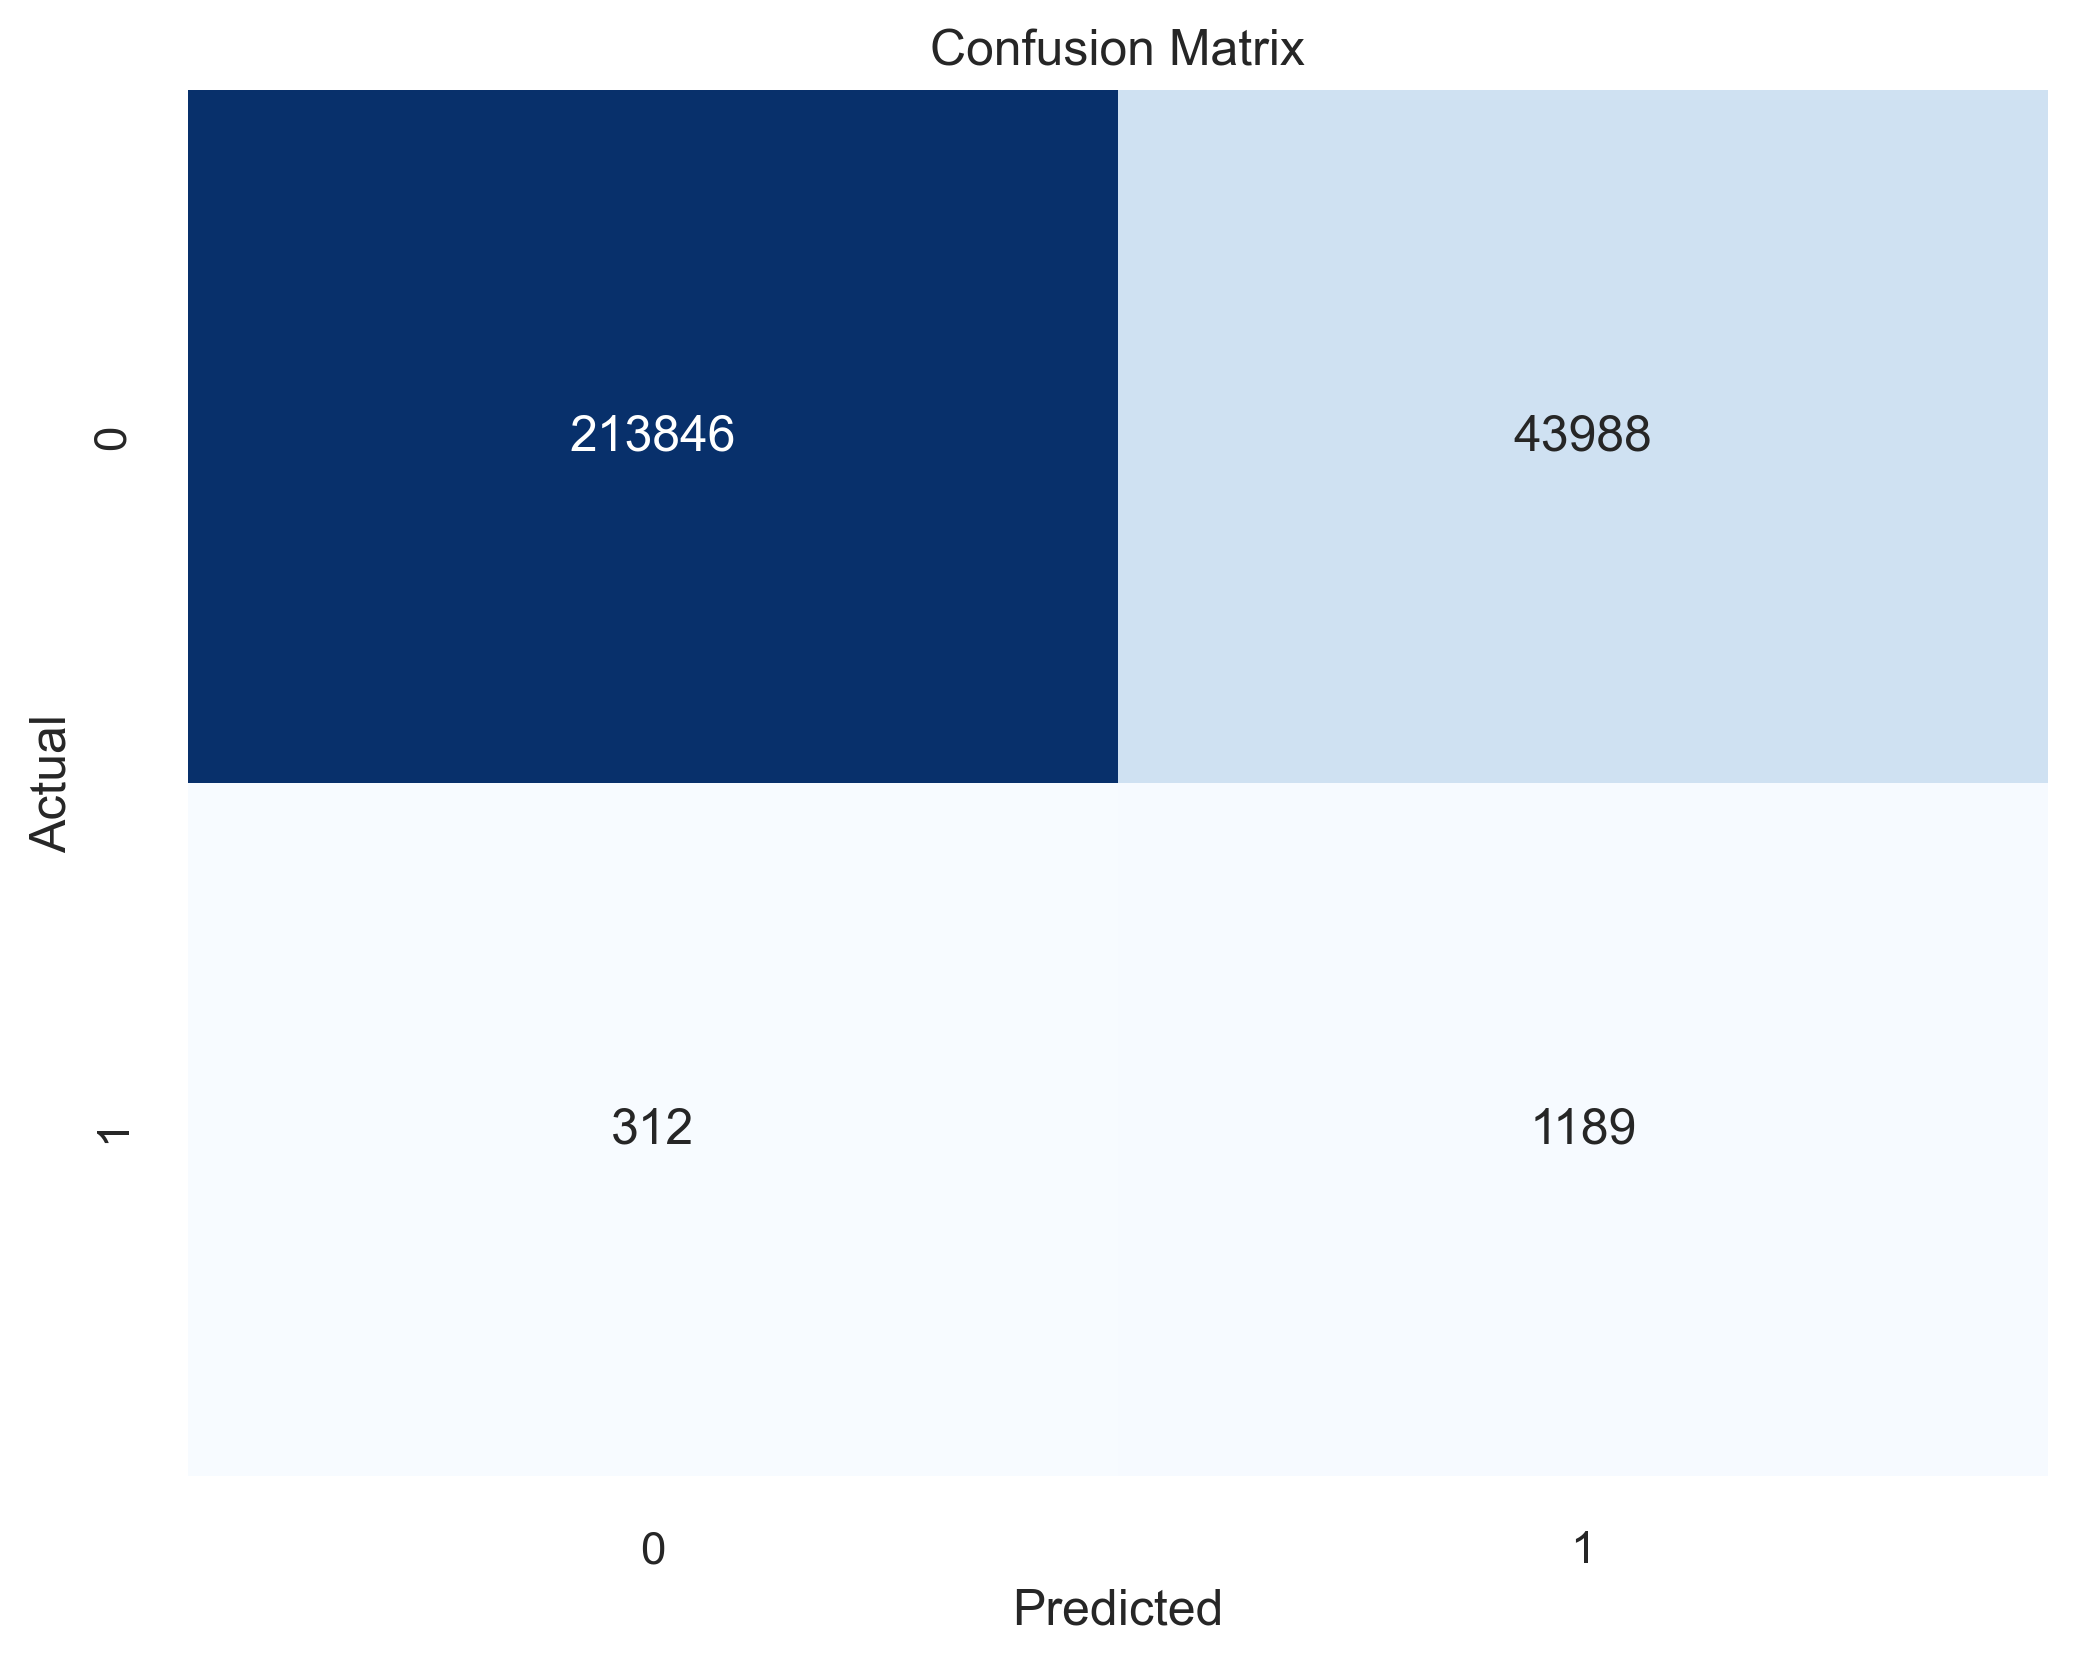

In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

logreg_model = LogisticRegression()
logreg_model.fit(X_train_resampled, y_train_resampled)

evaluate_model(logreg_model, X_test, y_test)

# Random Forest

Accuracy: 0.9980372876780997
ROC AUC: 0.9914719789057839
F1 Score: 0.8292519288829253
Confusion Matrix:
[[257590    244]
 [   265   1236]]


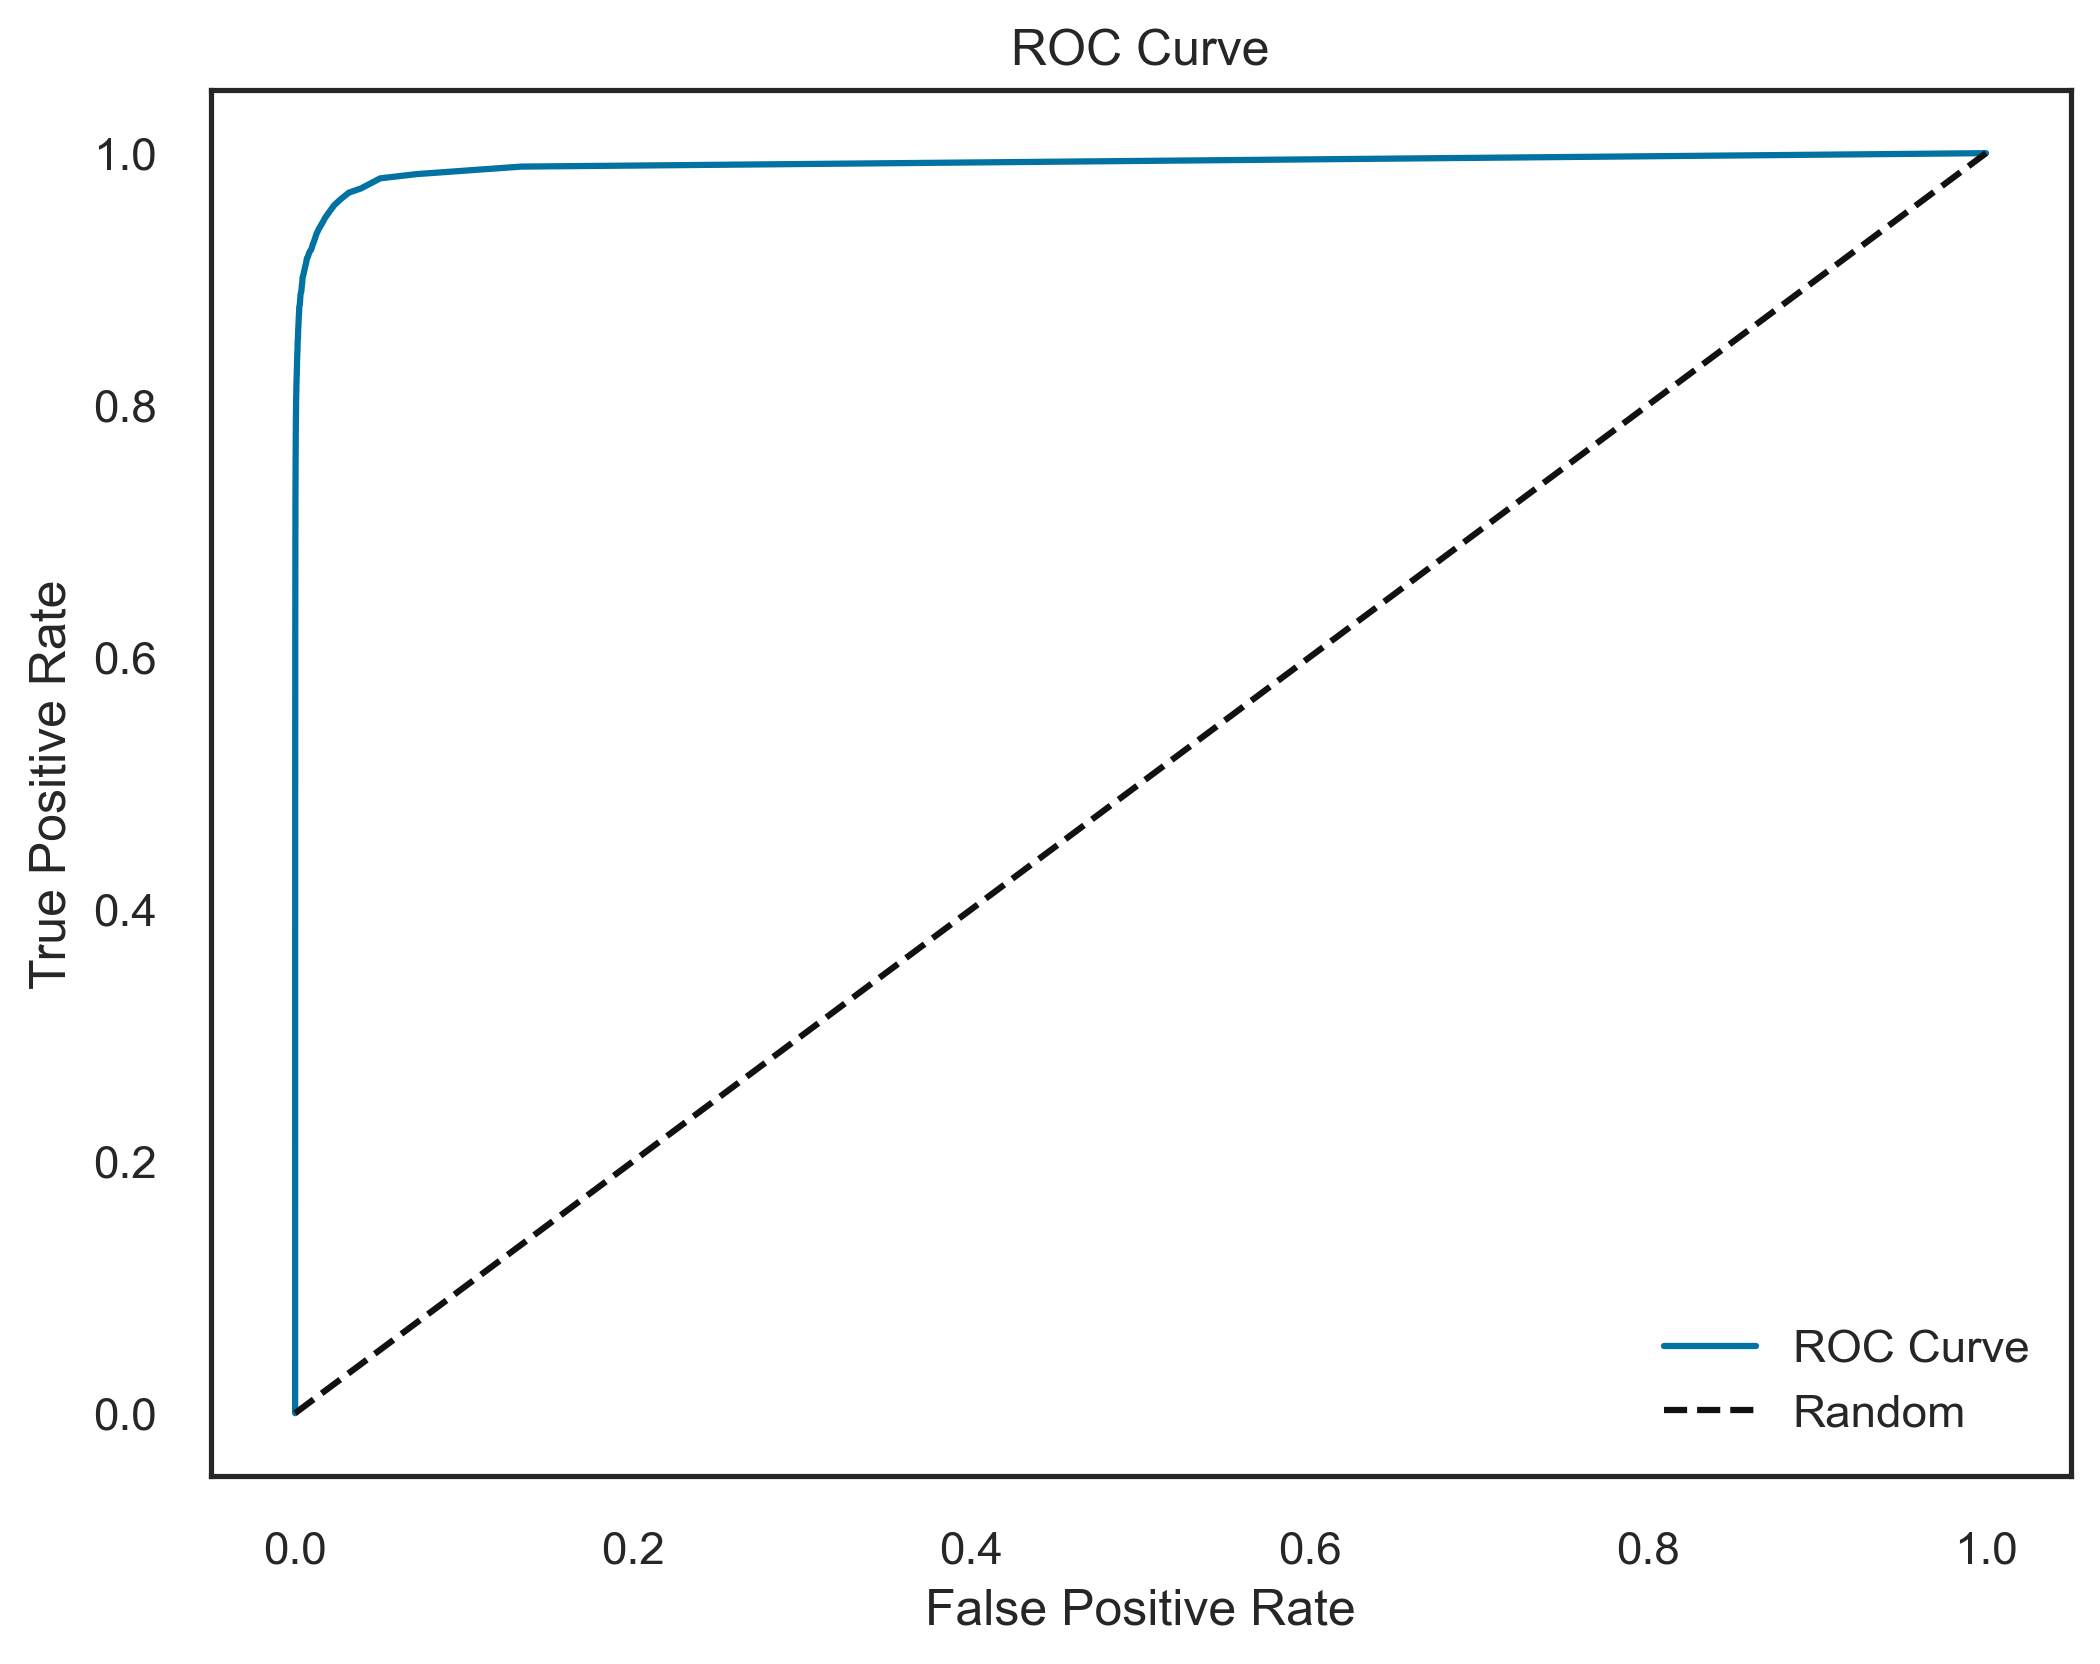

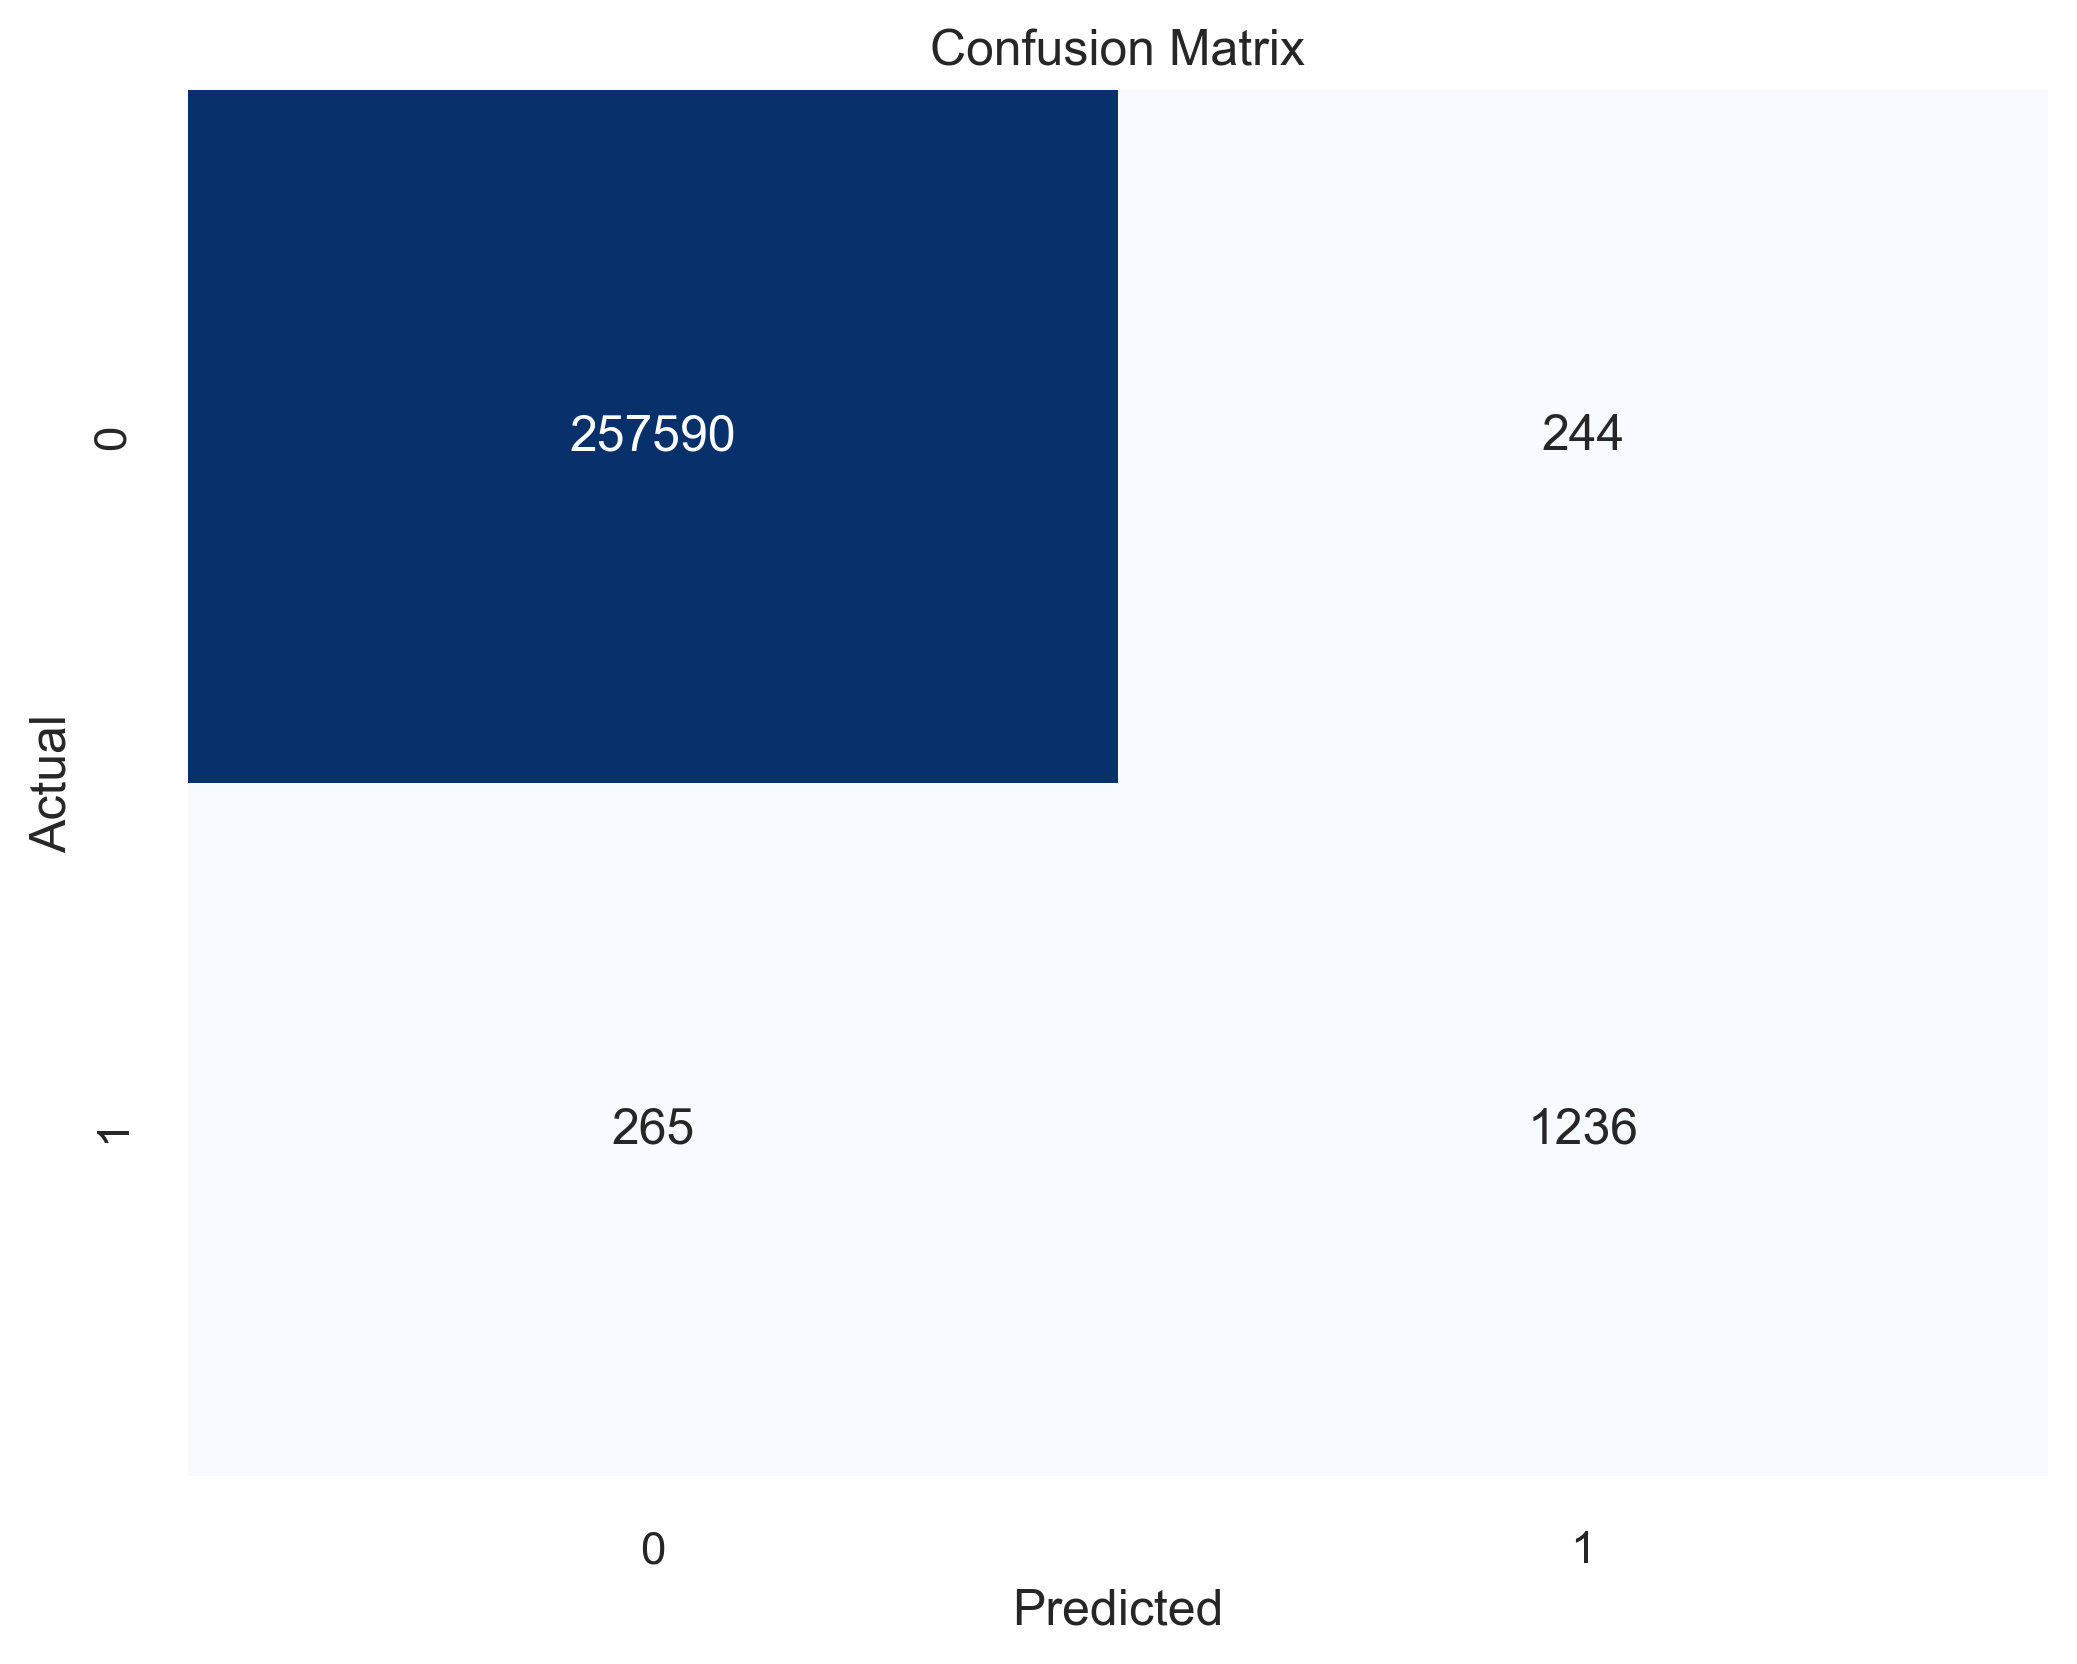

In [261]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate Random Forest
evaluate_model(rf_model, X_test, y_test)

# Naive Bayes

Accuracy: 0.8960070950700831
ROC AUC: 0.8704104645838653
F1 Score: 0.07851846789899886
Confusion Matrix:
[[231217  26617]
 [   352   1149]]


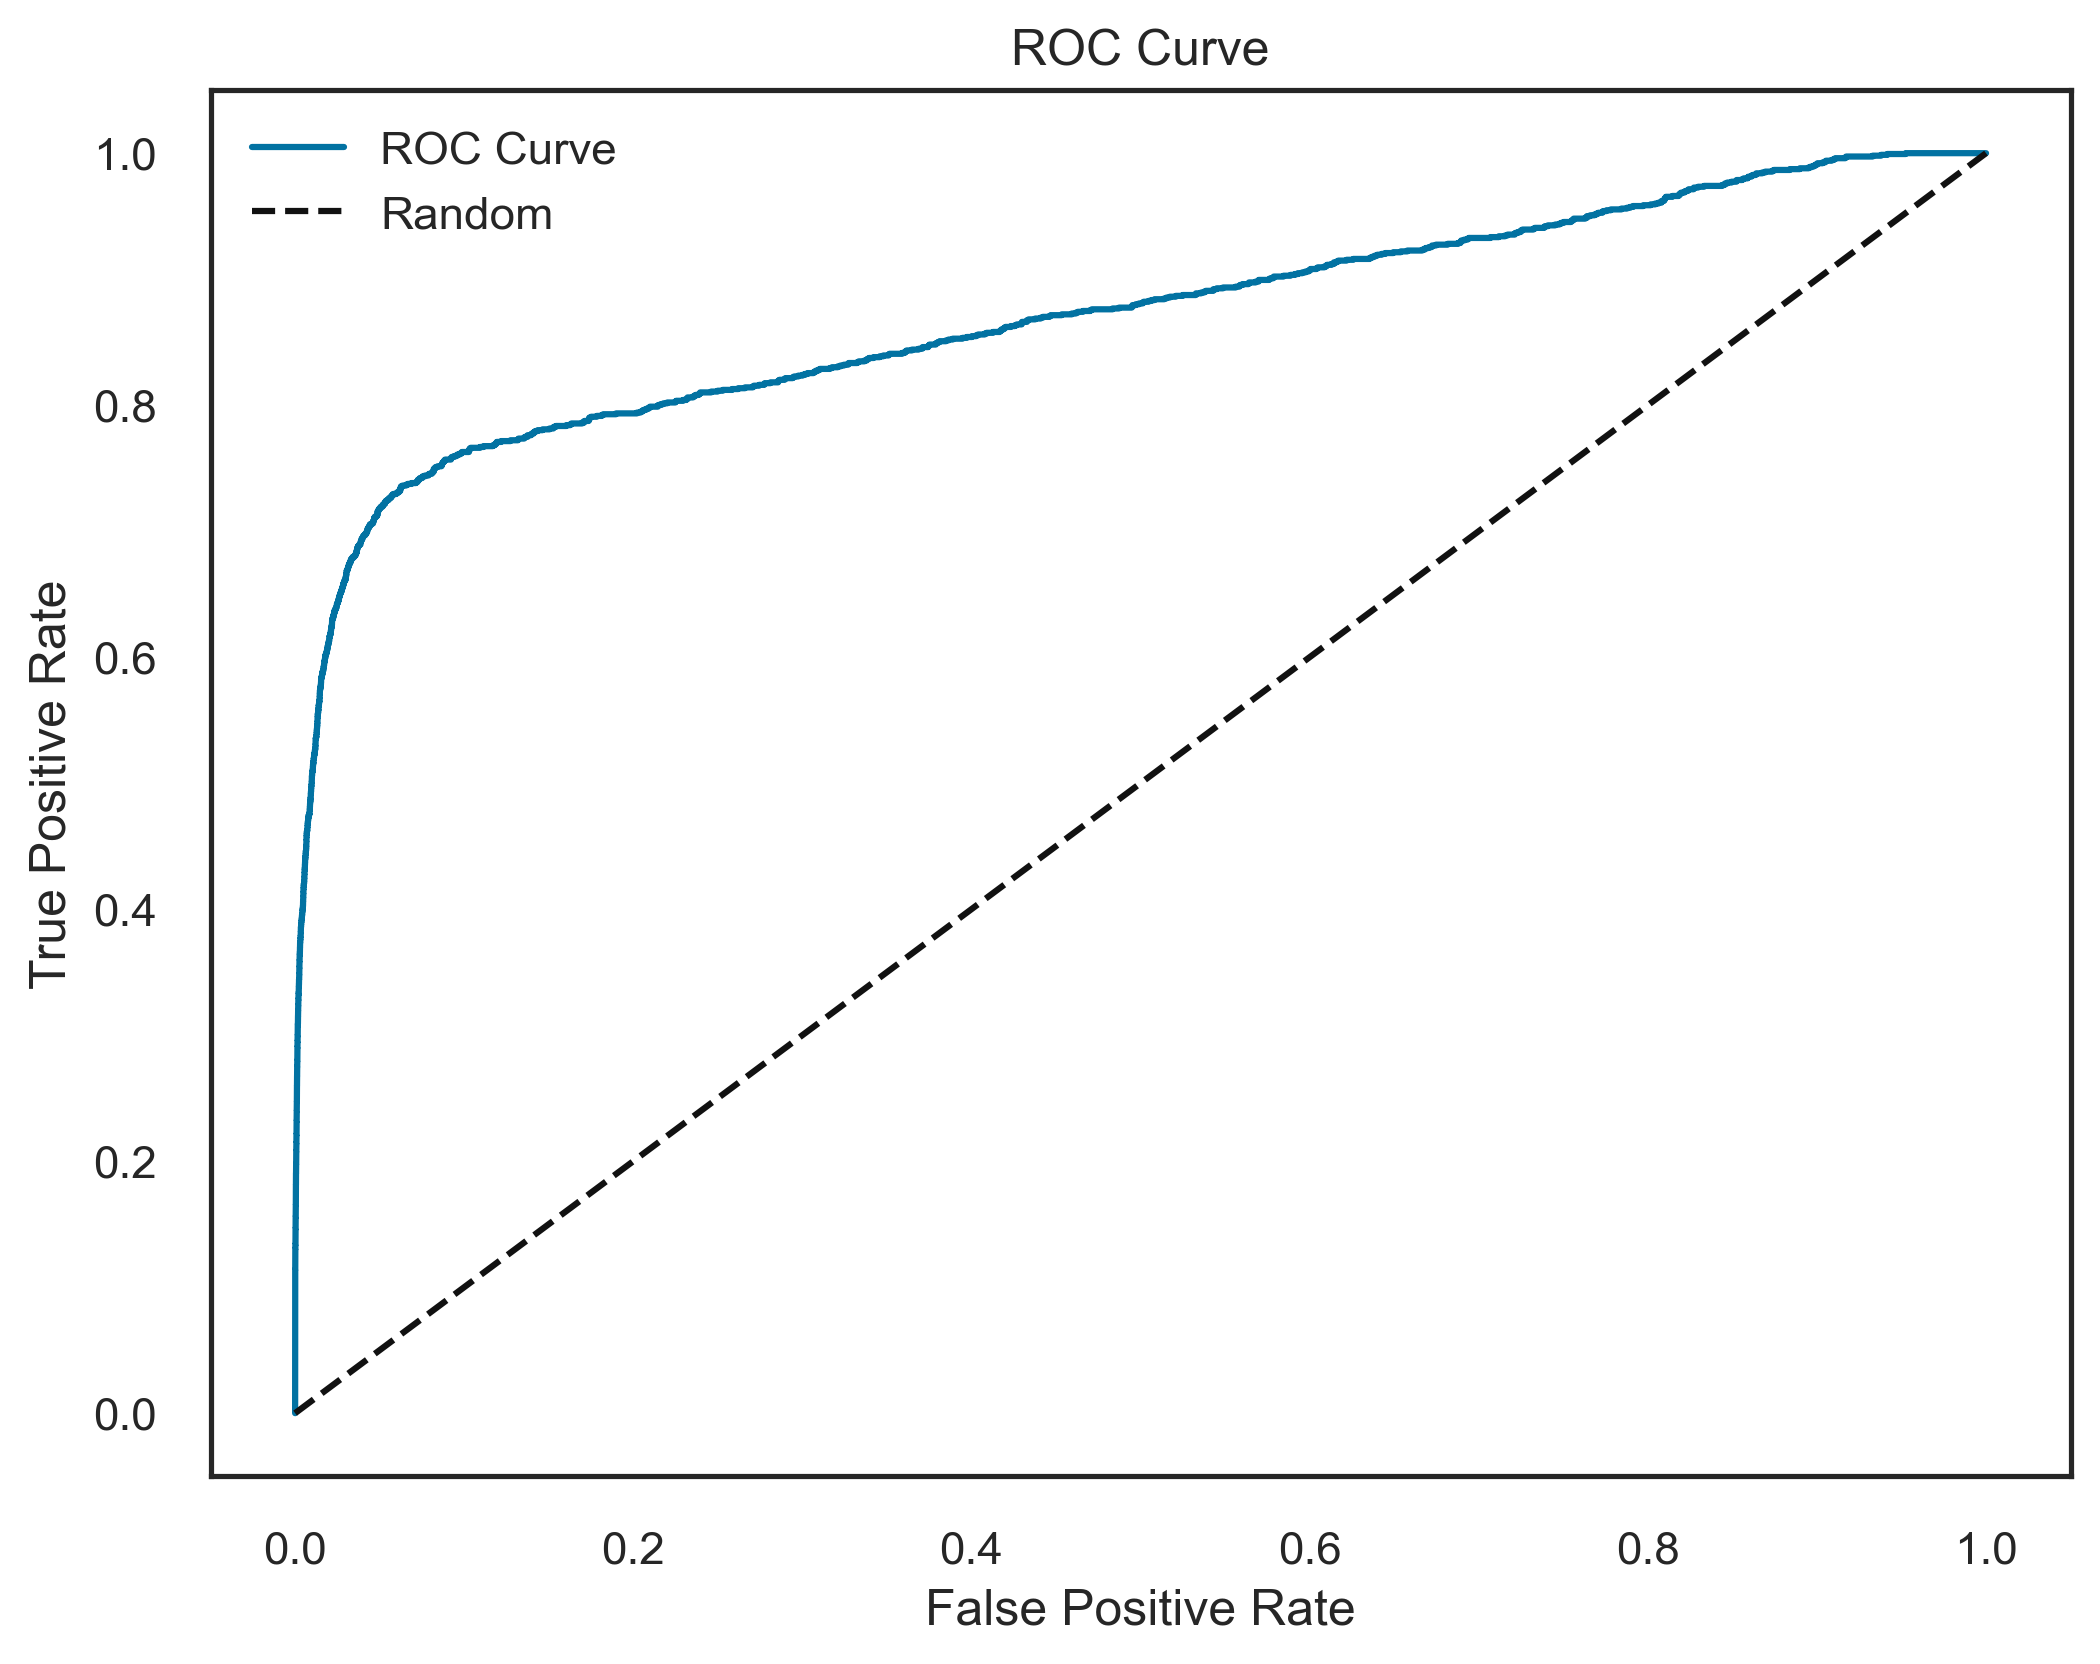

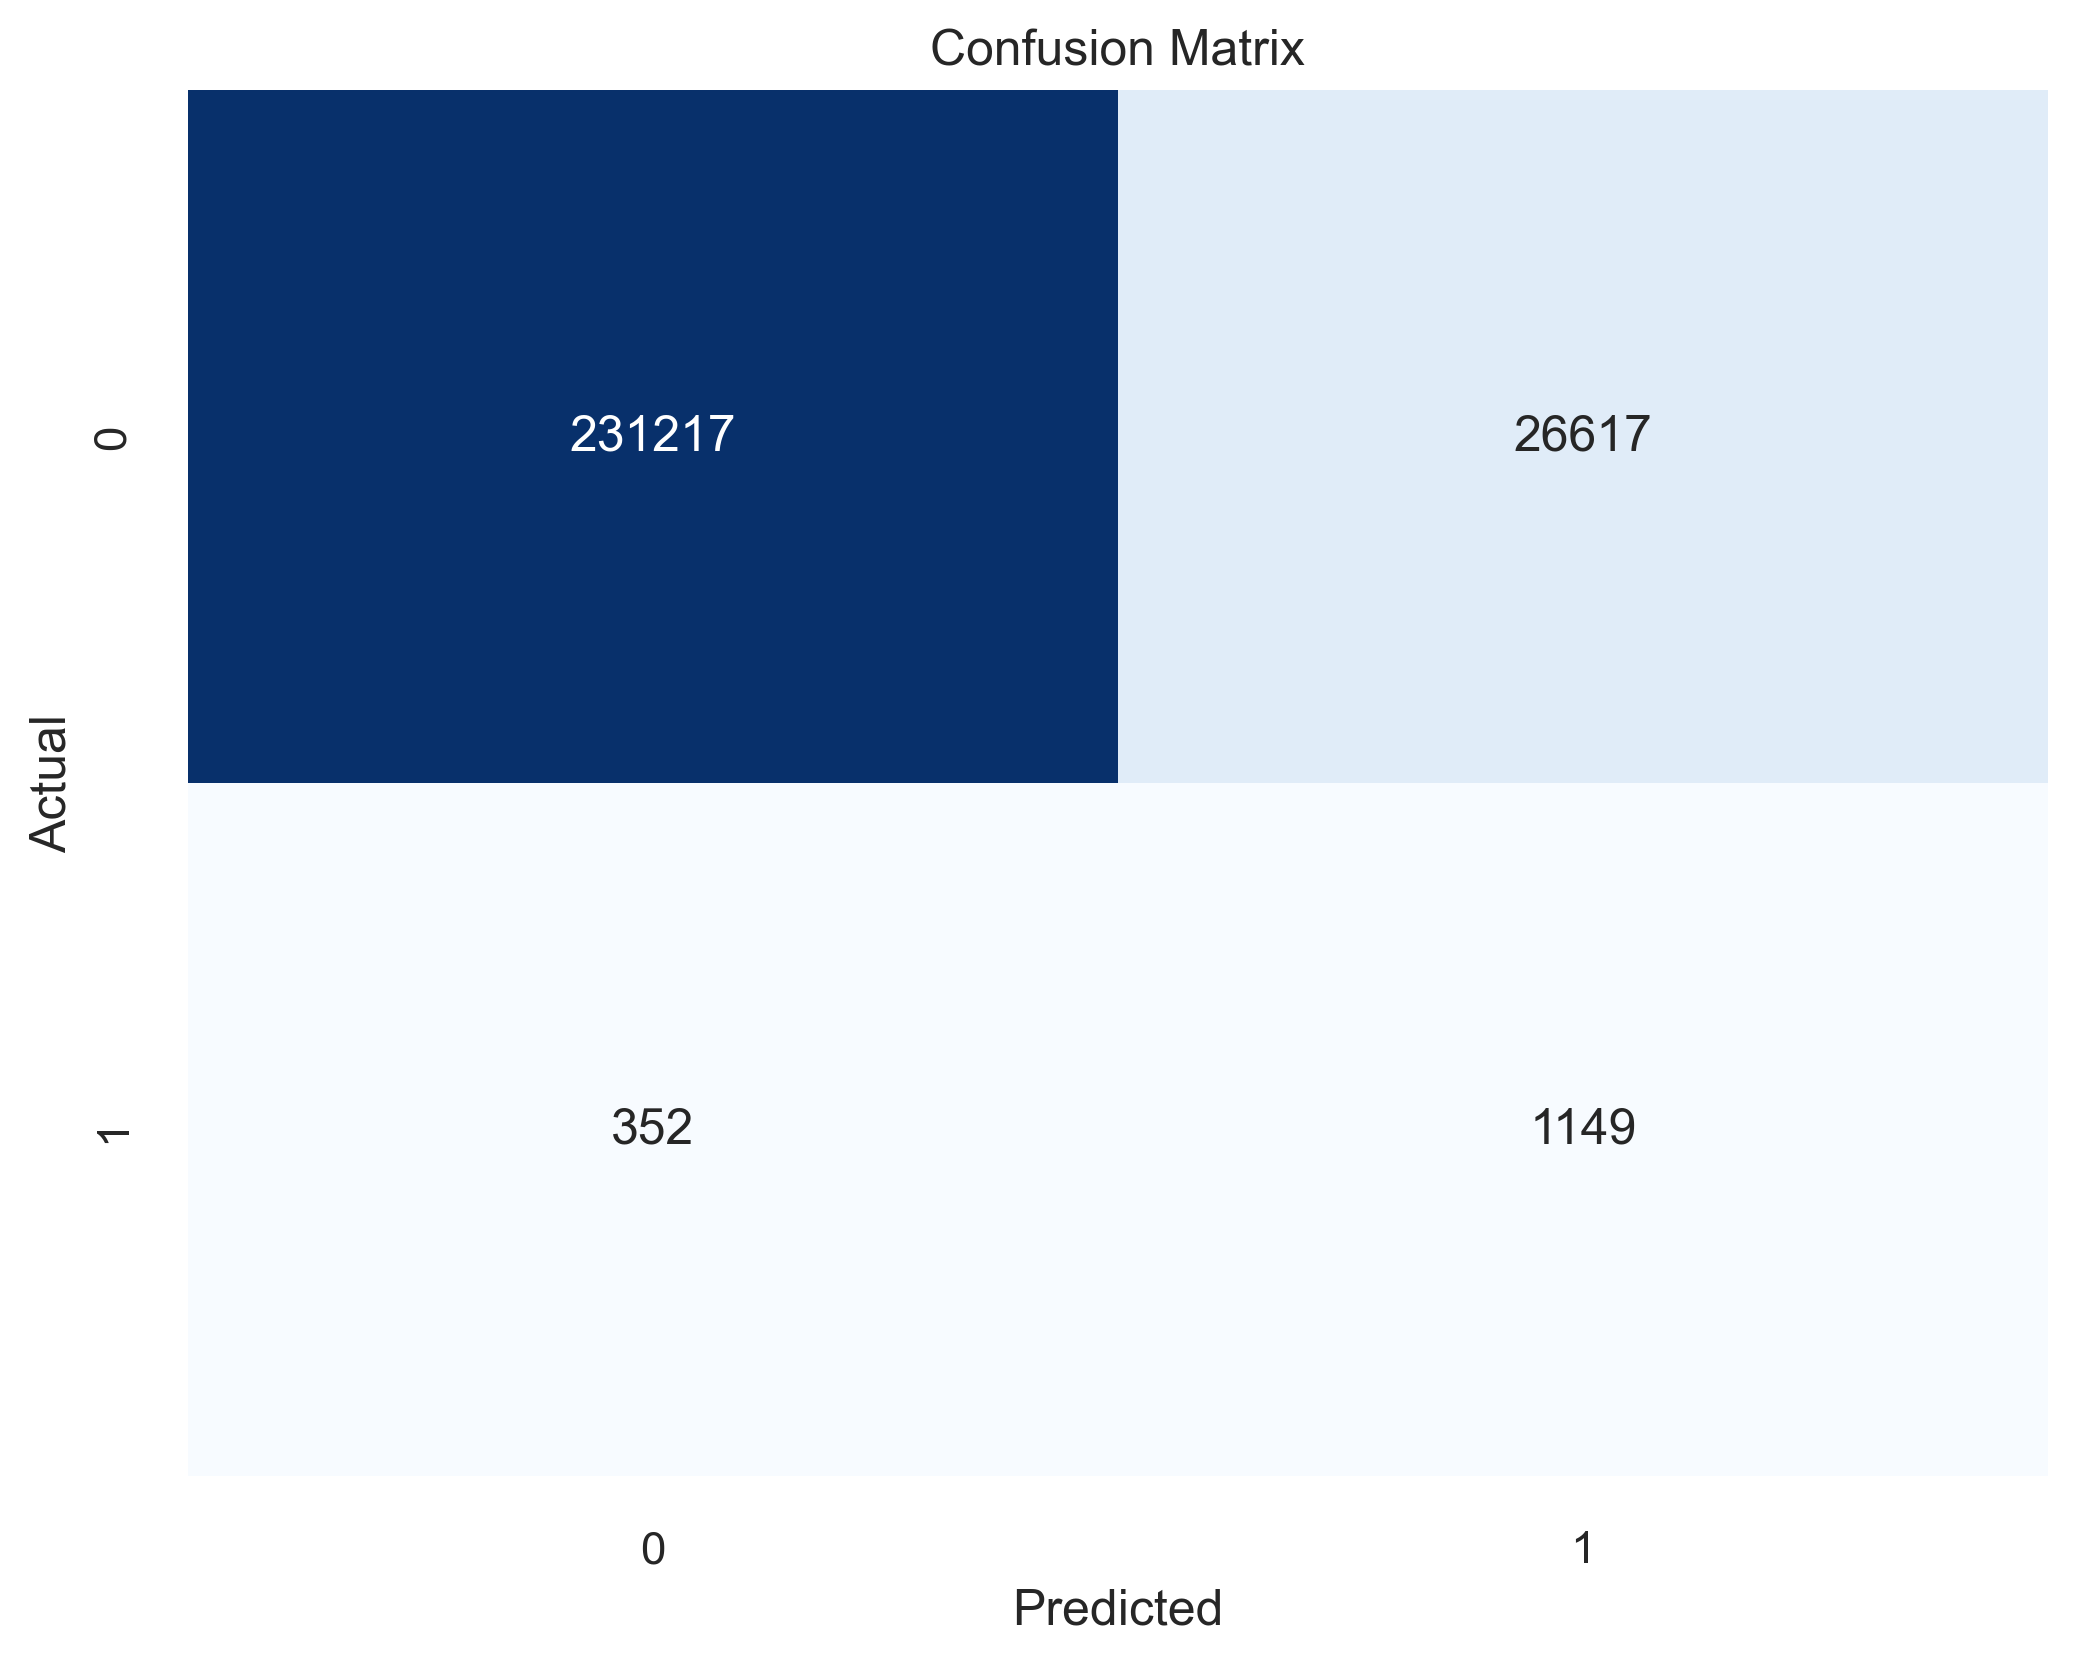

In [262]:
from sklearn.naive_bayes import GaussianNB
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

    # Evaluate Naive Bayes
evaluate_model(nb_model, X_test, y_test)

# gradient_boosting

Accuracy: 0.9800875315711338
ROC AUC: 0.9874962324503425
F1 Score: 0.3409903011740684
Confusion Matrix:
[[252835   4999]
 [   165   1336]]


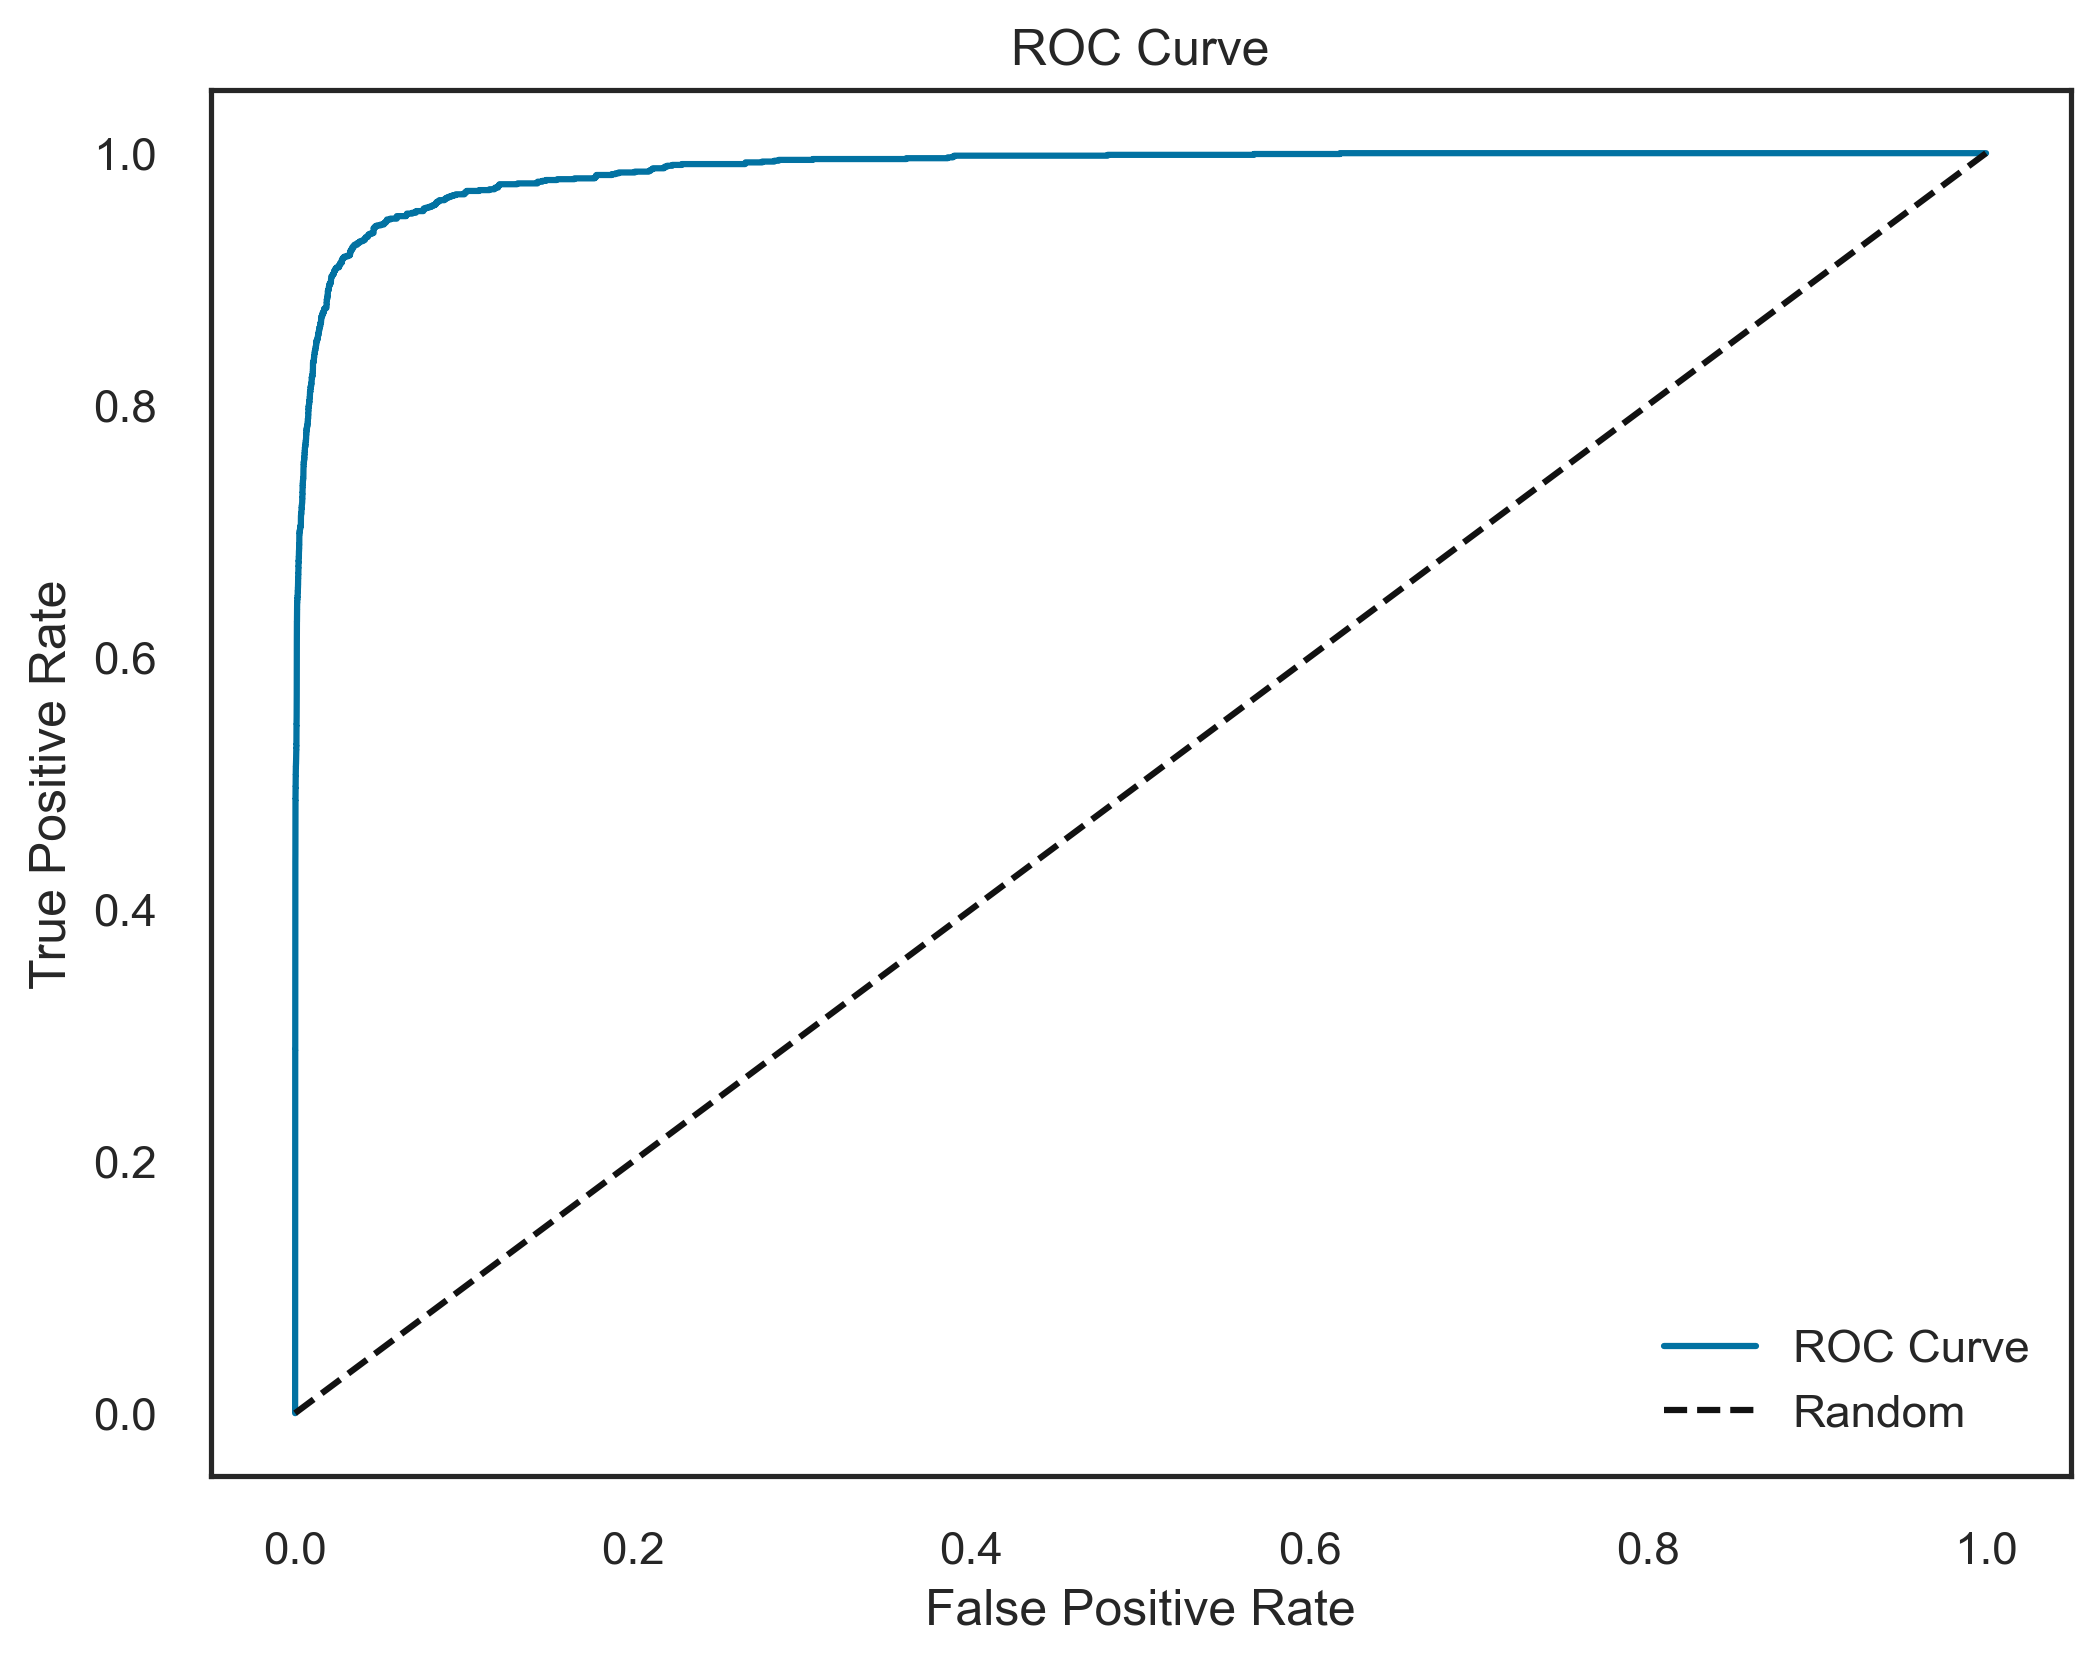

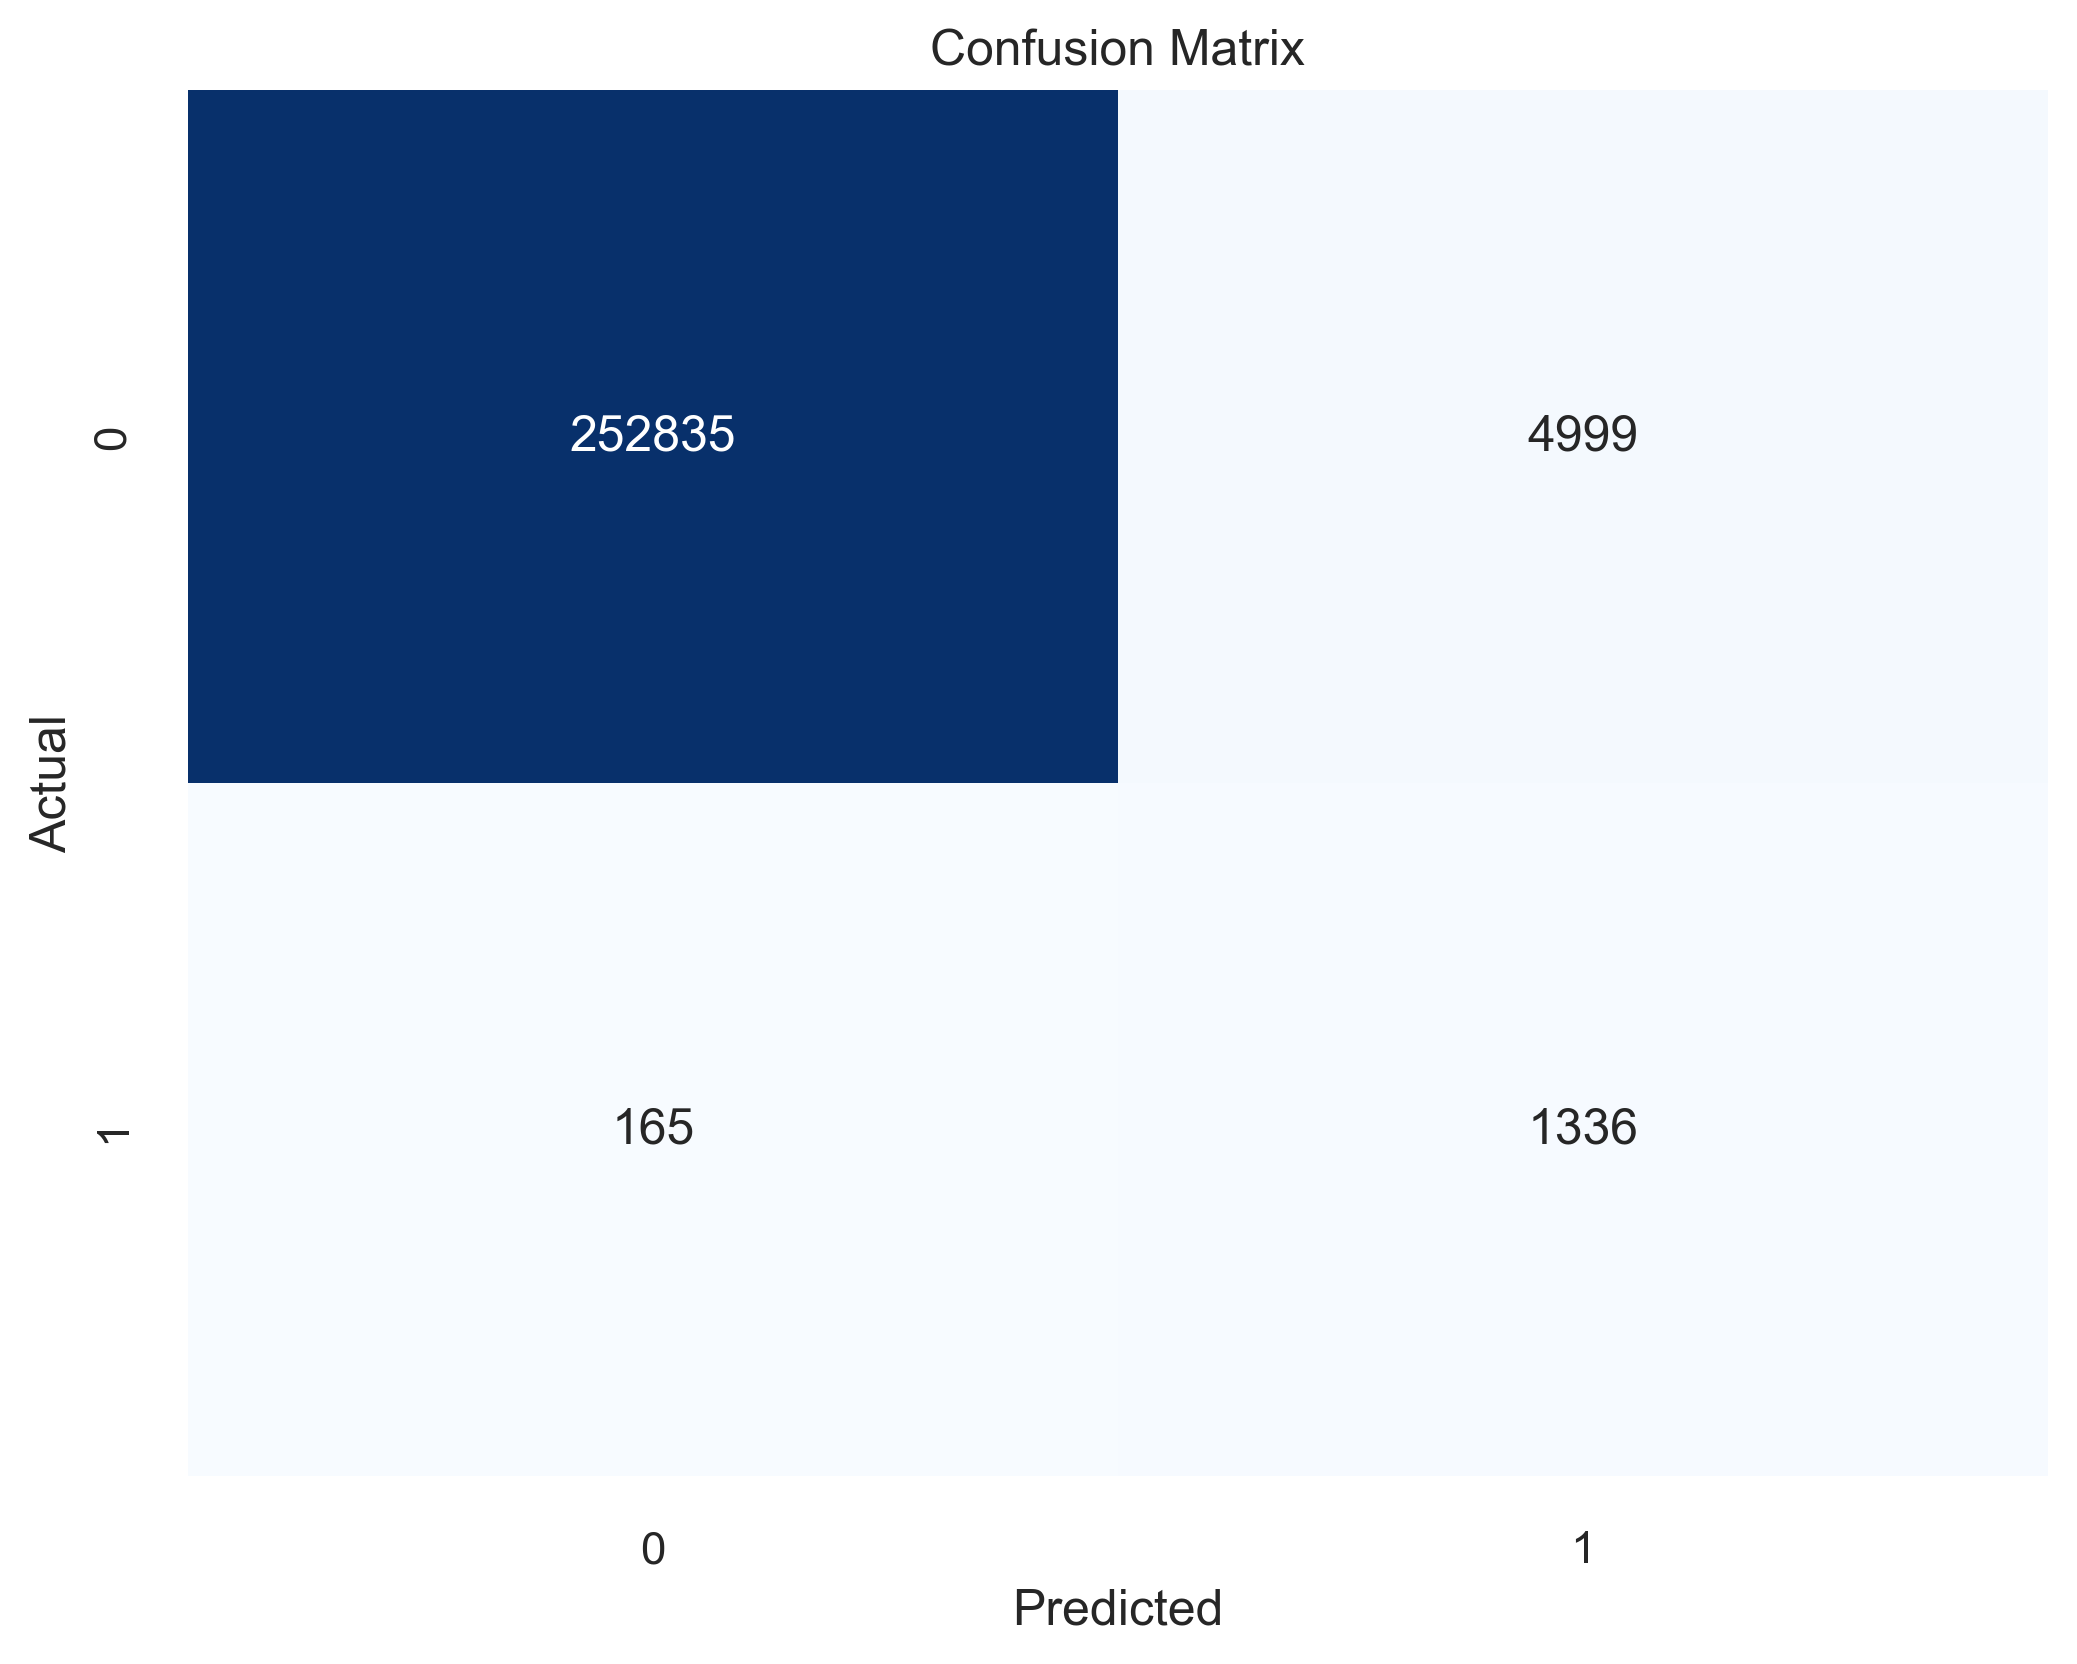

In [263]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_resampled, y_train_resampled)

    # Evaluate Gradient Boosting Classifier
evaluate_model(gb_model, X_test, y_test)

# K-nearest neighbor (KNN). 

Accuracy: 0.9800374033585902
ROC AUC: 0.8443800587766428
F1 Score: 0.27886892324836327
Confusion Matrix:
[[253157   4677]
 [   500   1001]]


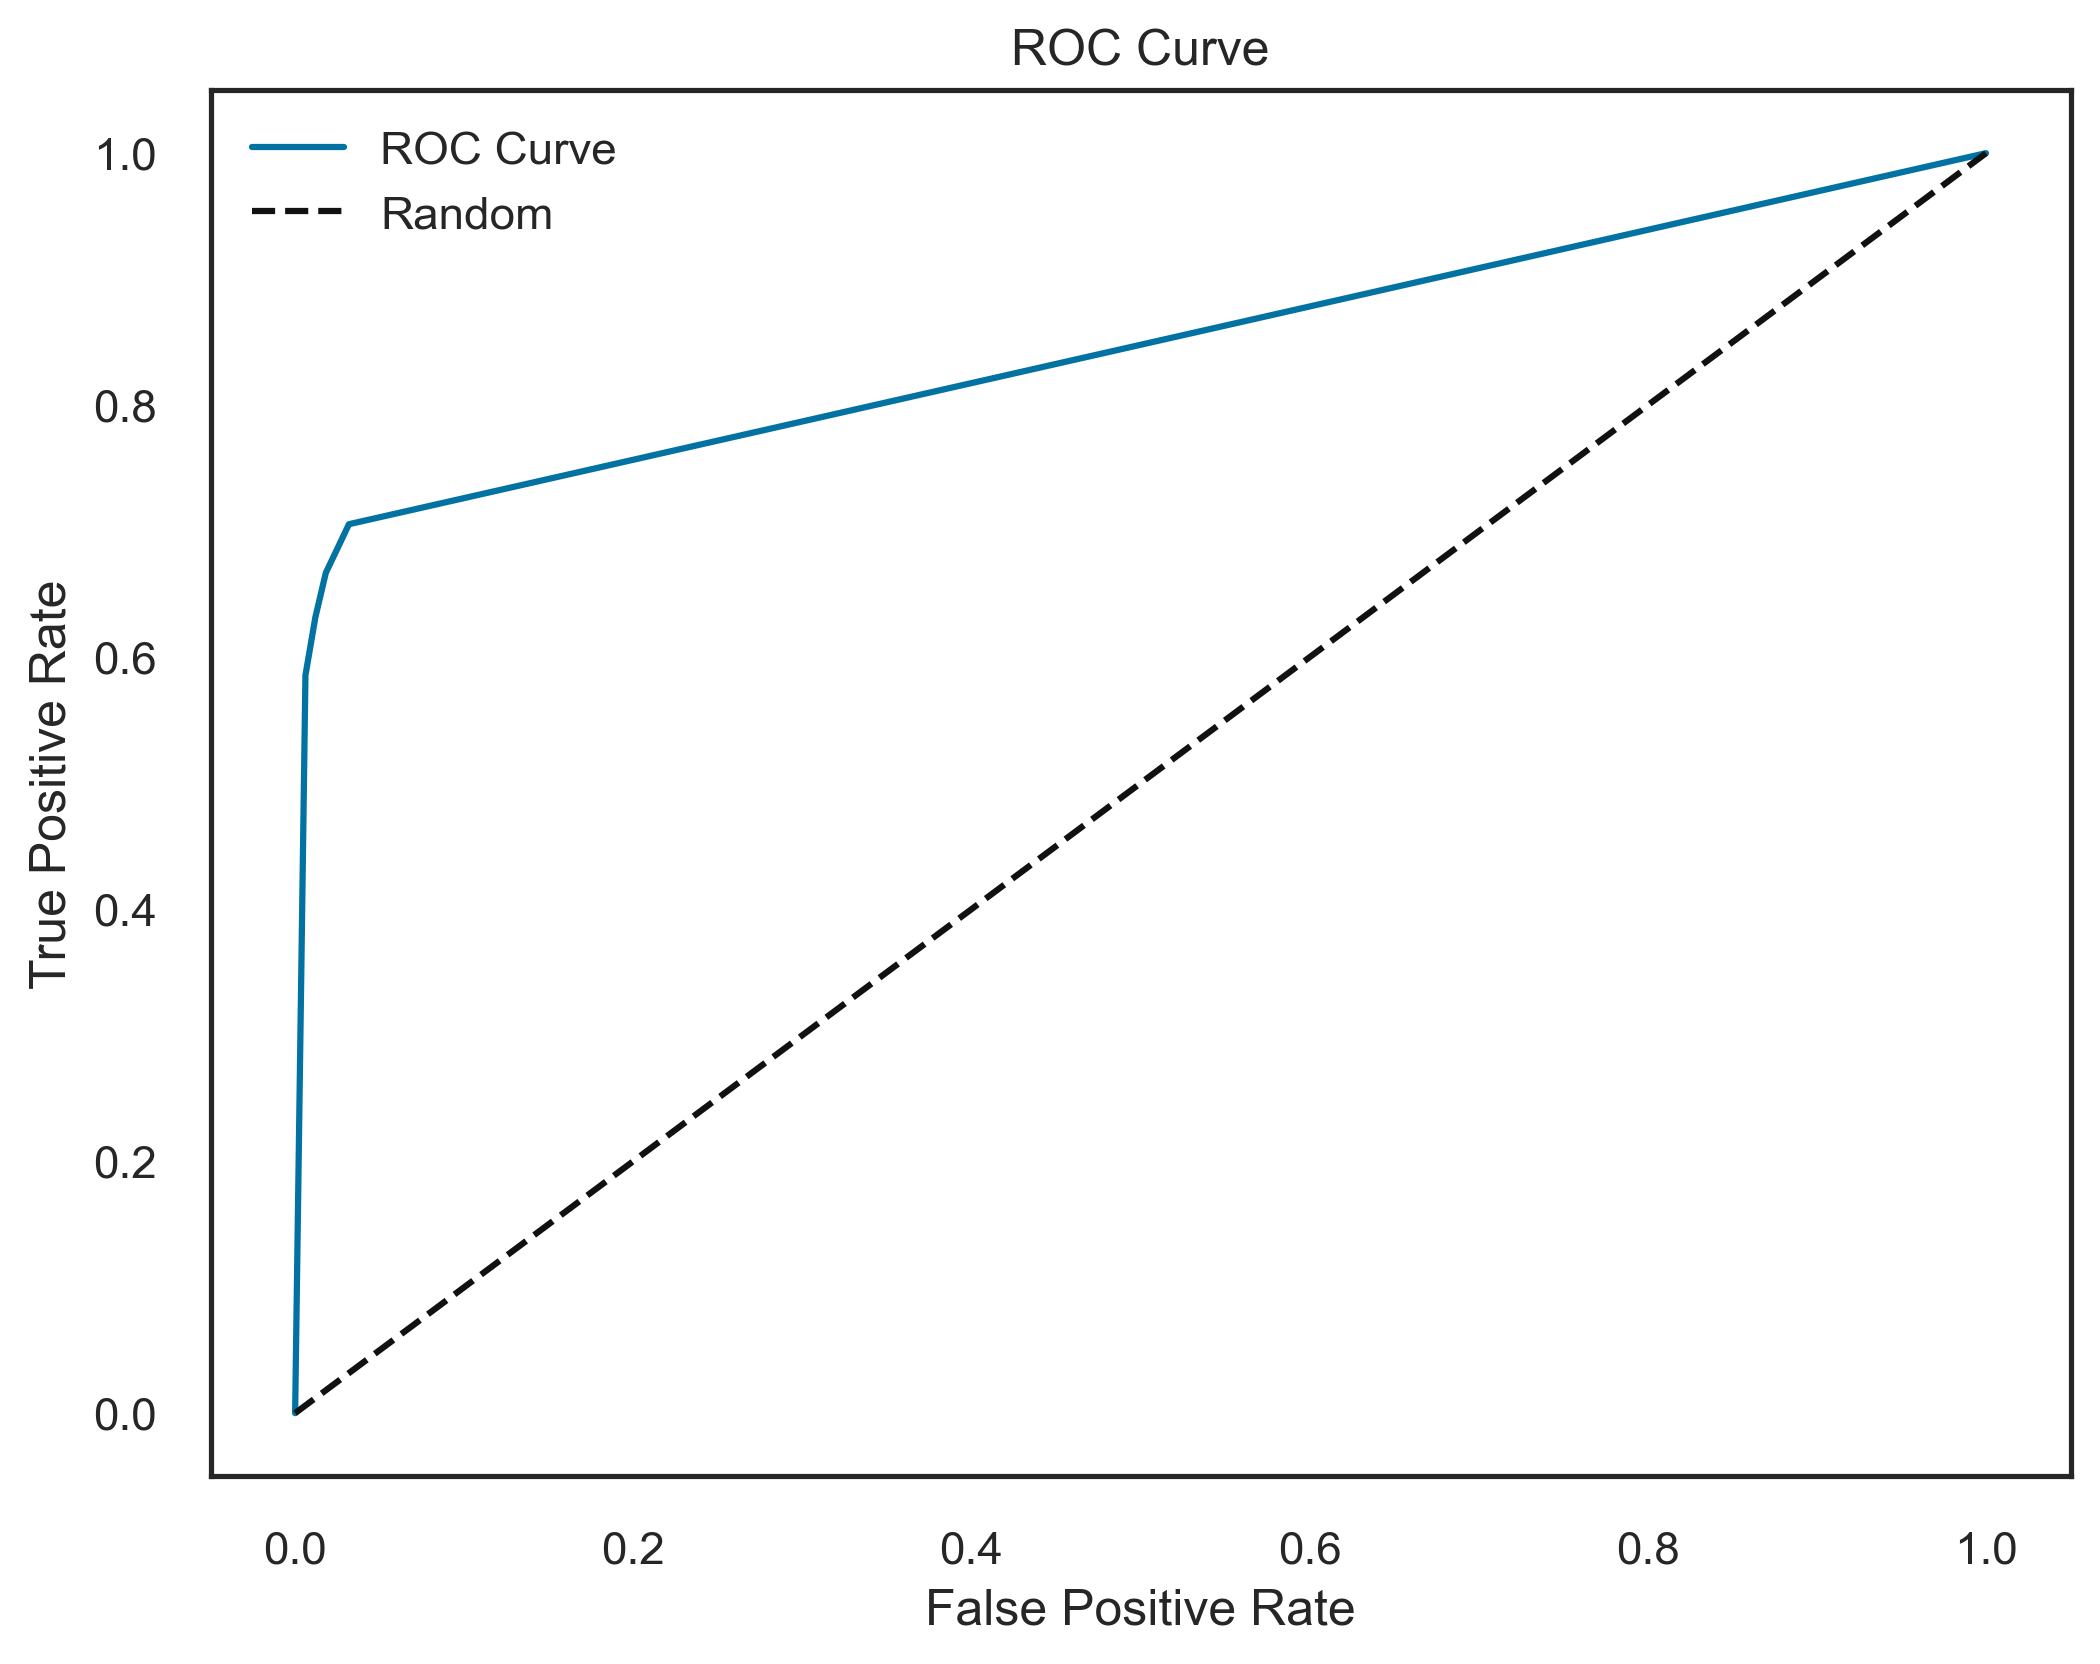

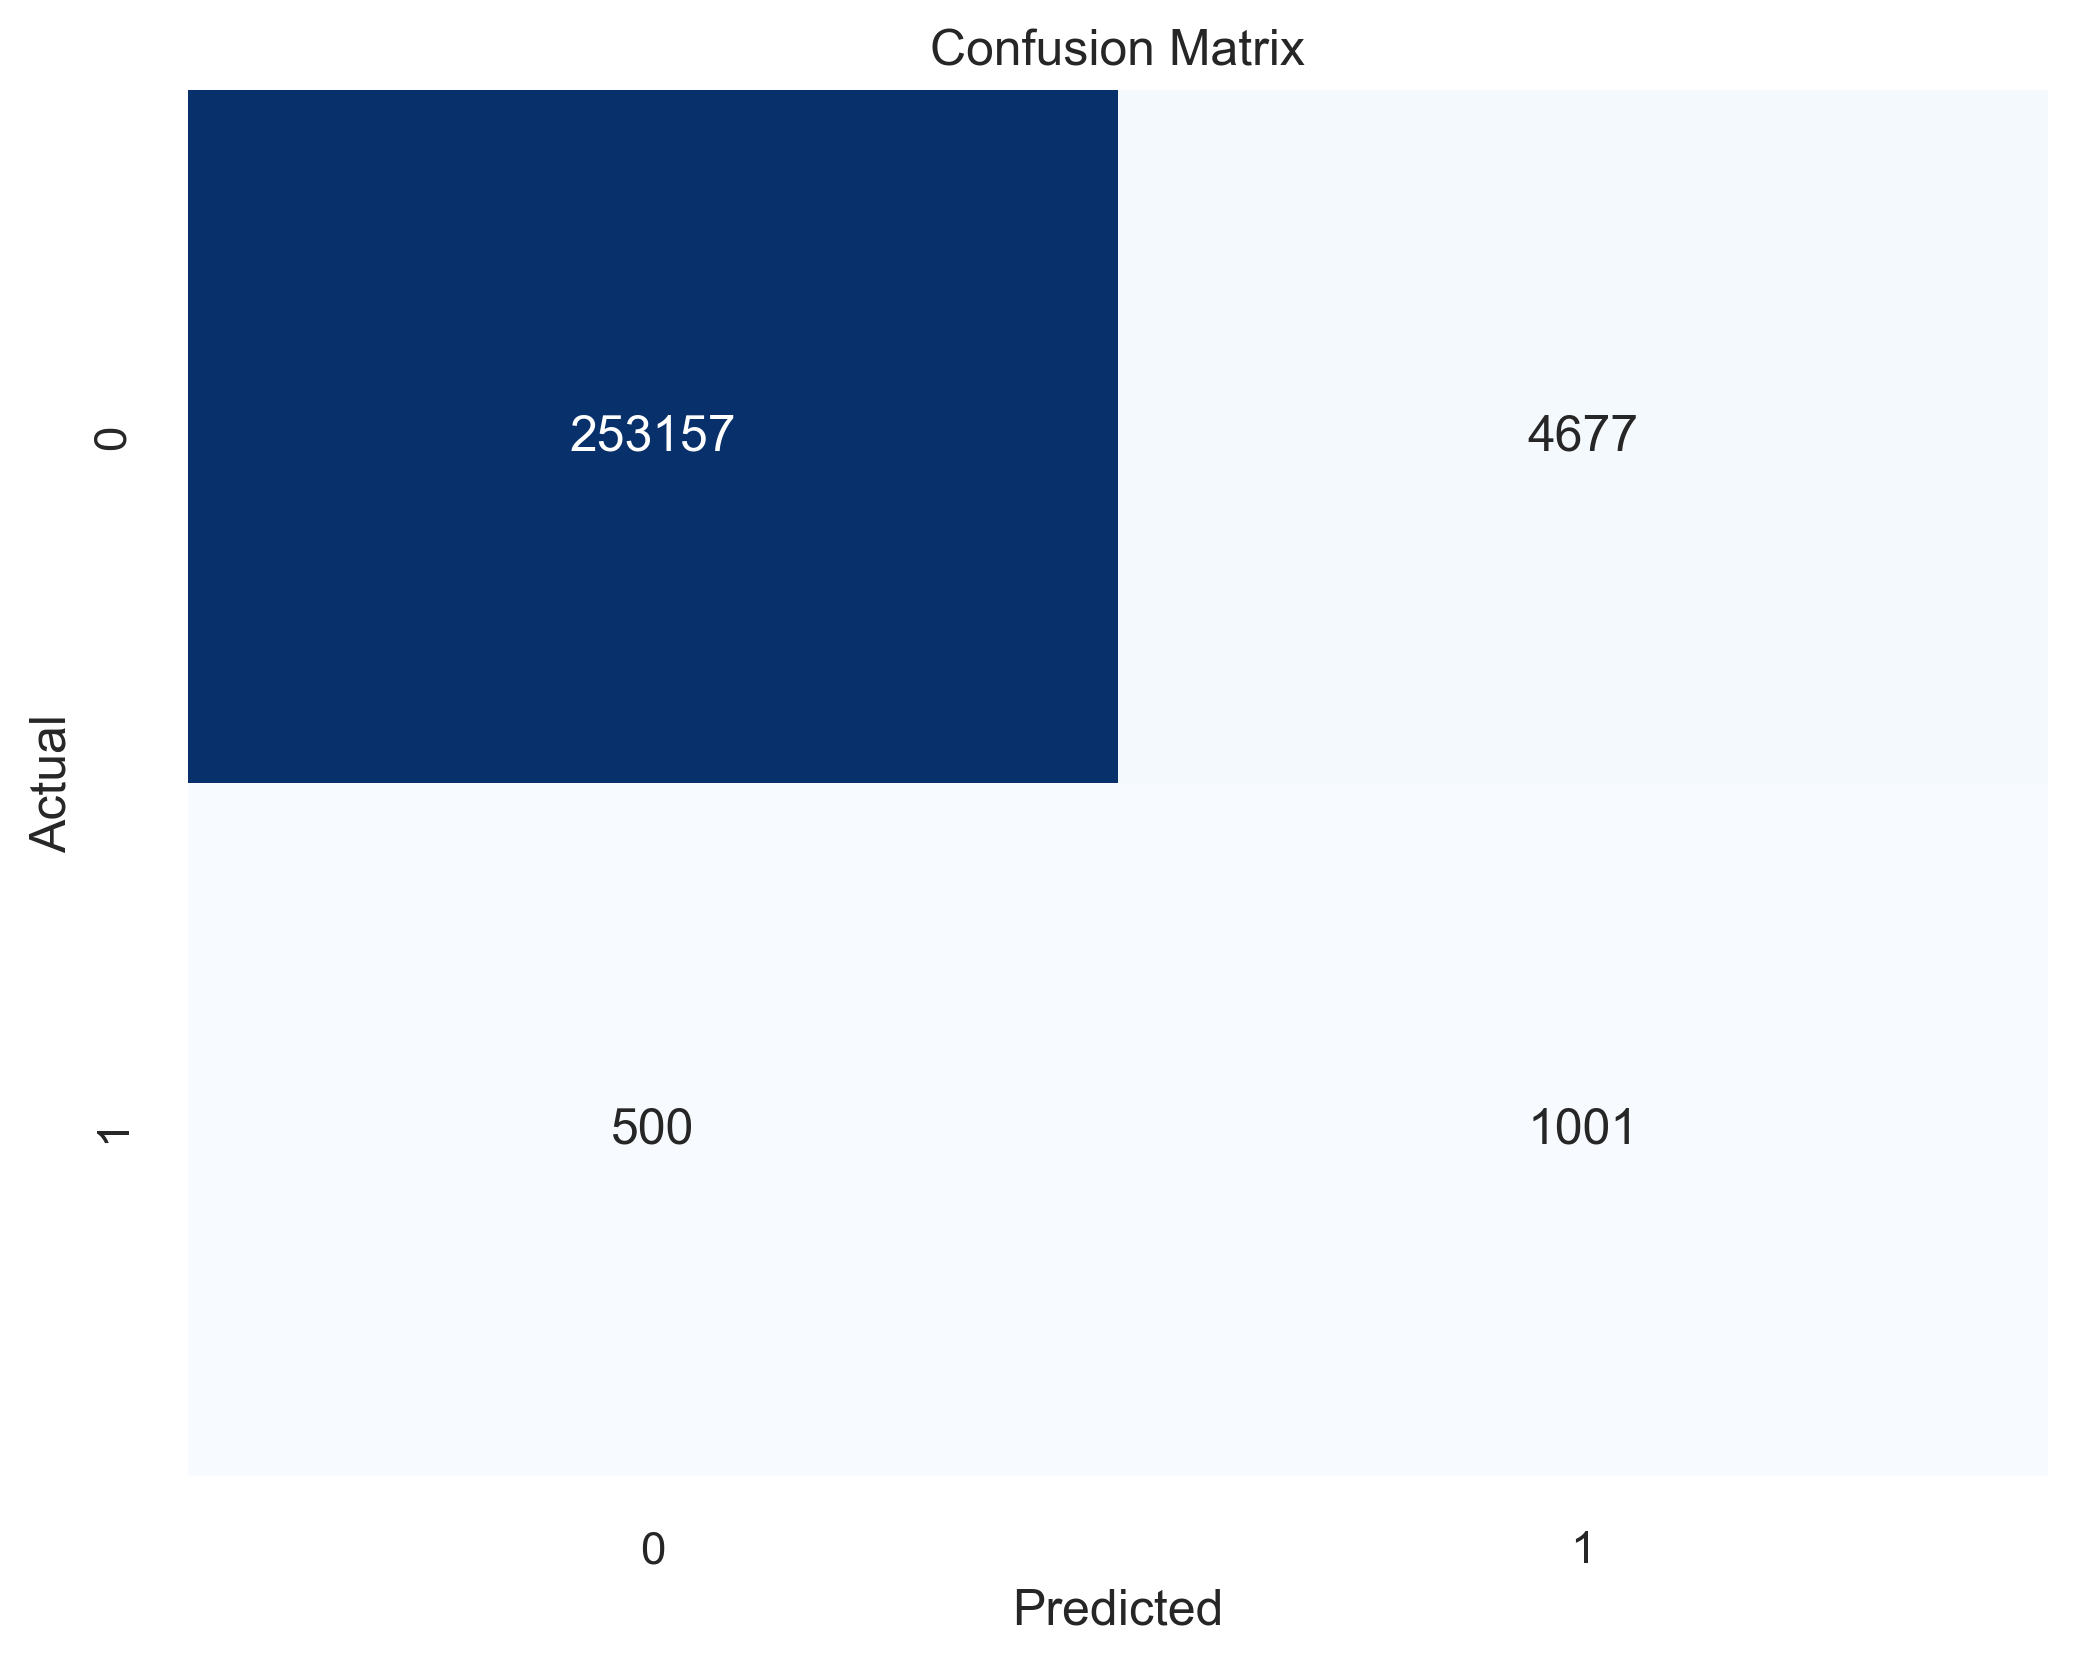

In [264]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_resampled, y_train_resampled)

evaluate_model(knn_model, X_test, y_test)

# Support Vector Machine (SVM):

Accuracy: 0.5082769390942218
ROC AUC: 0.6715313234942849
F1 Score: 0.016580422762221315
Confusion Matrix:
[[130739 127095]
 [   426   1075]]


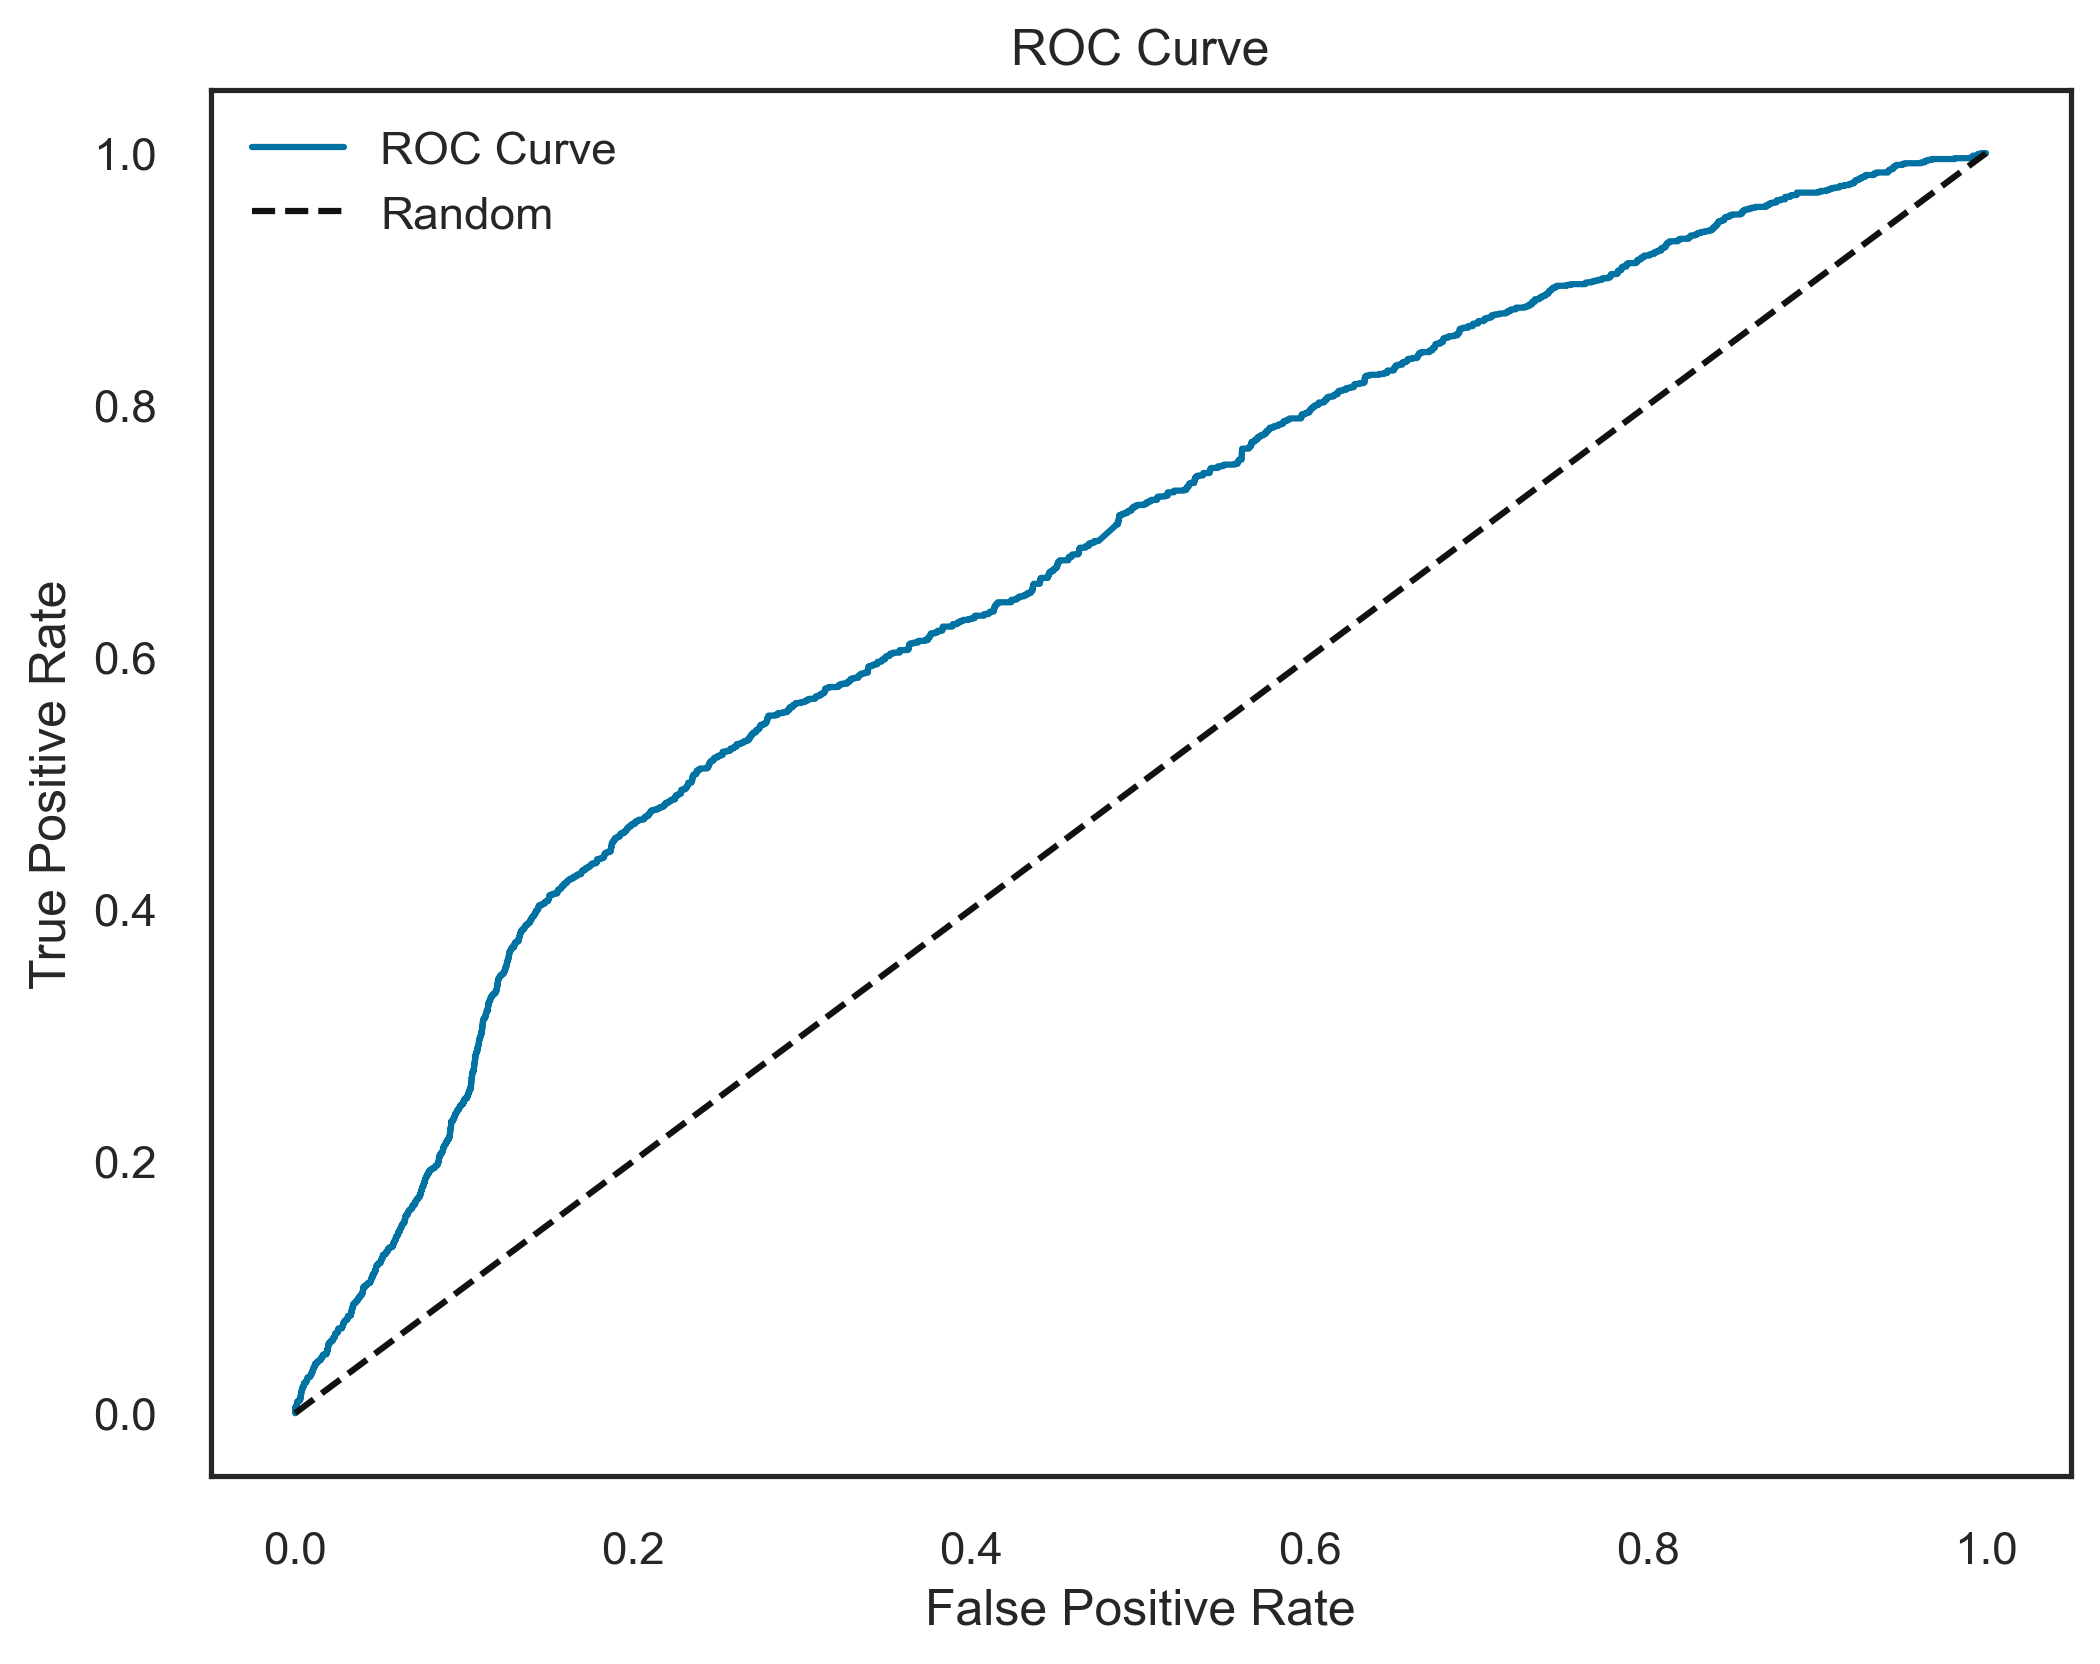

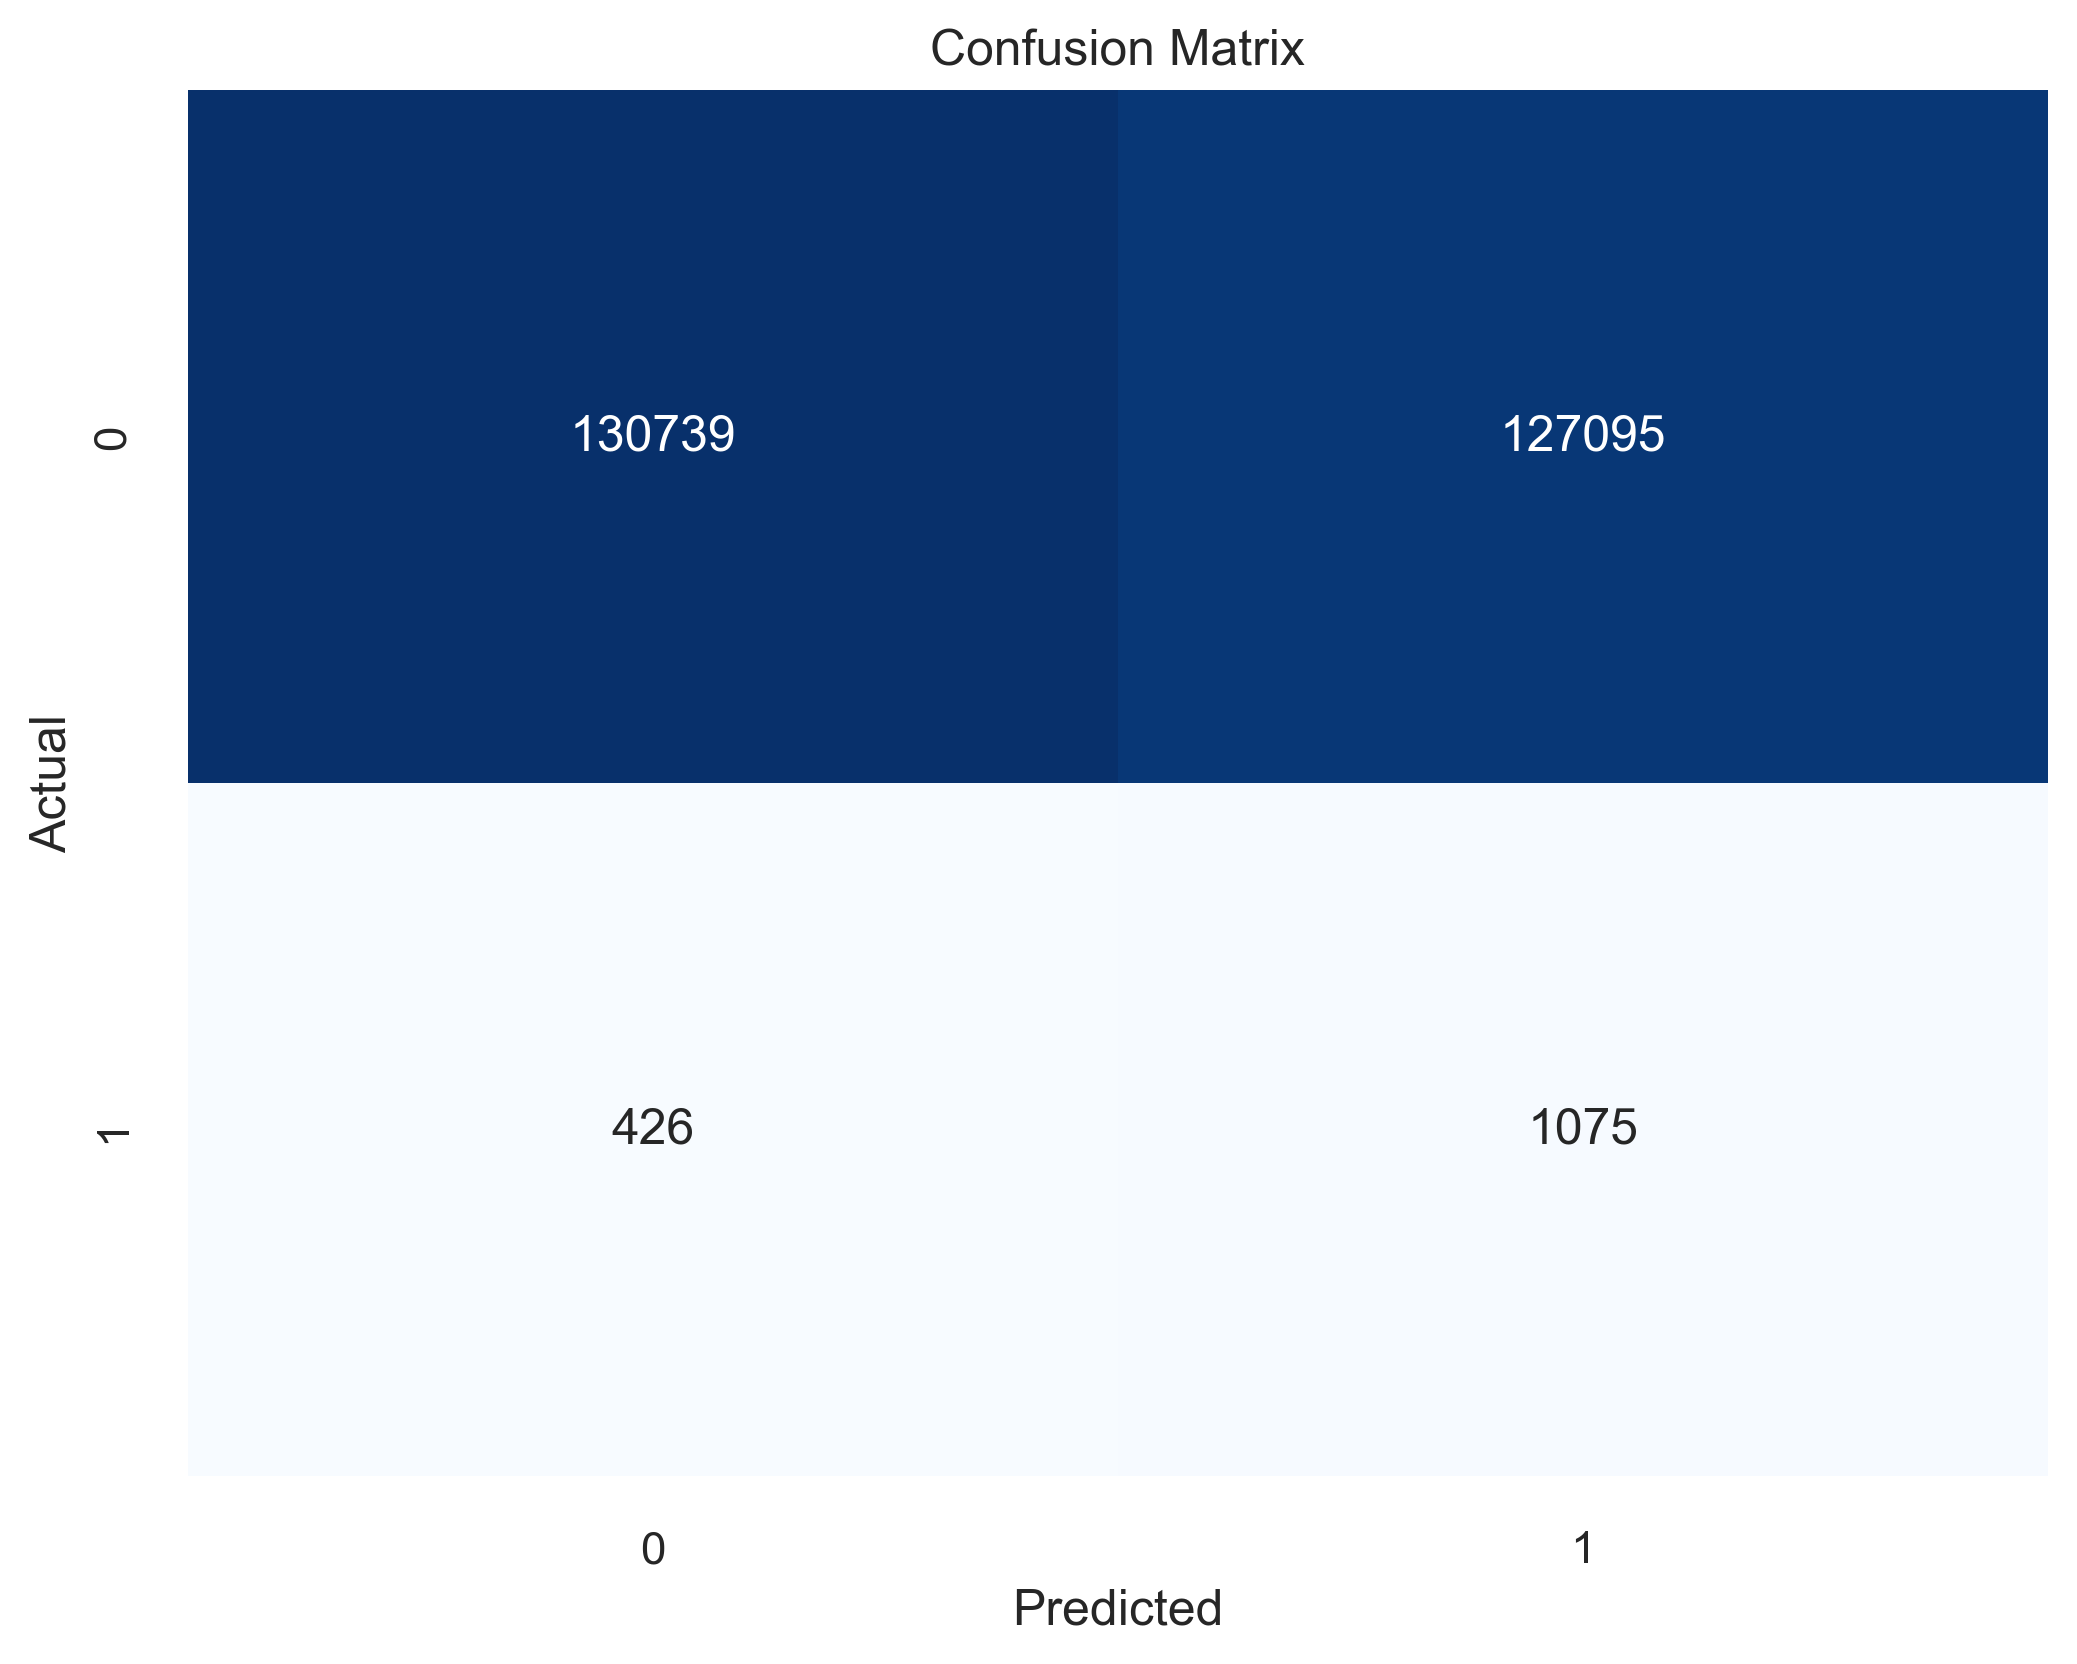

In [273]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC

# Subset of 10,000 samples
subset_size = 1000
X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]

# Random Oversampling on the subset
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_subset, y_train_subset)

# Create and train SVM model on resampled data
svm_model = SVC(probability=True)
svm_model.fit(X_train_resampled, y_train_resampled)

# Evaluate SVM on the full test set
evaluate_model(svm_model, X_test, y_test)


# LightGBM

[LightGBM] [Info] Number of positive: 1031335, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.9960128790946073
ROC AUC: 0.998081612266246
F1 Score: 0.7268885367142102
Confusion Matrix:
[[256925    909]
 [   125   1376]]


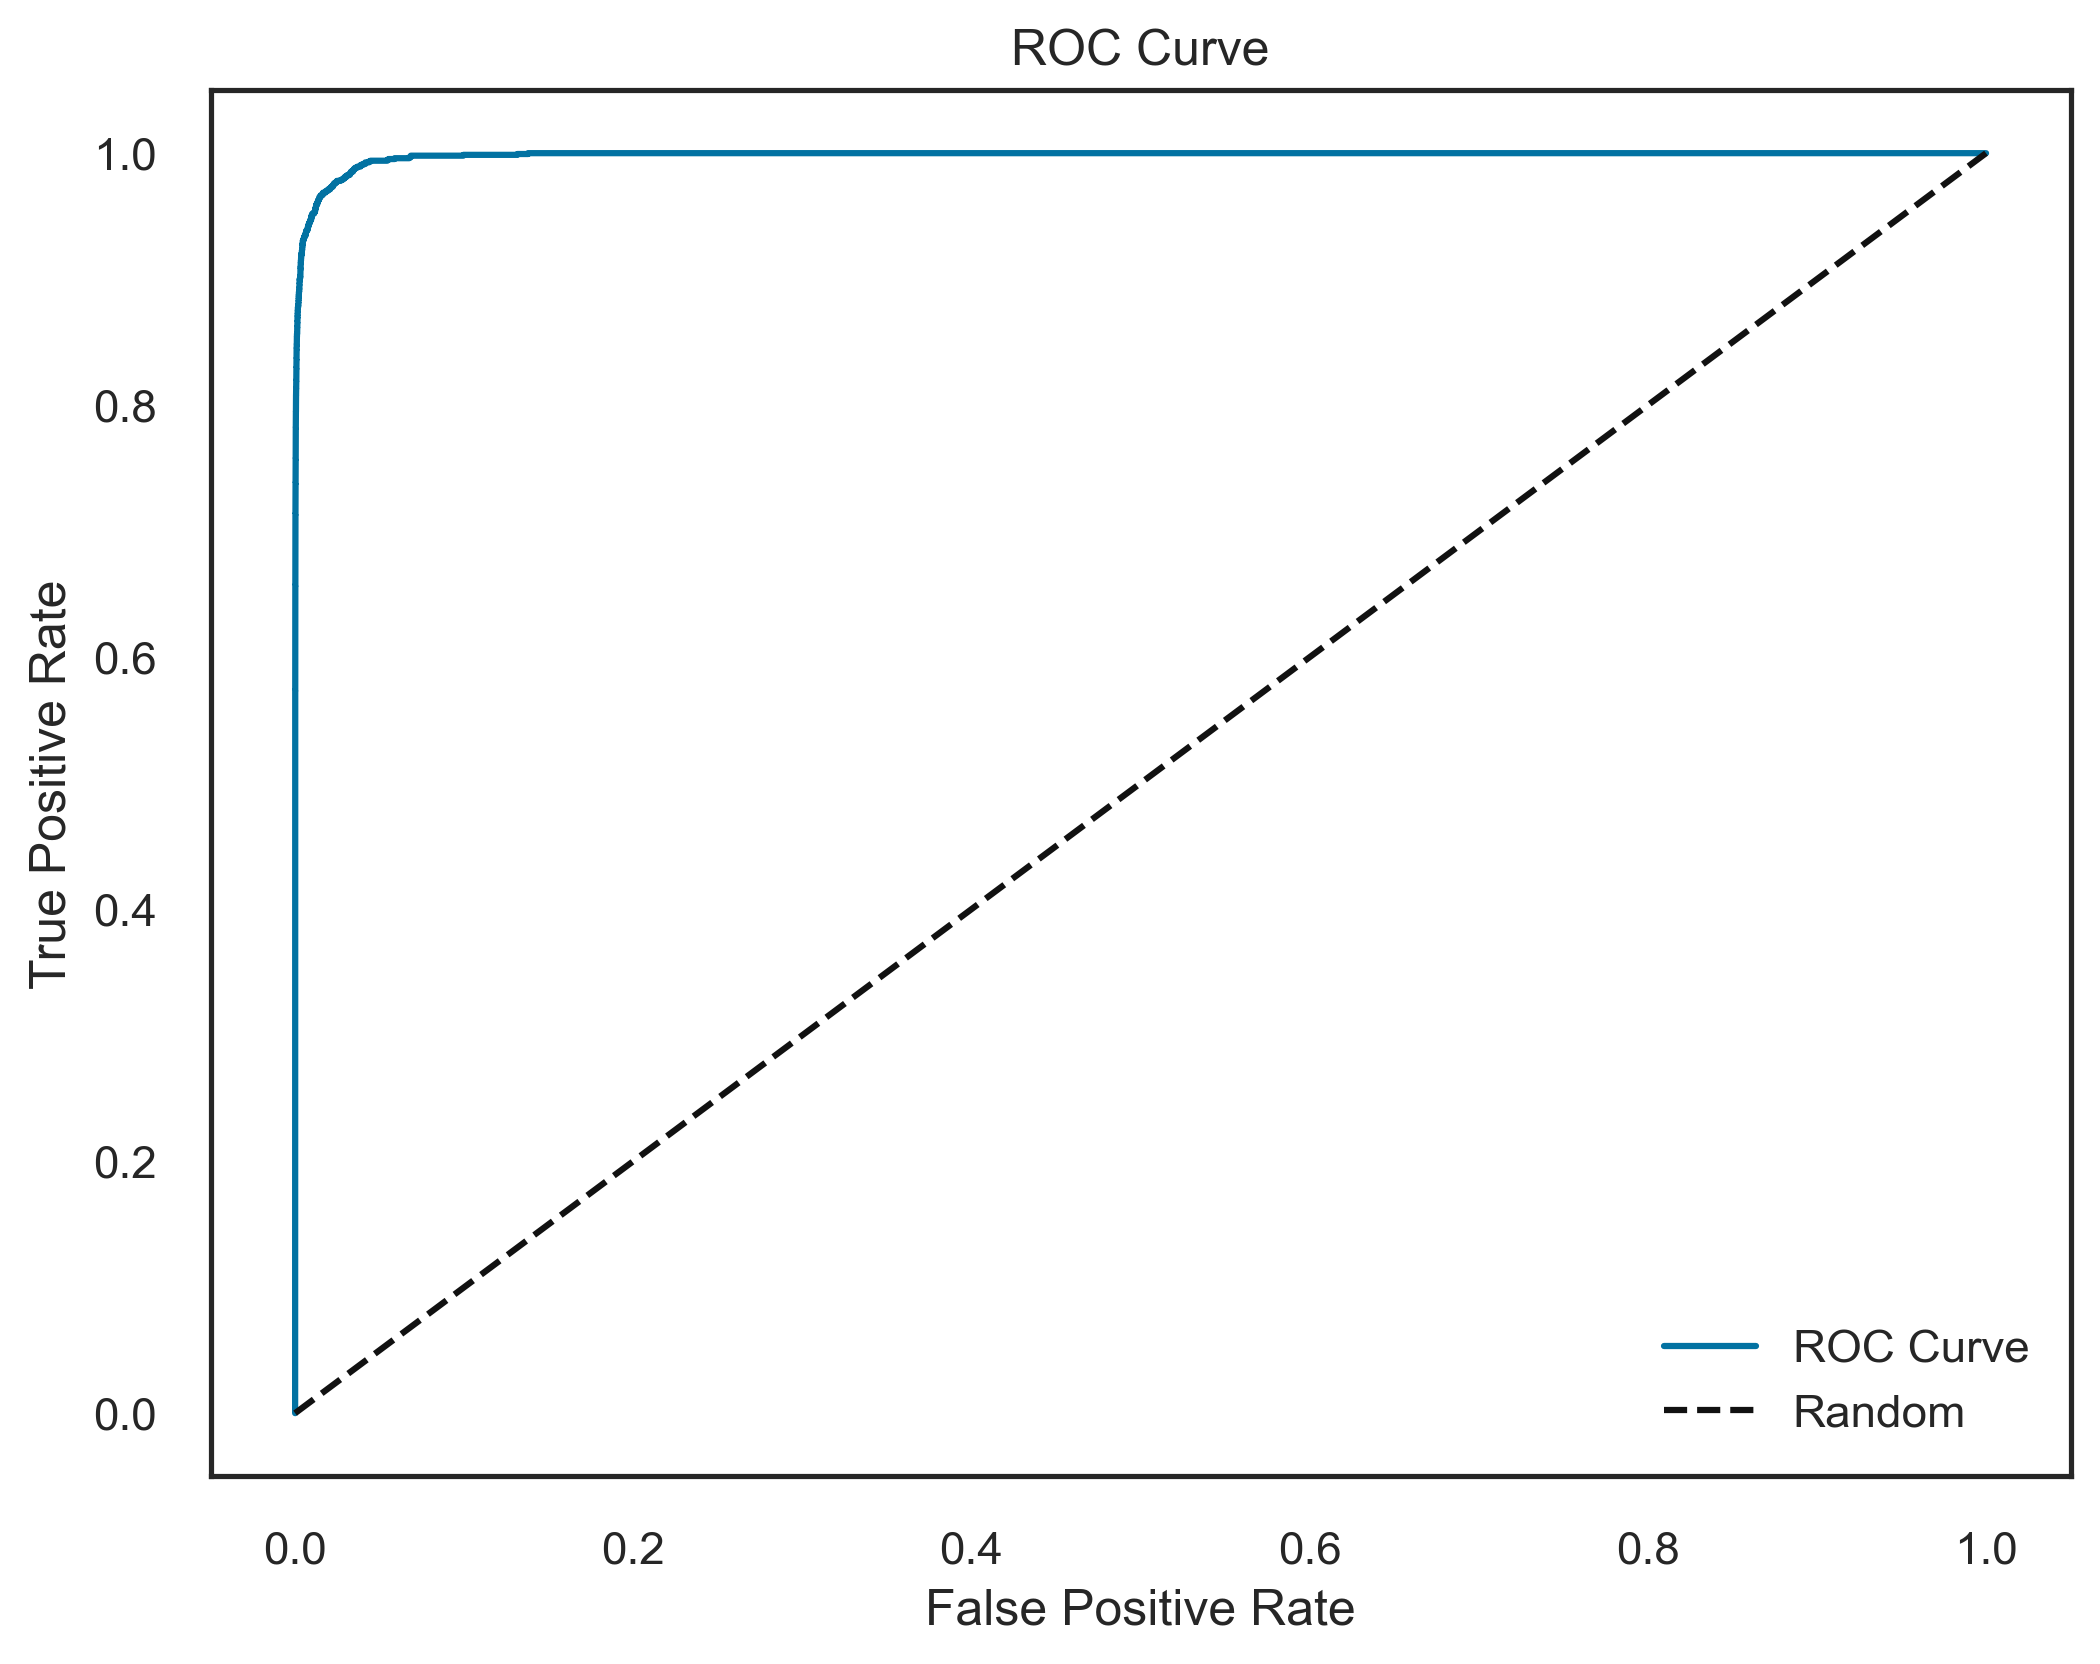

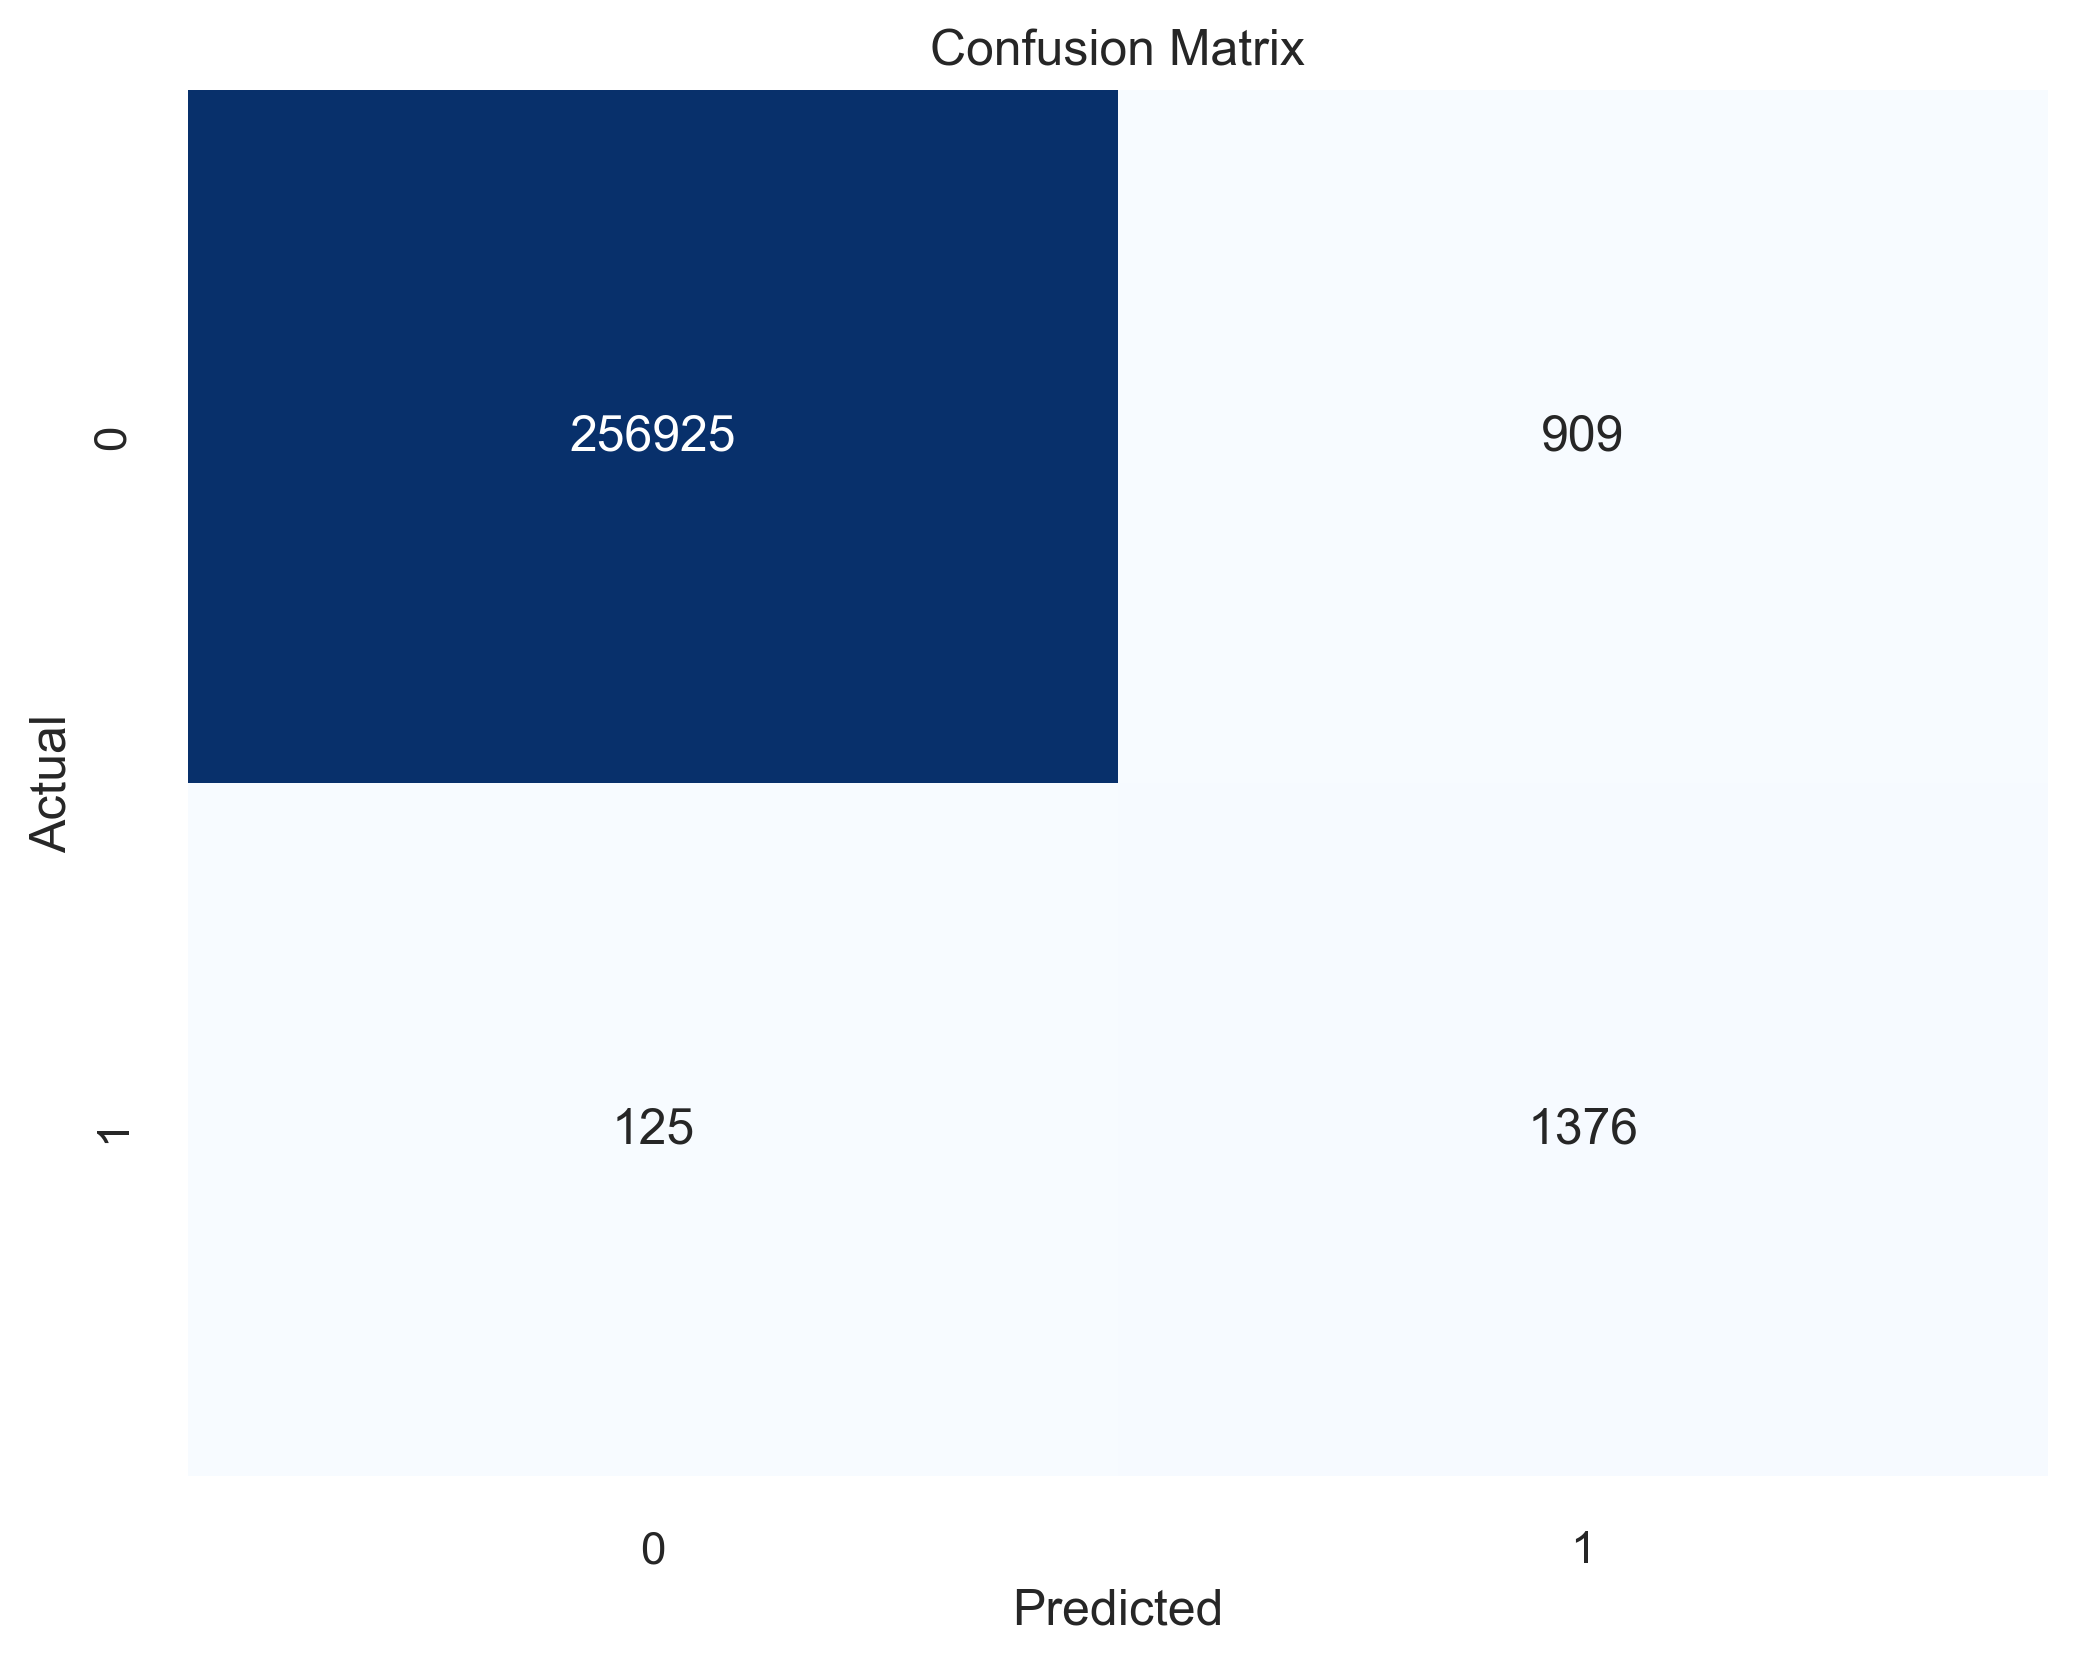

In [265]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=23)
lgbm.fit(X_train_resampled, y_train_resampled)

evaluate_model(lgbm, X_test, y_test)

# Hyperparameter Tuning

Let's create a function that optimizes our desired metric. Since we can't use accuracy because of the imbalance, we are going to optimize F1 score!

### LightGBM Tuning:

In [279]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid for LightGBM
lgbm_param_grid = {
    'num_leaves': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [10, 20, 30],
    'boosting_type': ['gbdt', 'dart']
}

# Create the LightGBM model
lgbm_model = LGBMClassifier(random_state=23)

# Define F1 score as the scoring metric
scorer = make_scorer(f1_score)

# Perform Randomized Search for LightGBM
lgbm_random_search = RandomizedSearchCV(lgbm_model, lgbm_param_grid, scoring=scorer, cv=3, n_iter=50, random_state=23, n_jobs=-1)
lgbm_random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and F1 score
print("Best Parameters for LightGBM:", lgbm_random_search.best_params_)
print("Best F1 Score for LightGBM:", lgbm_random_search.best_score_)


[LightGBM] [Info] Number of positive: 992, number of negative: 992
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 1984, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [280]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Create LightGBM model with the best parameters
best_lgbm_model = LGBMClassifier(
    num_leaves=50,
    n_estimators=100,
    min_child_samples=20,
    learning_rate=0.1,
    boosting_type='dart',
    random_state=23
)

# Train the model on the resampled training data
best_lgbm_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred_lgbm = best_lgbm_model.predict(X_test)
classification_rep = classification_report(y_test, y_pred_lgbm)

print("Classification Report for LightGBM:")
print(classification_rep)


[LightGBM] [Info] Number of positive: 992, number of negative: 992
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 1984, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

### Random Forest Tuning:

In [281]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=23)

# Perform Randomized Search for Random Forest
rf_random_search = RandomizedSearchCV(rf_model, rf_param_grid, scoring=scorer, cv=3, n_iter=50, random_state=23, n_jobs=-1)
rf_random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and F1 score
print("Best Parameters for Random Forest:", rf_random_search.best_params_)
print("Best F1 Score for Random Forest:", rf_random_search.best_score_)


Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': False}
Best F1 Score for Random Forest: 1.0


In [282]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=30,
    bootstrap=False,
    random_state=23
)

# Train the model on the resampled training data
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred_rf = best_rf_model.predict(X_test)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print("Classification Report for Random Forest:")
print(classification_rep_rf)


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.51      0.16      0.24      1501

    accuracy                           0.99    259335
   macro avg       0.75      0.58      0.62    259335
weighted avg       0.99      0.99      0.99    259335



In [61]:
# X = df_train.drop(columns=["is_fraud"])
# y = df_train["is_fraud"]

In [83]:
from sklearn.metrics import f1_score

# Assuming rf_model is your trained random forest model
# Replace "your_target_column" with the actual name of your target column
y = test["is_fraud"]
test2 = test.drop(columns=["is_fraud"])
# Make predictions
y_pred = gb_model.predict(test2)

# Calculate F1 score
f1 = f1_score(y, y_pred)

# Print the F1 score
print(f"F1 Score: {f1}")


F1 Score: 0.06757495394457153


In [84]:
submission_df = pd.DataFrame({'ID': range(1, len(df_test) + 1), 'is_fraud': y_pred})
submission_df.to_csv('submission_logistic.csv', index=False)